# Summarize models

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint
  
## Table of contents

 1. [Import and define functions](#Import-and-define-functions)
 1. [Define configuration settings](#Define-configuration-settings)
 1. [Load data](#Load-data)
 1. [Summarize predictors](#Summarize-predictors)
 1. [Summarize model residuals](#Summarize-model-residuals)
 1. [Summarize observed and predicted distances](#Summarize-observed-and-predicted-distances)
 1. [Summarize model forecasting error](#Summarize-model-forecasting-error)

## Import and define functions
[back to top](#Summarize-models)

In [119]:
import Bio.SeqIO
from collections import defaultdict
import glob
import json
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import sys

%matplotlib inline

In [120]:
sys.path.insert(0, "../src")

In [122]:
from fit_model import DistanceExponentialGrowthModel

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [5]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def root_mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the root mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        root mean square error between observed and estimated values
    """
    return np.sqrt(np.mean((observed - estimated) ** 2))

def mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean square error between observed and estimated values
    """
    return np.mean((observed - estimated) ** 2)

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None,
                    height=4, aspect=1, col_order=None, col_wrap=4, markersize=15):
    g = sns.FacetGrid(data, col=predictors_column, col_order=col_order, col_wrap=col_wrap, hue=hue, height=height, aspect=aspect)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column, markersize=markersize)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc", zorder=-10)

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings
[back to top](#Summarize-models)

In [6]:
"""
predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star"
]
"""

predictor_names_order = [
    "naive",
    "fitness",
    "ep_x",
    "ne_star",
    "lbi",
    "delta_frequency",
    "ep_x-ne_star",
    "lbi-ne_star",
    "lbi-ep_x-ne_star"
]

minimal_predictor_names_order = [
    "naive",
    "ep_x",
    "ne_star",
    "lbi",
    "lbi-ep_x-ne_star"
]

In [7]:
data_root = "../results/builds/h3n2/90_viruses_per_month/sample_0/2000-10-01--2015-10-01/"
data_root = "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/"
data_root = "../results/builds/h3n2/5_viruses_per_month/sample_0/1994-10-01--2015-10-01/"

data_root = "../results/builds/h3n2/10_viruses_per_month/sample_0/1994-10-01--2015-10-01/"

data_root = "../results/builds/simulations/100/2000-10-01--2100-10-01/"
#data_root = "../results/builds/simulations/20/2000-10-01--2100-10-01/"
#data_root = "../results/builds/h3n2/30_viruses_per_month/sample_0/1994-10-01--2015-10-01/"

data_root = "../results/builds/simulations/100/2010-10-01--2030-10-01/"

## Load data
[back to top](#Summarize-models)

In [8]:
tip_attributes_df = pd.read_table(data_root + "tip_attributes_with_weighted_distances.tsv", parse_dates=["timepoint"])

In [9]:
observed_weighted_distances = tip_attributes_df.loc[:, ["timepoint", "strain", "frequency", "weighted_distance_to_future"]].copy()

In [10]:
observed_weighted_distances["y"] = observed_weighted_distances["weighted_distance_to_future"]

In [11]:
model_jsons = glob.glob(data_root + "models_by_distances/*.json")

In [12]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [13]:
models_by_predictors["lbi"]["cost_function"]

'diffsum'

In [14]:
models_by_predictors["lbi"]["l1_lambda"]

0.5

In [15]:
models_by_predictors["lbi"]["training_window"]

6

In [16]:
models_by_predictors["lbi"]["pseudocount"]

In [17]:
type(models_by_predictors["lbi"])

dict

In [18]:
sorted(models_by_predictors.keys())

['delta_frequency',
 'ep_x',
 'ep_x-ne_star',
 'fitness',
 'lbi',
 'lbi-ep_x-ne_star',
 'lbi-ne_star',
 'naive',
 'ne_star']

In [19]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'mean_stds_mean', 'mean_stds_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [20]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'mean_stds', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [21]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

822

In [22]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['X', 'y', 'y_hat'])

In [23]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[3.0766107982927116]

In [24]:
models_by_predictors["lbi"]["scores"][0]["mean_stds"]

[0.049589071840739976]

In [25]:
len(models_by_predictors["lbi"]["scores"])

23

Build data frames for plotting from the model scores.

In [26]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
mean_stds_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": pd.to_datetime(scores["validation_timepoint"]),
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient, mean_std in zip(model["predictors"], scores["coefficients"], scores["mean_stds"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": pd.to_datetime(scores["validation_timepoint"])
            })
            
            mean_stds_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "mean_std": mean_std,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        X = pd.DataFrame(scores["validation_data"]["X"])
        X["timepoint"] = pd.to_datetime(X["timepoint"])

        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])
        y["future_timepoint"] = pd.to_datetime(y["future_timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["y"] = y_hat["y"]
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y_hat.merge(
            observed_weighted_distances,
            on=["timepoint", "strain", "frequency"],
            suffixes=["_hat", ""]
        )
        frequency_df["residual"] = frequency_df["y"] - frequency_df["y_hat"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)

        training_X = pd.DataFrame(scores["training_data"]["X"])
        training_X["timepoint"] = pd.to_datetime(training_X["timepoint"])

        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["y"] = training_y_hat["y"]
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y_hat.merge(
            observed_weighted_distances,
            on=["timepoint", "strain", "frequency"],
            suffixes=["_hat", ""]
        )
        residual_df["residual"] = residual_df["y"] - residual_df["y_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors

        residuals_dfs.append(residual_df)
        
overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
mean_stds_by_time_df = pd.DataFrame(mean_stds_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [27]:
errors_by_time_df["validation_timepoint"].head()

0   2018-10-01
1   2019-04-01
2   2019-10-01
3   2020-04-01
4   2020-10-01
Name: validation_timepoint, dtype: datetime64[ns]

In [28]:
training_y.head()

frequency future_timepoint         strain  timepoint  \
0   0.000001       2023-10-01  sample_2292_5 2022-10-01   
1   0.000001       2023-10-01  sample_2292_6 2022-10-01   
2   0.000001       2023-10-01  sample_2292_9 2022-10-01   
3   0.000004       2023-10-01  sample_2296_4 2022-10-01   
4   0.000004       2023-10-01  sample_2296_6 2022-10-01   

   weighted_distance_to_future          y  
0                    16.024101  16.024101  
1                    14.977615  14.977615  
2                    14.950585  14.950585  
3                    17.910819  17.910819  
4                    13.870777  13.870777

In [29]:
y_hat.head()

fitness  frequency  projected_frequency          strain  timepoint  \
0 -6.066211   0.000001         1.289881e-10   sample_2892_1 2029-10-01   
1  1.953443   0.000001         3.921399e-07  sample_2892_10 2029-10-01   
2 -5.884985   0.000001         1.546162e-10   sample_2892_2 2029-10-01   
3  3.744107   0.000001         2.350262e-06   sample_2892_5 2029-10-01   
4 -3.766754   0.000001         1.285852e-09   sample_2892_6 2029-10-01   

   weighted_distance_to_future  weighted_distance_to_present          y  
0                    32.167281                     30.111098  33.330689  
1                    28.366157                     26.101922  29.386827  
2                    20.631362                     17.875770  16.835289  
3                    18.024669                     16.023268  12.896664  
4                    16.762421                     15.548447  12.054680

In [30]:
frequency_df.head()

fitness  frequency  projected_frequency          strain  timepoint  \
0  0.620899   0.000001         3.064112e-07   sample_1792_1 2018-10-01   
1  1.514305   0.000001         7.486971e-07  sample_1792_10 2018-10-01   
2  1.884708   0.000001         1.084352e-06   sample_1792_3 2018-10-01   
3 -1.982485   0.000004         9.072551e-08  sample_1796_10 2018-10-01   
4  1.688592   0.000004         3.564988e-06   sample_1796_2 2018-10-01   

   weighted_distance_to_future_hat  weighted_distance_to_present      y_hat  \
0                        13.257480                     12.452205  10.060383   
1                        14.406171                     13.588543  11.755805   
2                        21.965162                     19.062104  19.719243   
3                        14.334199                     13.482480  12.616424   
4                        21.950493                     19.157479  19.612328   

   weighted_distance_to_future          y  residual validation_timepoint  \
0                    13.257480  13.257480  3.197097           2018-10-01   
1                    14.406171  14.406171  2.650366           2018-10-01   
2                    21.965162  21.965162  2.245919           2018-10-01   
3                    14.334199  14.334199  1.717775           2018-10-01   
4                    21.950493  21.950493  2.338165           2018-10-01   

  predictors  
0    fitness  
1    fitness  
2    fitness  
3    fitness  
4    fitness

In [31]:
residual_df.head()

fitness  frequency  projected_frequency          strain  timepoint  \
0 -0.283677   0.000001         4.467453e-08  sample_1092_10 2011-10-01   
1  0.681426   0.000001         1.172732e-07   sample_1092_2 2011-10-01   
2  0.346955   0.000001         8.393446e-08   sample_1092_5 2011-10-01   
3 -7.582206   0.000001         3.022380e-11   sample_1092_6 2011-10-01   
4 -0.215975   0.000001         4.780384e-08   sample_1092_9 2011-10-01   

   weighted_distance_to_future_hat  weighted_distance_to_present      y_hat  \
0                        15.012715                     12.116577  10.418554   
1                        19.590264                     16.813736  15.301670   
2                        17.916692                     15.870513  14.159072   
3                        11.909871                      8.207999   5.862026   
4                        19.818186                     17.554672  16.117319   

   weighted_distance_to_future          y  residual validation_timepoint  \
0                    15.012715  15.012715  4.594161           2018-10-01   
1                    19.590264  19.590264  4.288594           2018-10-01   
2                    17.916692  17.916692  3.757620           2018-10-01   
3                    11.909871  11.909871  6.047845           2018-10-01   
4                    19.818186  19.818186  3.700867           2018-10-01   

  predictors  
0    fitness  
1    fitness  
2    fitness  
3    fitness  
4    fitness

In [32]:
residual_df.shape

(270837, 13)

In [33]:
errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint
0    fitness         14.550674           102           2018-10-01
1    fitness         14.408748           102           2019-04-01
2    fitness         16.287138           101           2019-10-01
3    fitness         13.093056            99           2020-04-01
4    fitness         16.020966           103           2020-10-01

In [34]:
overall_errors_df.sort_values("cv_error_mean")

cv_error_mean  cv_error_std        predictors
8      12.958322      2.779432       lbi-ne_star
1      12.959118      2.777763               lbi
2      12.959474      2.777237  lbi-ep_x-ne_star
0      15.428311      3.063061           fitness
4      15.811160      2.339923      ep_x-ne_star
3      15.861482      2.475543           ne_star
5      15.922236      3.361799   delta_frequency
7      17.229124      2.563871             naive
6      17.268274      2.552051              ep_x

## Summarize predictors
[back to top](#Summarize-models)

In [35]:
individual_predictor_names_order = [
    predictor
    for predictor in predictor_names_order
    if not "-" in predictor and predictor != "naive"
]

In [36]:
long_predictors_df = tip_attributes_df.melt(
    id_vars=["strain", "timepoint"],
    value_vars=individual_predictor_names_order,
    var_name="predictor",
    value_name="predictor_value"
)

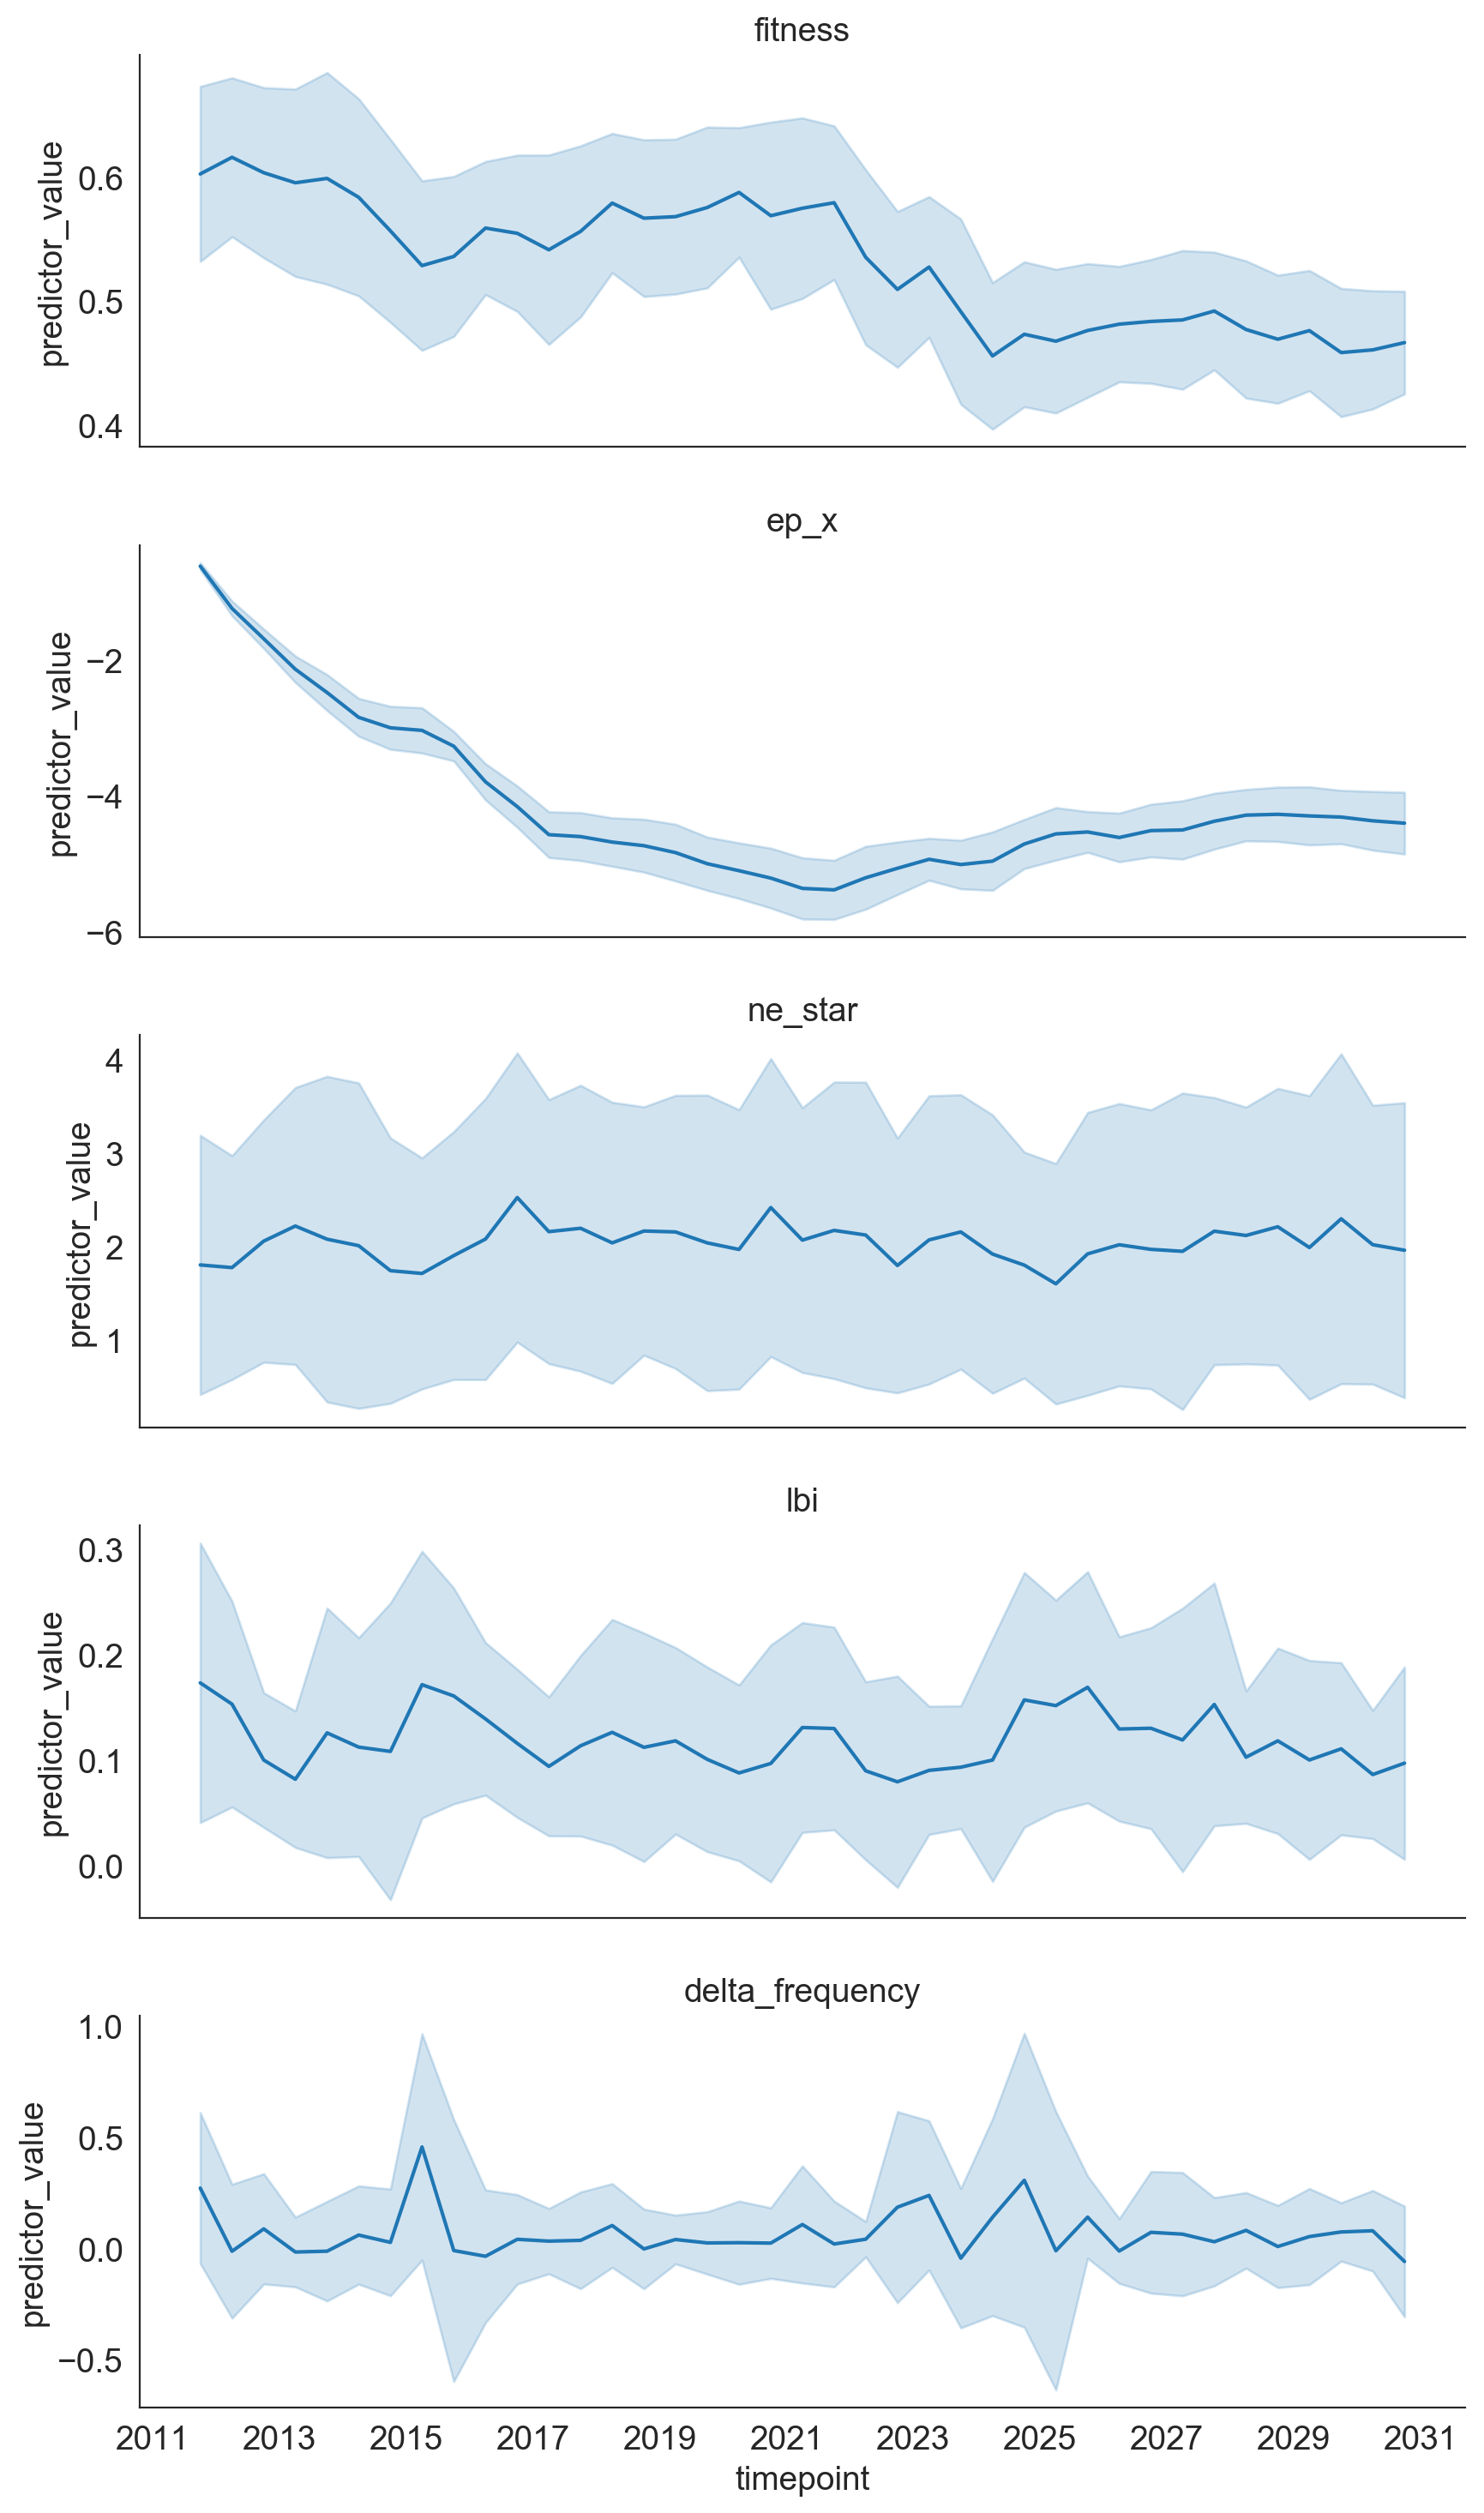

In [37]:
g = sns.FacetGrid(long_predictors_df, row="predictor", aspect=3, sharey=False)
g.map(sns.lineplot, "timepoint", "predictor_value", ci="sd")
g.set_titles("{row_name}")

plt.savefig("../manuscript/figures/predictors_by_timepoint.png")

In [38]:
mean_stds_by_time_df.head()

mean_std predictor predictors validation_timepoint
0  0.070092   fitness    fitness           2018-10-01
1  0.068984   fitness    fitness           2019-04-01
2  0.068918   fitness    fitness           2019-10-01
3  0.068445   fitness    fitness           2020-04-01
4  0.067622   fitness    fitness           2020-10-01

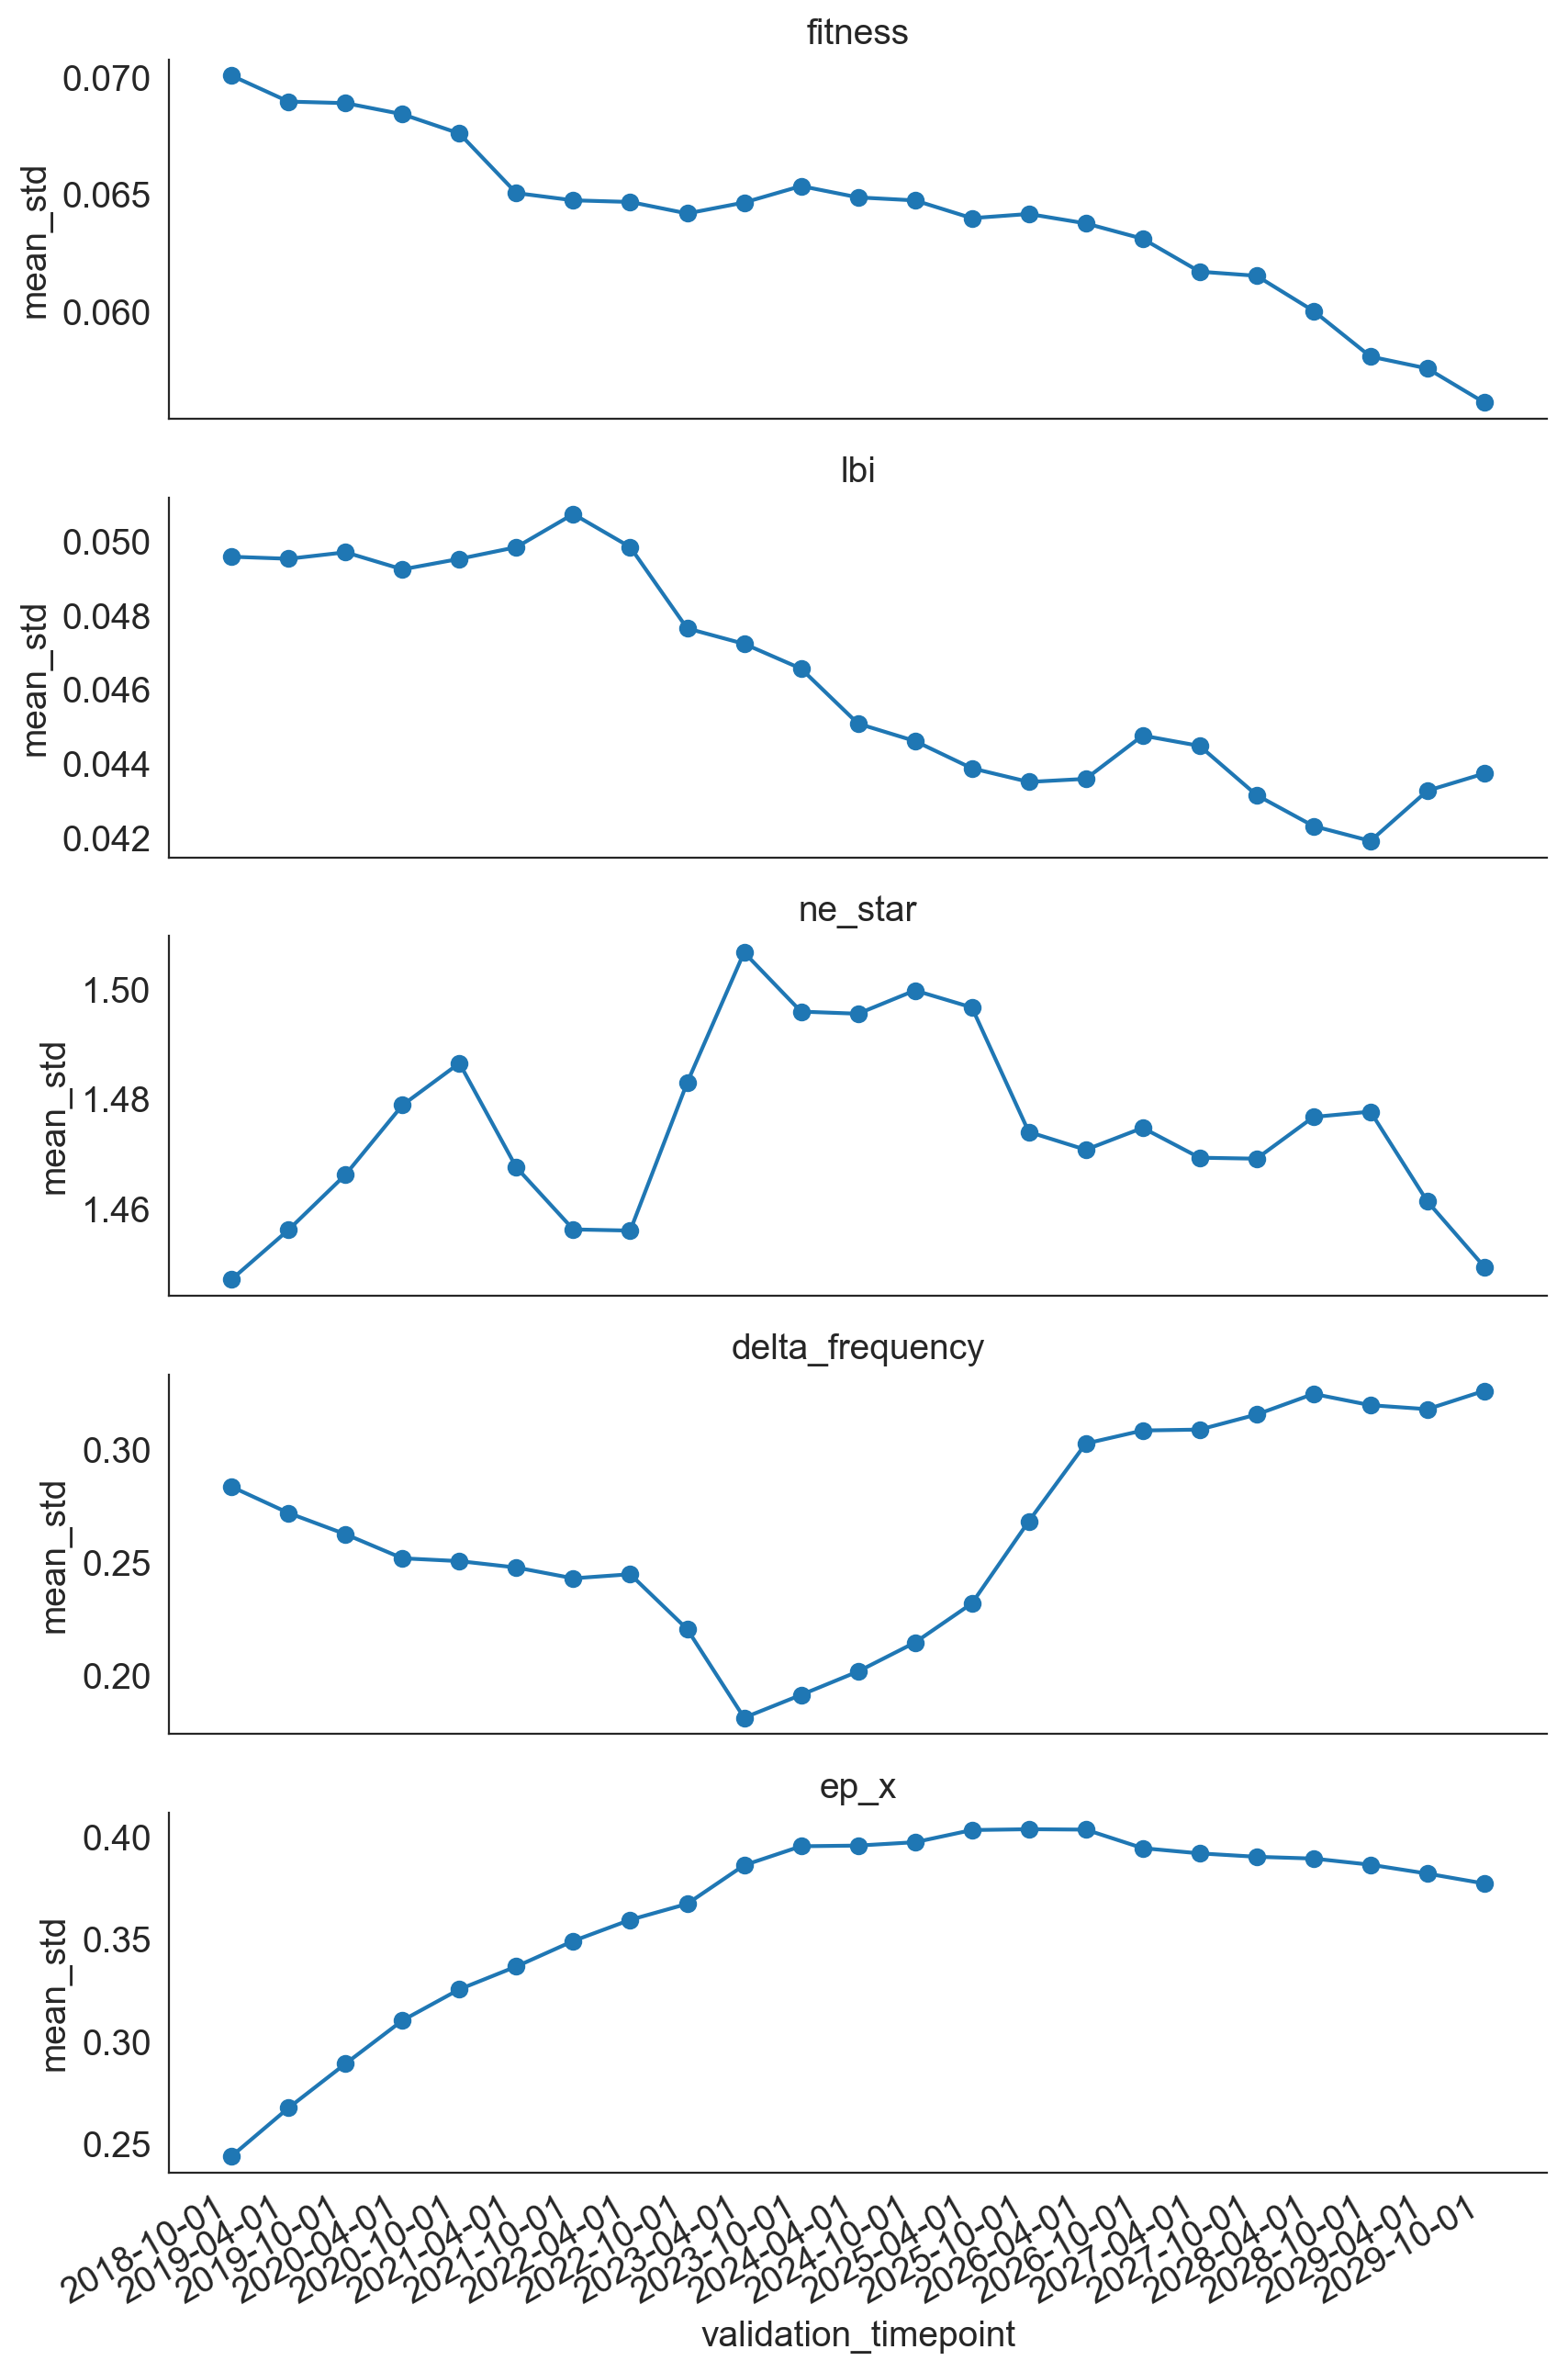

In [39]:
g = sns.FacetGrid(
    mean_stds_by_time_df[mean_stds_by_time_df["predictors"].isin(individual_predictor_names_order)],
    row="predictor",
    aspect=3,
    sharey=False
)
g.map(plt.plot, "validation_timepoint", "mean_std", marker="o")
g.set_titles("{row_name}")

plt.gcf().autofmt_xdate()

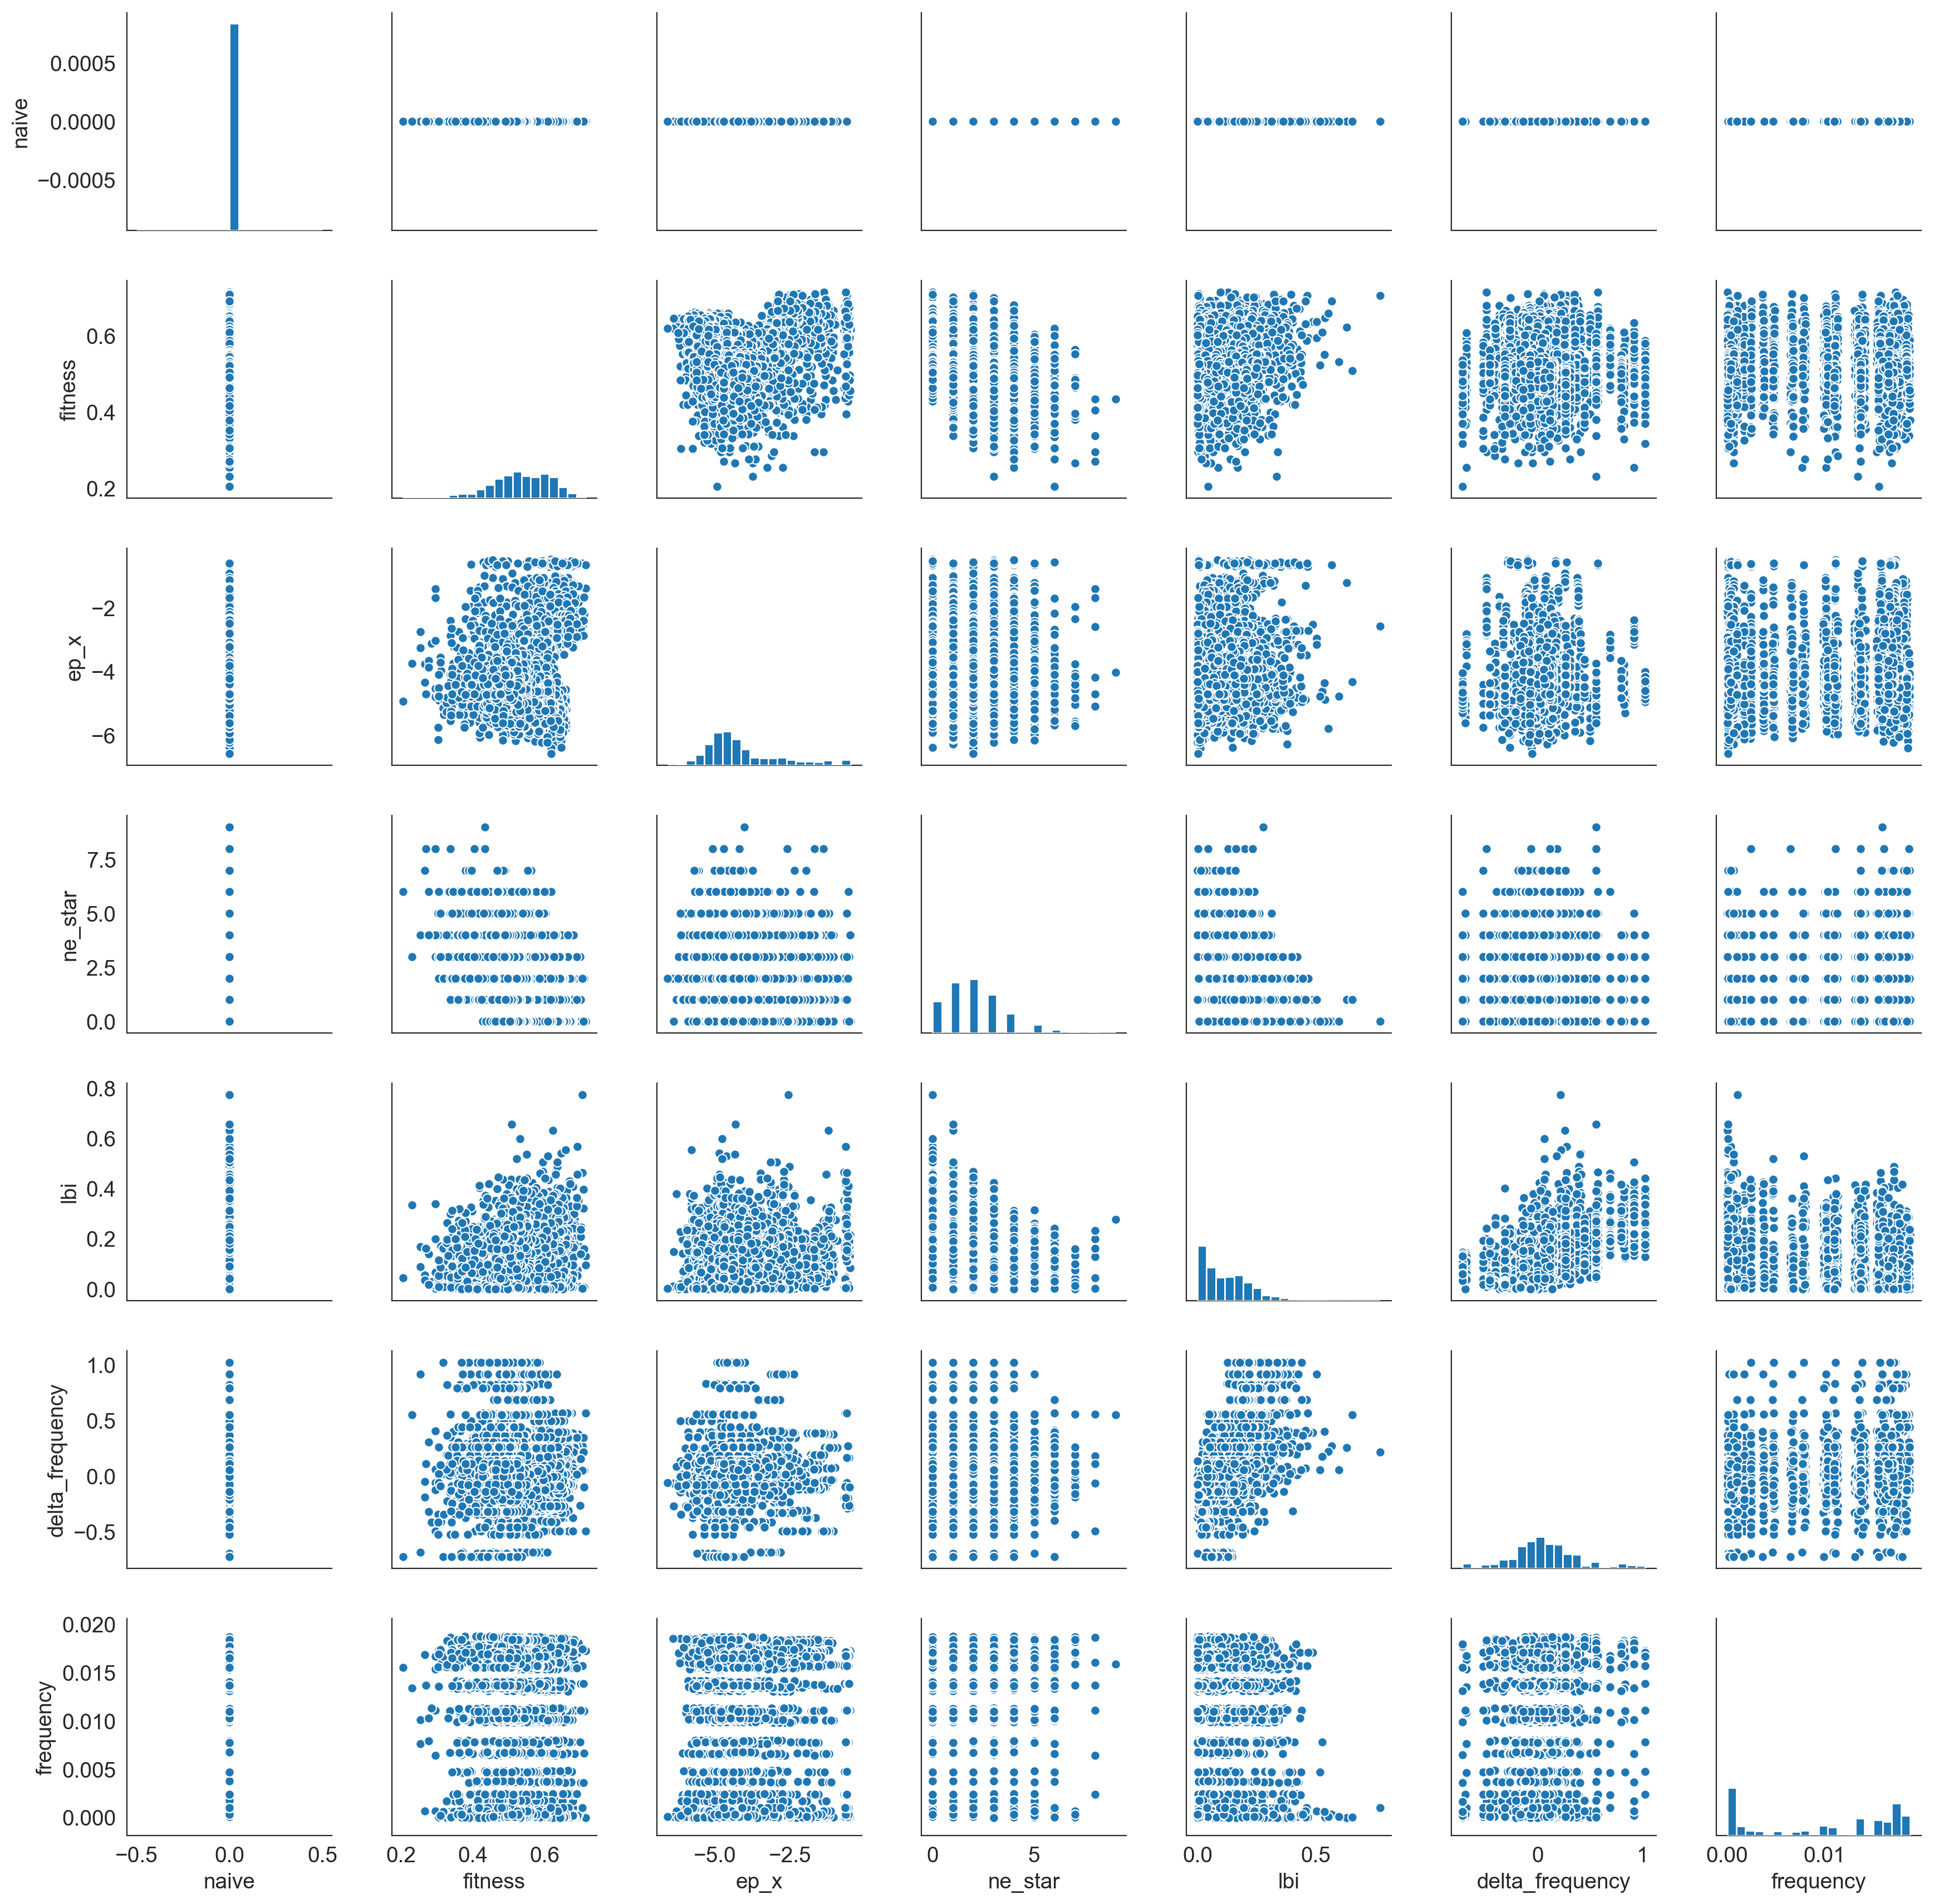

In [40]:
variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]
sns.pairplot(tip_attributes_df.dropna(), vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})

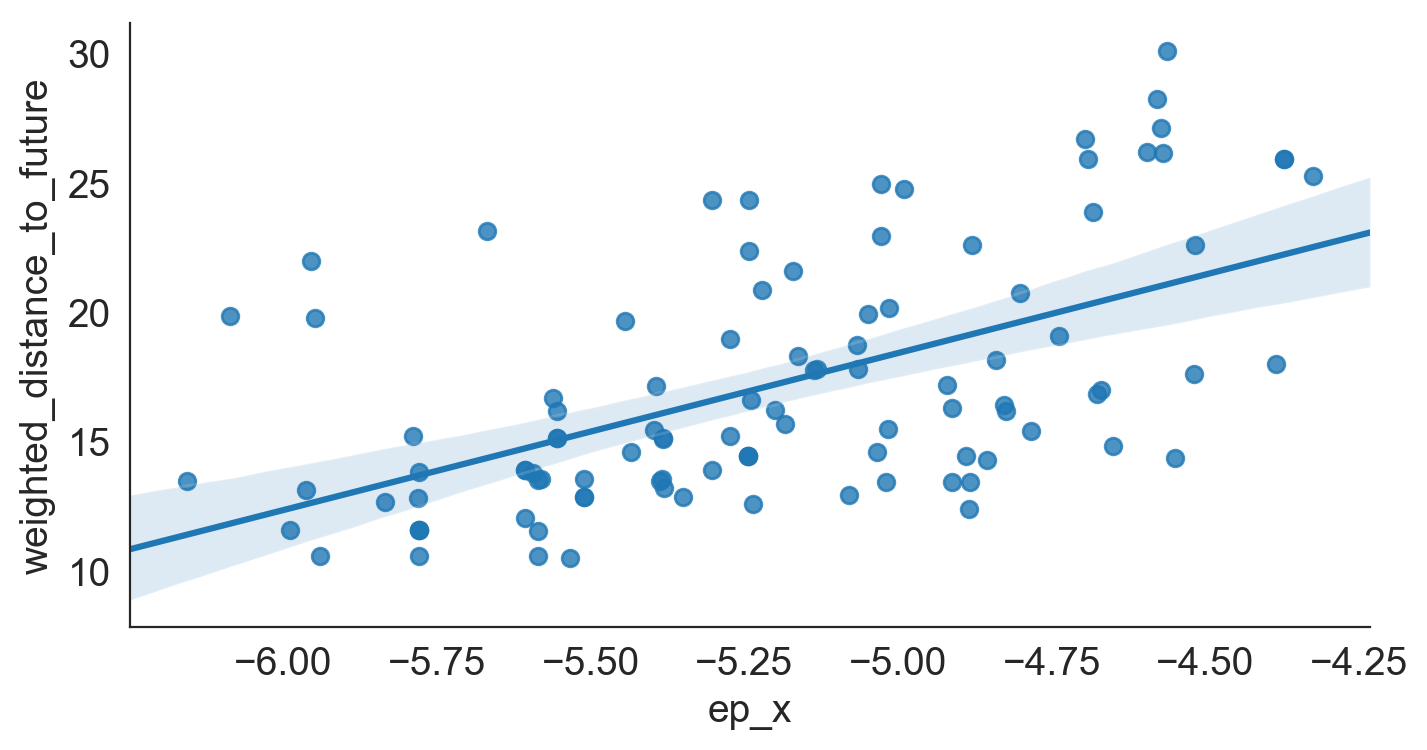

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.regplot(
    "ep_x",
    "weighted_distance_to_future",
    tip_attributes_df.loc[tip_attributes_df["timepoint"] == "2020-10-01"],
    ax=ax
)

In [42]:
"""sns.lmplot(
    "ep_x",
    "weighted_distance_to_future",
    tip_attributes_df,
    col="timepoint",
    col_wrap=4,
    sharex=False,
    sharey=False
)"""

'sns.lmplot(\n    "ep_x",\n    "weighted_distance_to_future",\n    tip_attributes_df,\n    col="timepoint",\n    col_wrap=4,\n    sharex=False,\n    sharey=False\n)'

## Summarize model residuals
[back to top](#Summarize-models)

In [43]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [44]:
residuals_by_timepoint.head()

predictors  timepoint     residual
0  delta_frequency 2011-10-01   348.974797
1  delta_frequency 2012-04-01    82.627850
2  delta_frequency 2012-10-01   946.940525
3  delta_frequency 2013-04-01   757.598023
4  delta_frequency 2013-10-01  1466.539751

In [45]:
max_lags = 18

### Residuals by predictor

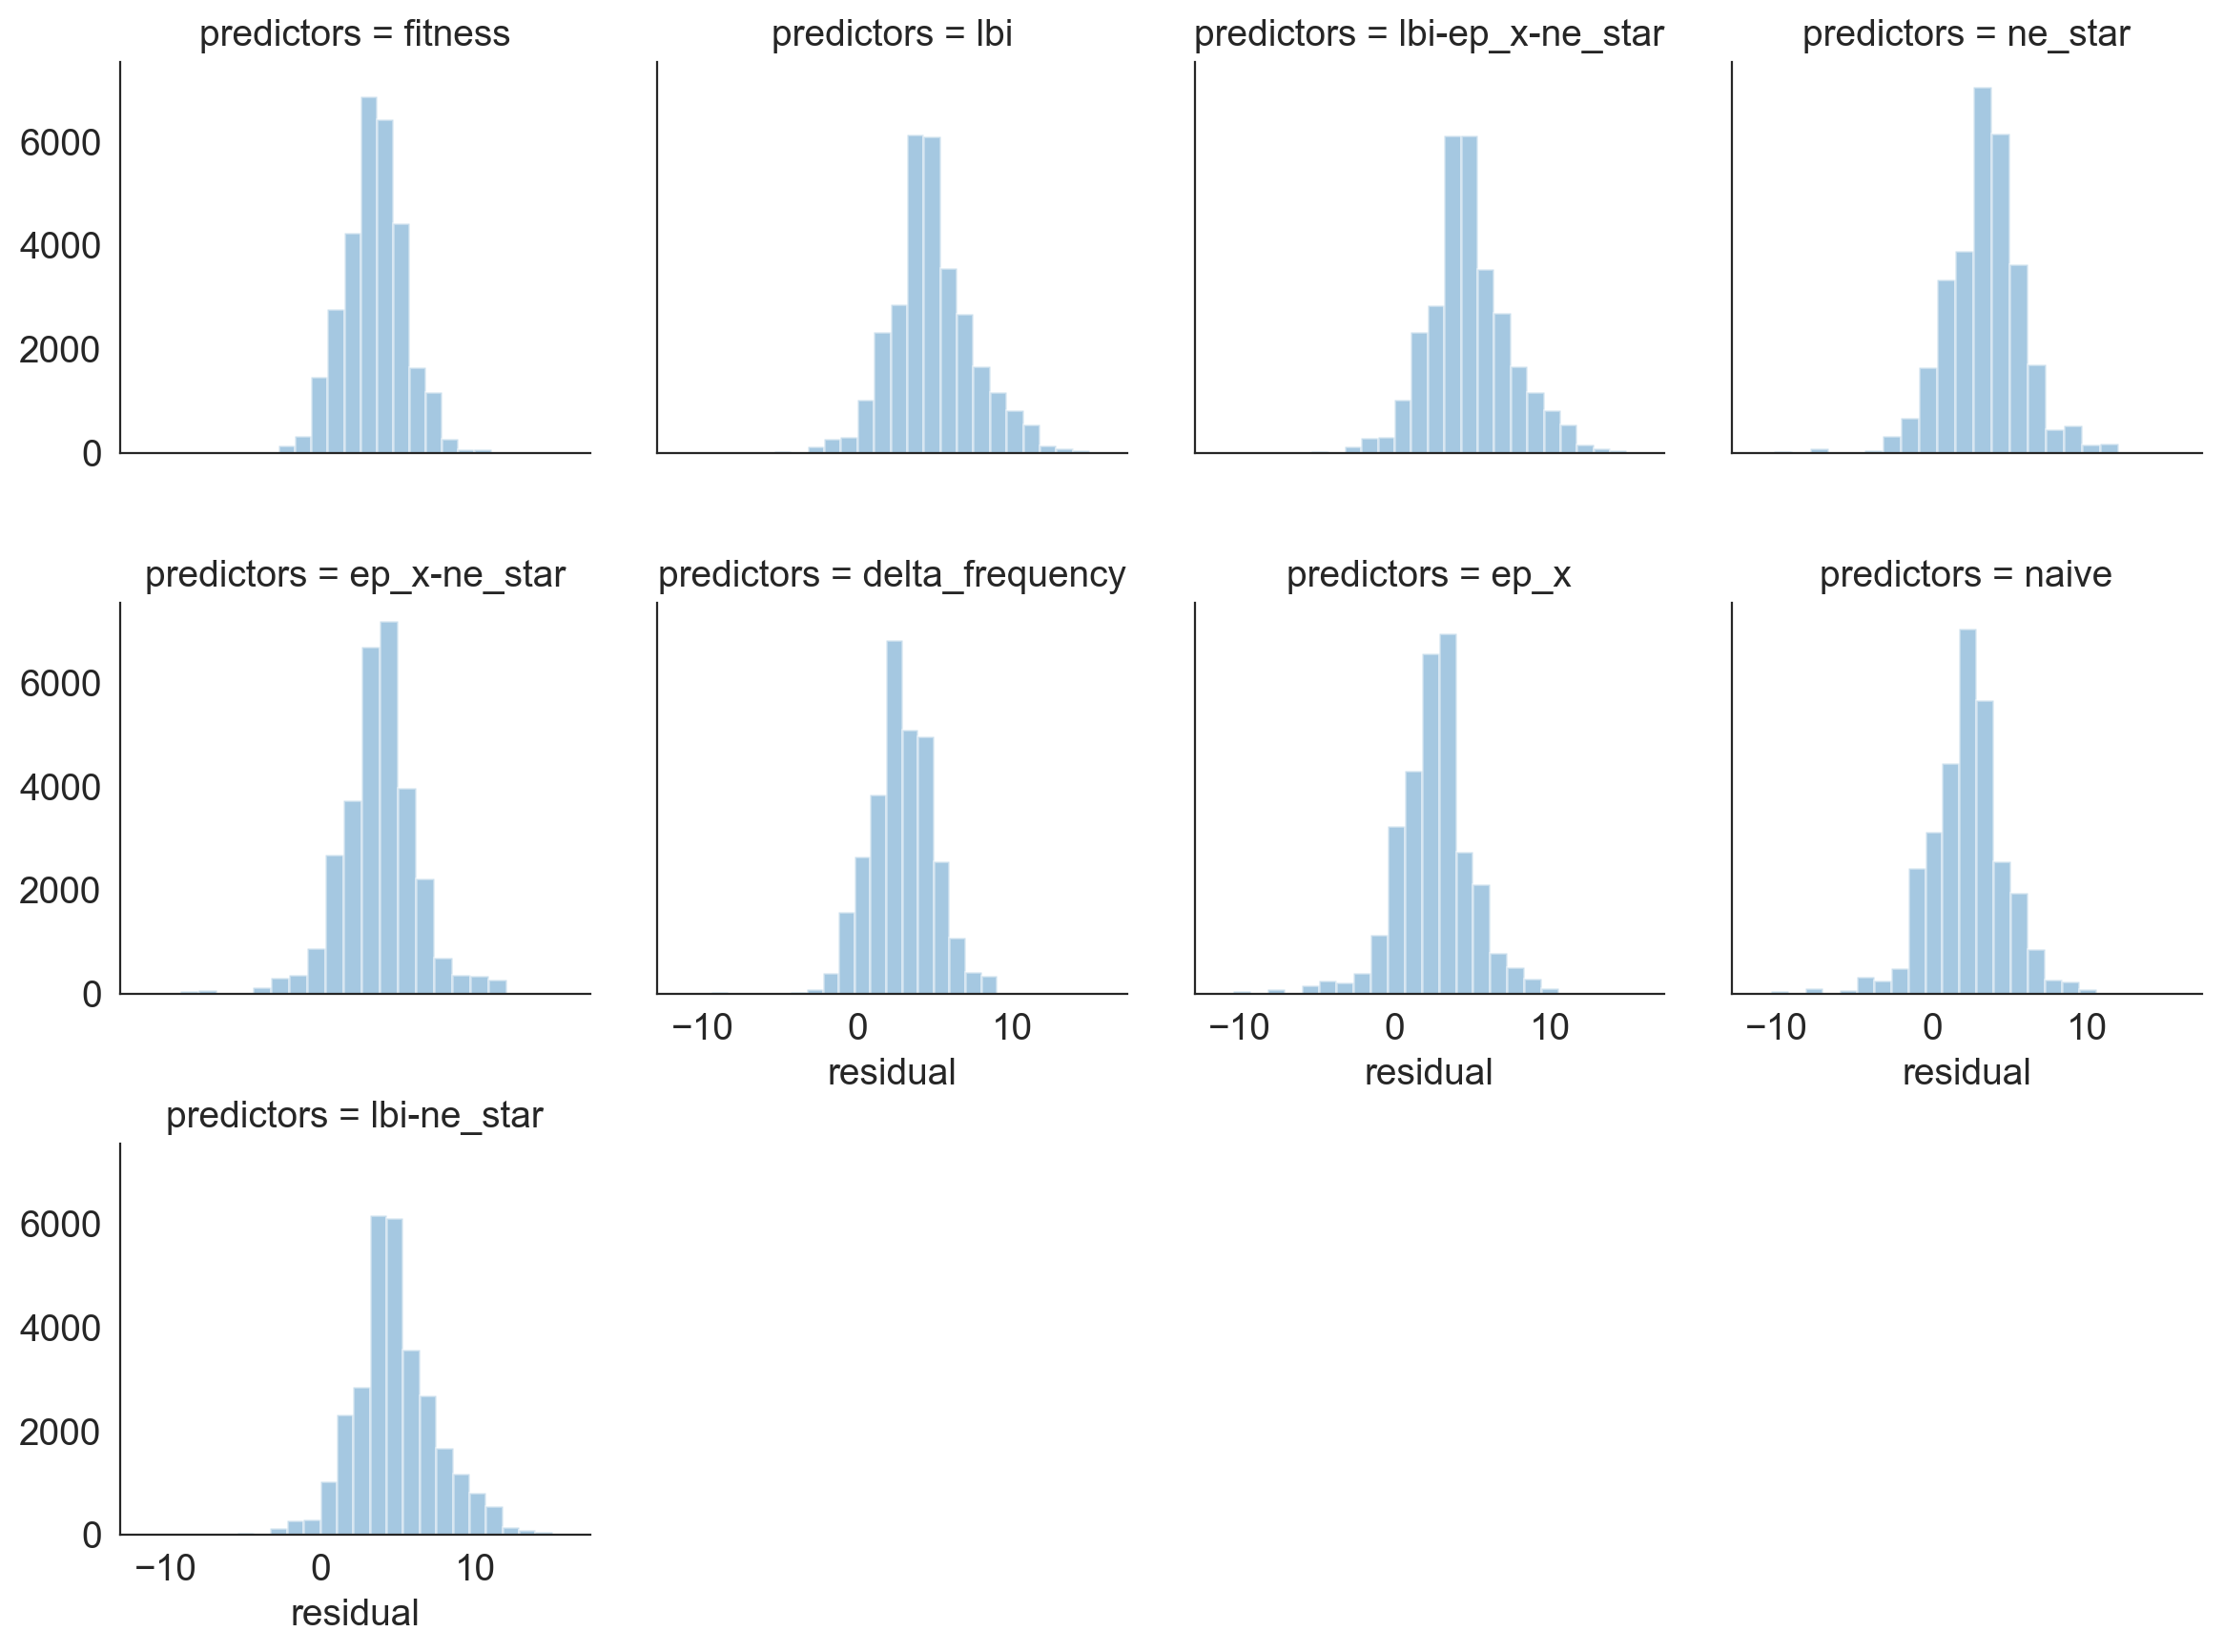

In [46]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=20, kde=False)

In [47]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
naive               2.410738
ep_x                2.607937
delta_frequency     2.791816
ne_star             3.472755
fitness             3.501408
ep_x-ne_star        3.838714
lbi                 4.469992
lbi-ne_star         4.470570
lbi-ep_x-ne_star    4.472098
Name: residual, dtype: float64

In [48]:
residual_df.groupby("predictors")["residual"].count()

predictors
delta_frequency     30093
ep_x                30093
ep_x-ne_star        30093
fitness             30093
lbi                 30093
lbi-ep_x-ne_star    30093
lbi-ne_star         30093
naive               30093
ne_star             30093
Name: residual, dtype: int64

In [49]:
(residual_df["residual"] < -0.01).sum()

18513

### Residuals by timepoint

In [50]:
residuals_by_timepoint.head()

predictors  timepoint     residual
0  delta_frequency 2011-10-01   348.974797
1  delta_frequency 2012-04-01    82.627850
2  delta_frequency 2012-10-01   946.940525
3  delta_frequency 2013-04-01   757.598023
4  delta_frequency 2013-10-01  1466.539751

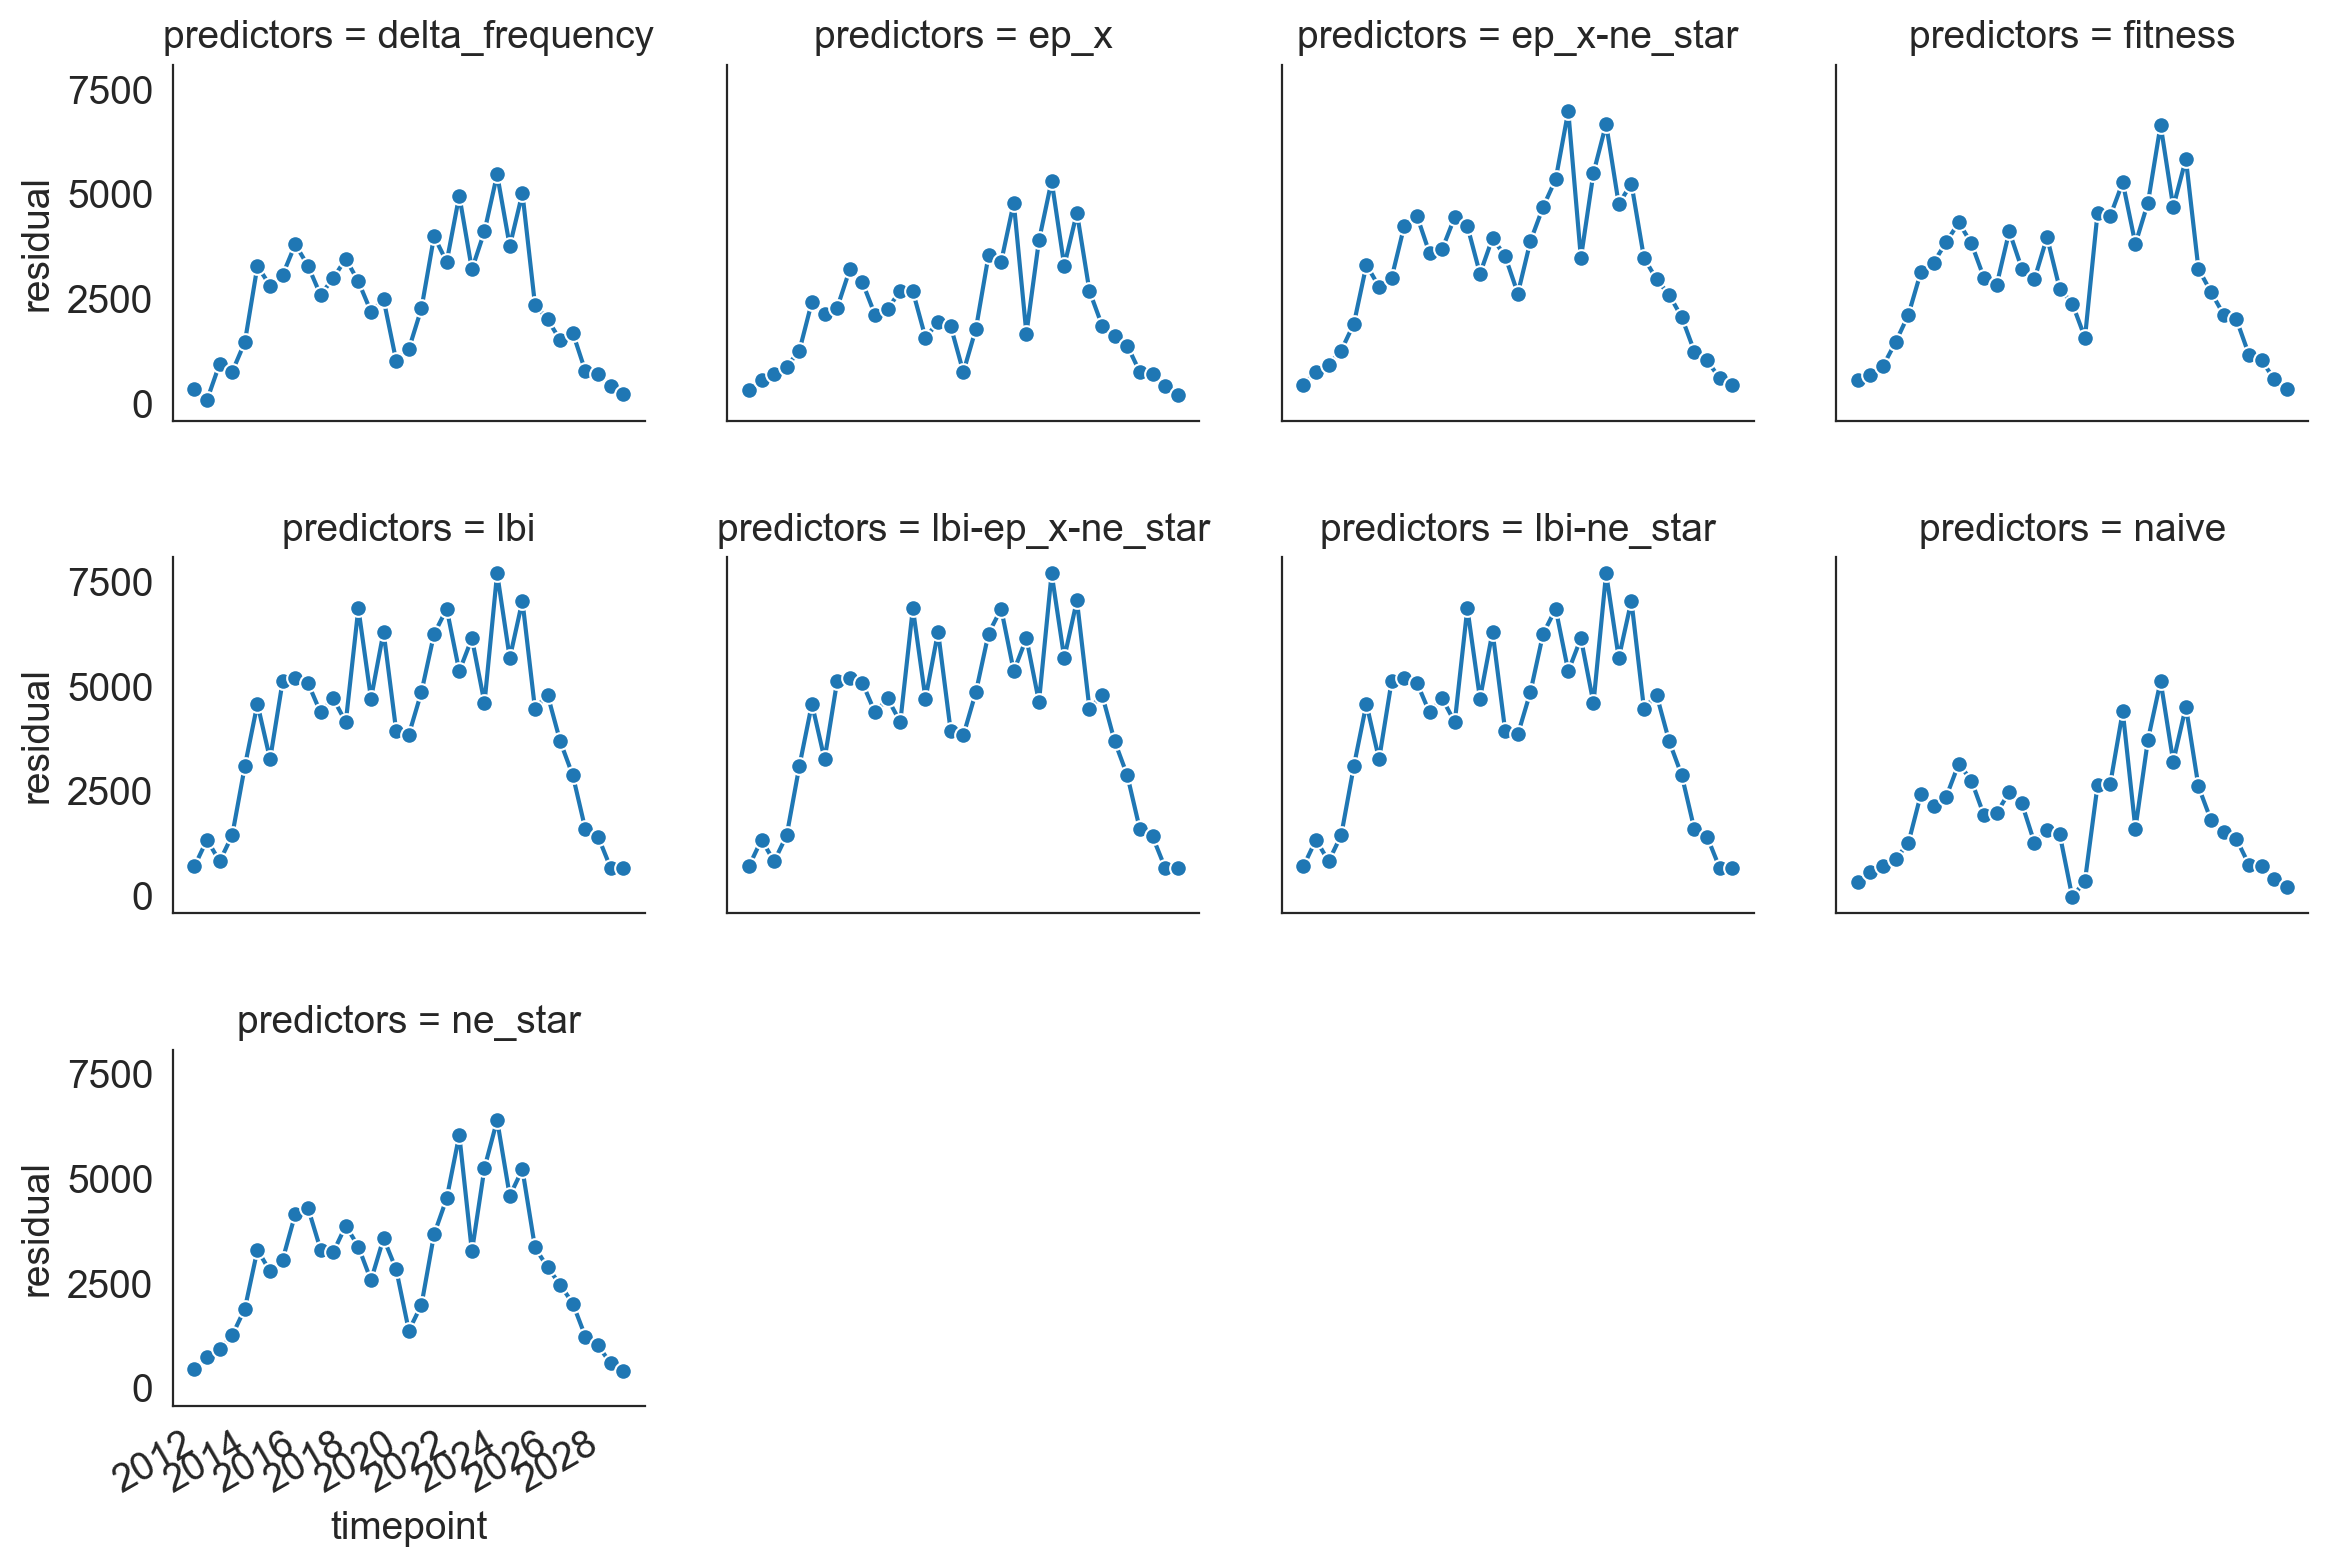

In [51]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [52]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([ 369.74502488,  779.19202071,  111.90351724,  569.32419145,
       1839.79616628, 2157.74742534, 1114.06938018, 2767.30079554,
       2048.32465124, 2334.00701247, 2458.65274069, 2741.53725643,
       1671.53404016, 4660.93958615, 3447.60660916, 4745.56393496,
       2462.97393628, 3888.92673542, 4511.70592208, 3615.99618516,
       4190.82856095,  961.01337145, 4545.83393031,  873.03078471,
       2575.24837681, 2475.08320564, 2526.08269909, 1856.79035183,
       2999.8818868 , 2157.7465634 , 1515.58679787,  838.205865  ,
        715.36654973,  253.75285717,  449.64237384])

### Autocorrelation of residuals

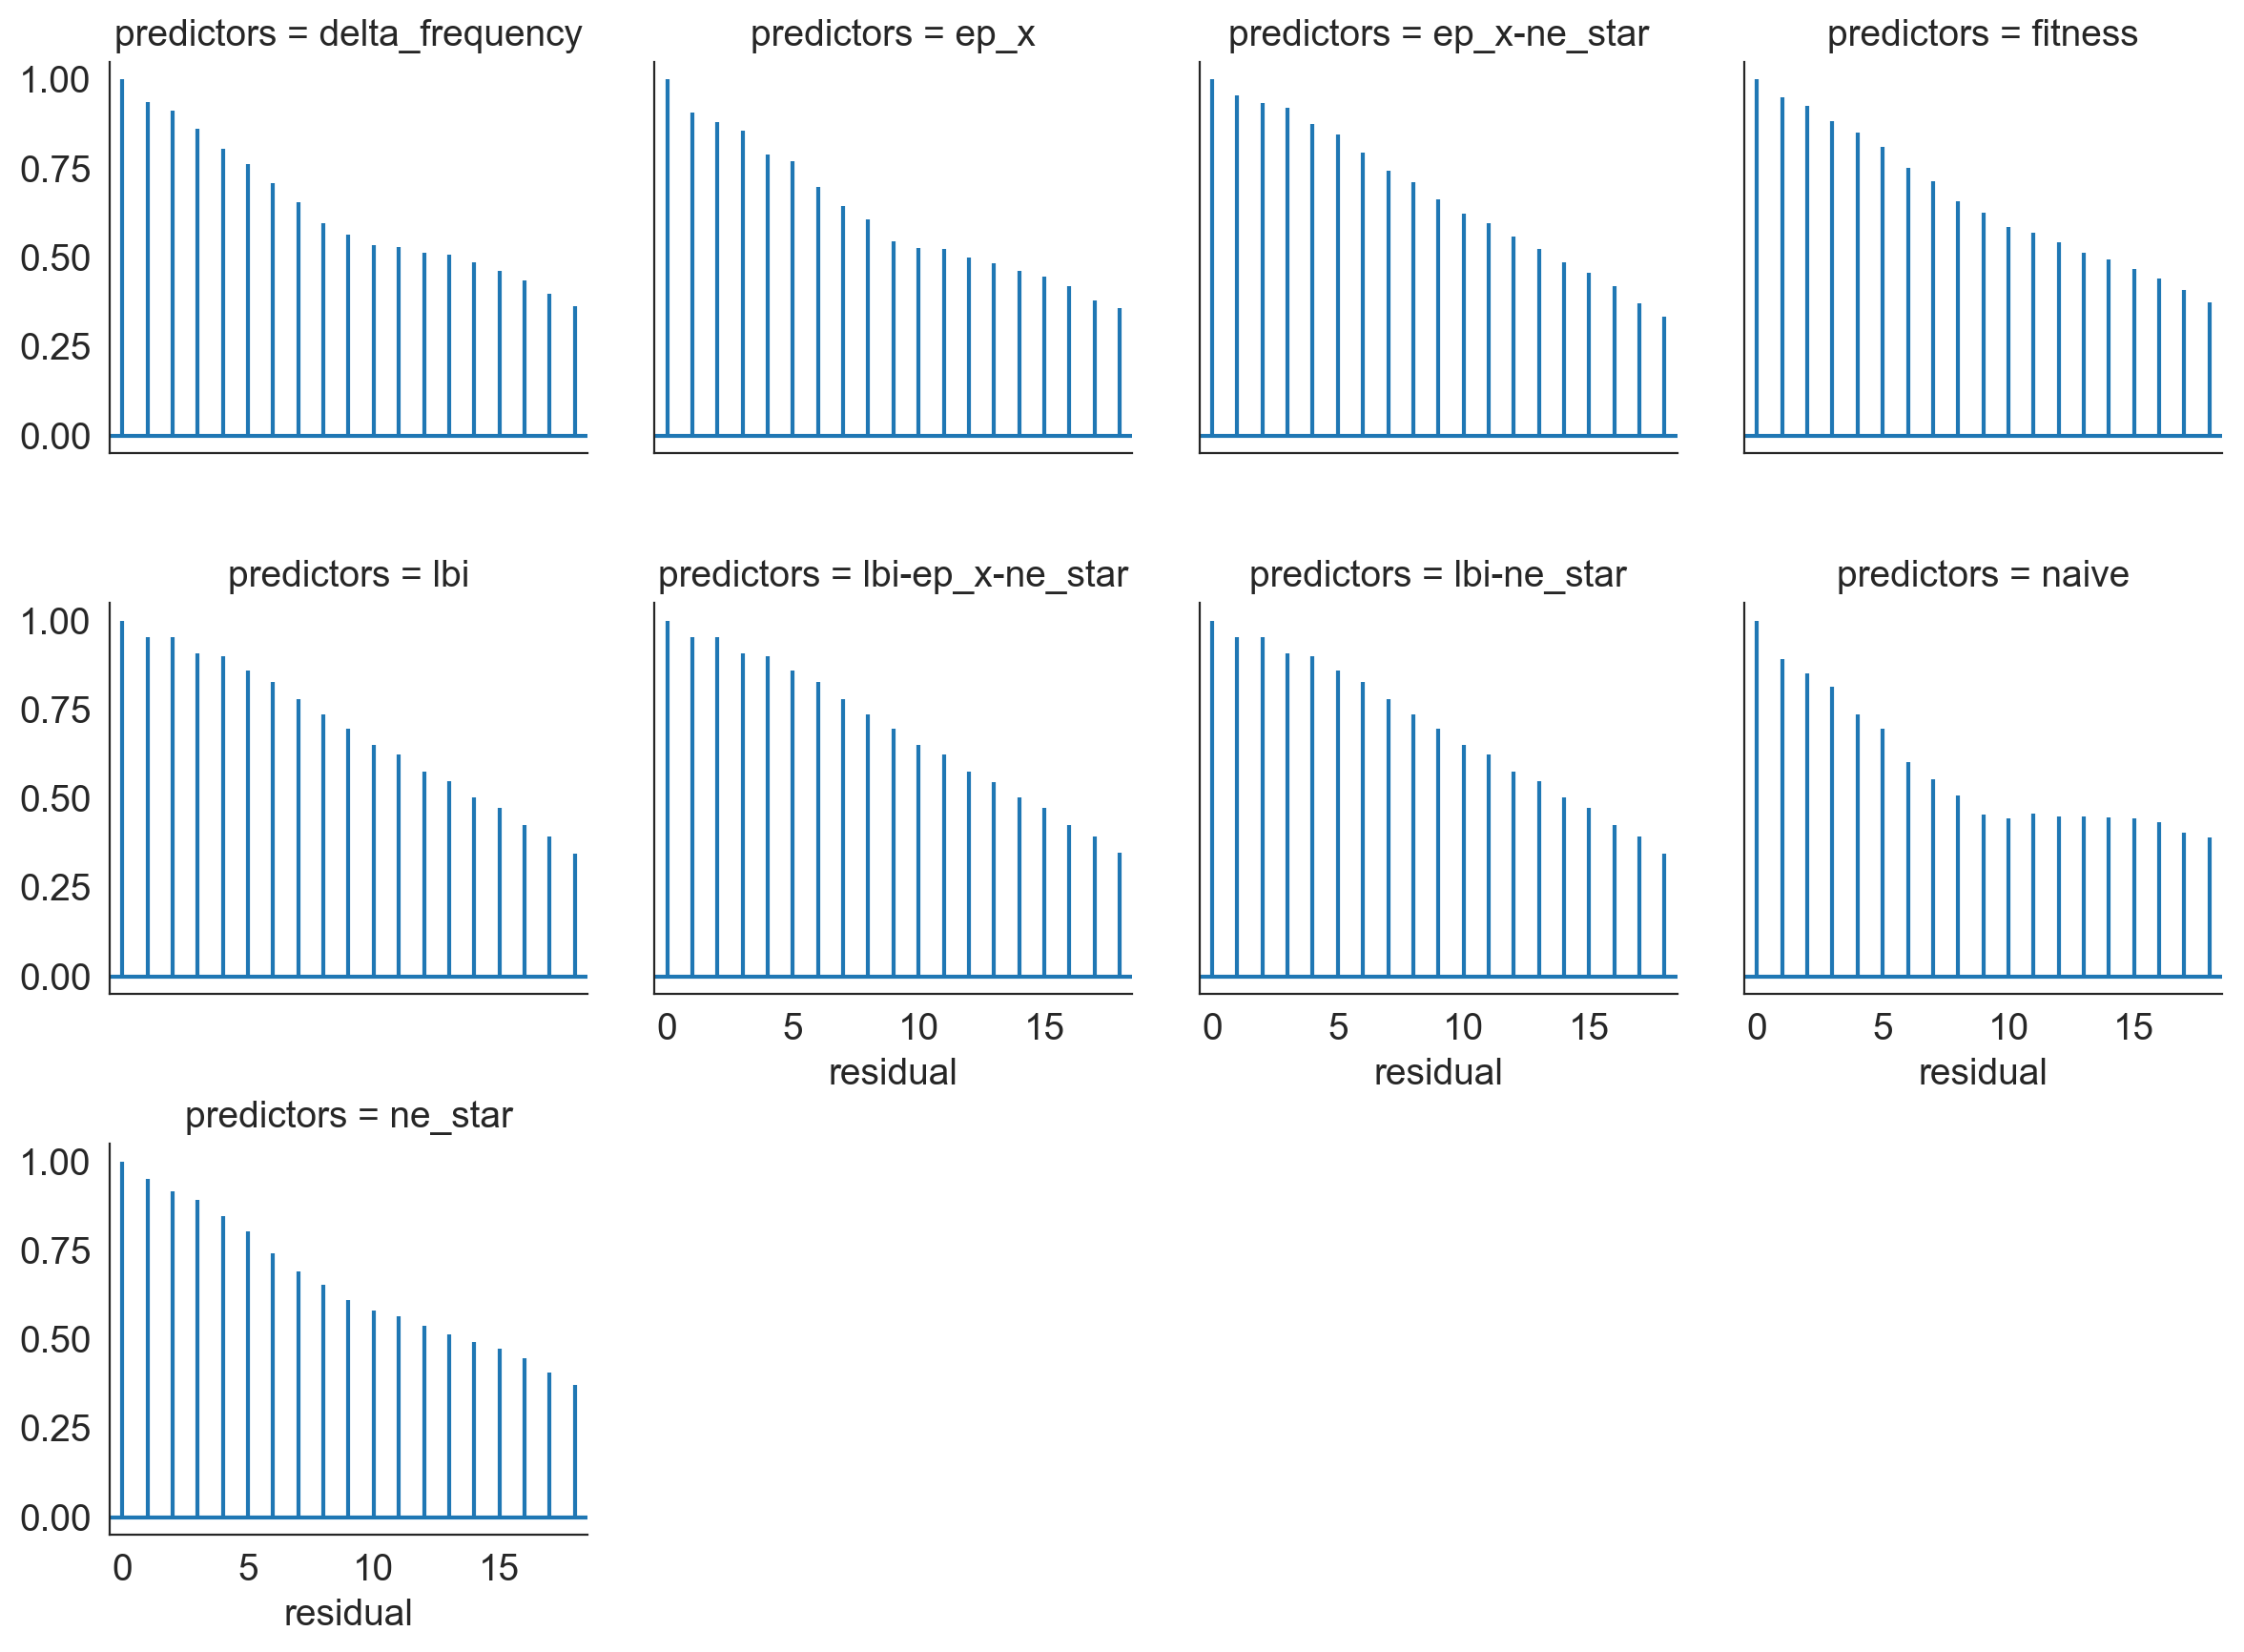

In [53]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted distances
[back to top](#Summarize-models)

$$
d_{i}(x(t)) = \sum_{j}x_{j}d_{ij}
$$

$$
u = t + \Delta{t}
$$

$$
\hat{x}_{i}(t, u) = x_{i}(t)e^{(f_{i}(t)(u - t))}
$$

$$
y = d_{i}(x(u))
$$

$$
\hat{y} = d_{i}(\hat{x}(t, u))
$$

$$
D(x(t), x(u)) = \sum_{i}x_{i}d_{i}(u)
$$

$$
D(\hat{x}(t, u), x(u)) = \sum_{i}x_{i}e^{(f_{i}(t)(u - t))}d_{i}(u)
$$

$$
L = \sum_{t}D(\hat{x}(t, u), x(u))
$$

In [54]:
frequency_df["observed_rank"] = frequency_df["y"] # / frequency_df["frequency"]
frequency_df["estimated_rank"] = frequency_df["y_hat"] # / frequency_df["frequency"]

In [55]:
regressions = []
for predictors, group_df in frequency_df.groupby(["predictors"]):
    slope, intercept, r_value, p_value, std_err = linregress(
        group_df["y"],
        group_df["y_hat"]
    )
    
    regressions.append({
        "predictors": predictors,
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "r_2": r_value ** 2,
        "p_value": p_value
    })

regressions = pd.DataFrame(regressions).sort_values(by="r_2", ascending=False)

In [56]:
regressions_order = regressions["predictors"].values

In [57]:
regressions_order

array(['fitness', 'ne_star', 'delta_frequency', 'naive', 'lbi-ne_star',
       'lbi-ep_x-ne_star', 'lbi', 'ep_x-ne_star', 'ep_x'], dtype=object)

In [58]:
max_y = max(frequency_df["y"].max() + frequency_df["y"].std(), frequency_df["y_hat"].max() + frequency_df["y_hat"].std())

In [59]:
data_to_plot = frequency_df[frequency_df["predictors"] == "lbi"]

In [60]:
minimum_observed_distance = data_to_plot.groupby("validation_timepoint")["observed_rank"].min().reset_index()

In [61]:
minimum_estimated_distance = data_to_plot.groupby("validation_timepoint")["estimated_rank"].min().reset_index()

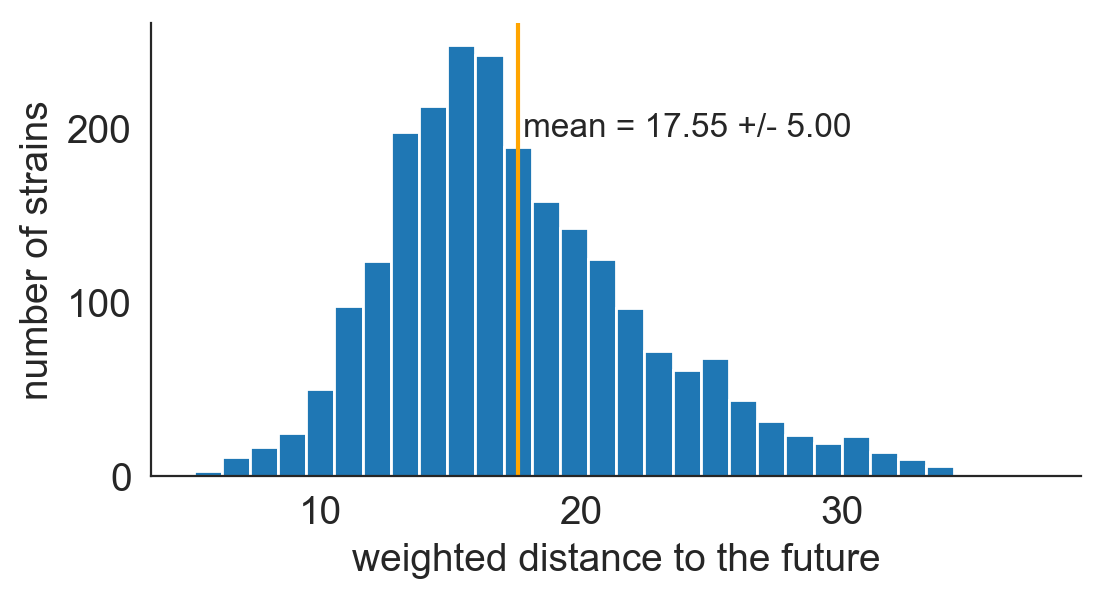

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(frequency_df[frequency_df["predictors"] == "naive"]["y"], bins=30)
ax.set_xlabel("weighted distance to the future")
ax.set_ylabel("number of strains")

mean_y = frequency_df[frequency_df["predictors"] == "naive"]["y"].mean()
std_y = frequency_df[frequency_df["predictors"] == "naive"]["y"].std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.4,
    0.75,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.savefig("../manuscript/figures/weighted-distance-between-timepoints.png")

In [63]:
best_overall_error_record = overall_errors_df.sort_values("cv_error_mean").values[0]
best_overall_error = best_overall_error_record[0]
best_overall_error_model = best_overall_error_record[-1]

Text(0.01,0.75,'best mean = 12.96')

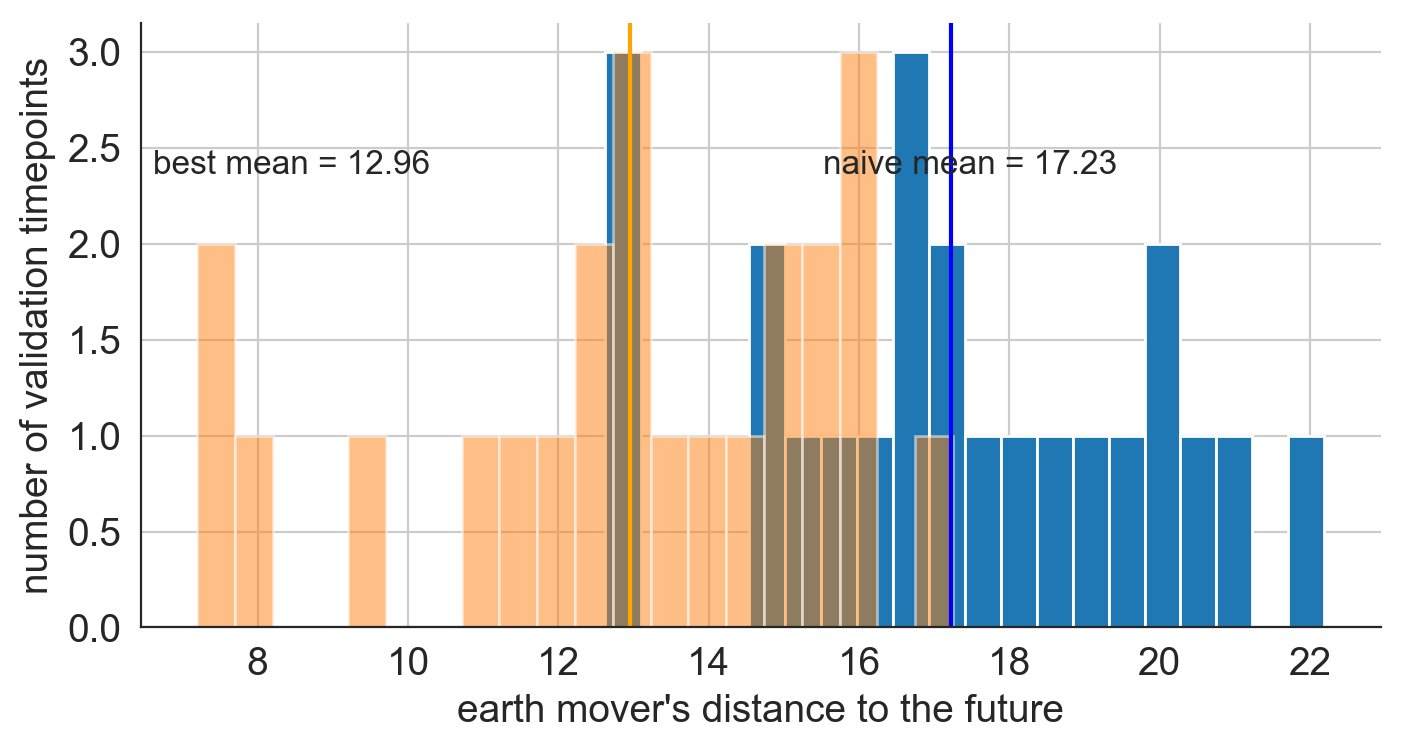

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].hist(bins=20, ax=ax)
ax.set_xlabel("earth mover's distance to the future")
ax.set_ylabel("number of validation timepoints")

mean_y = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].mean()
ax.axvline(
    x=mean_y,
    color="blue"
)

ax.text(
    0.55,
    0.75,
    "naive mean = %.2f" % (mean_y,),
    transform=ax.transAxes,
    fontsize=12
)

errors_by_time_df[errors_by_time_df["predictors"] == best_overall_error_model]["validation_error"].hist(
    bins=20,
    ax=ax,
    alpha=0.5
)
ax.axvline(
    x=best_overall_error,
    color="orange"
)
ax.text(
    0.01,
    0.75,
    "best mean = %.2f" % (best_overall_error,),
    transform=ax.transAxes,
    fontsize=12
)


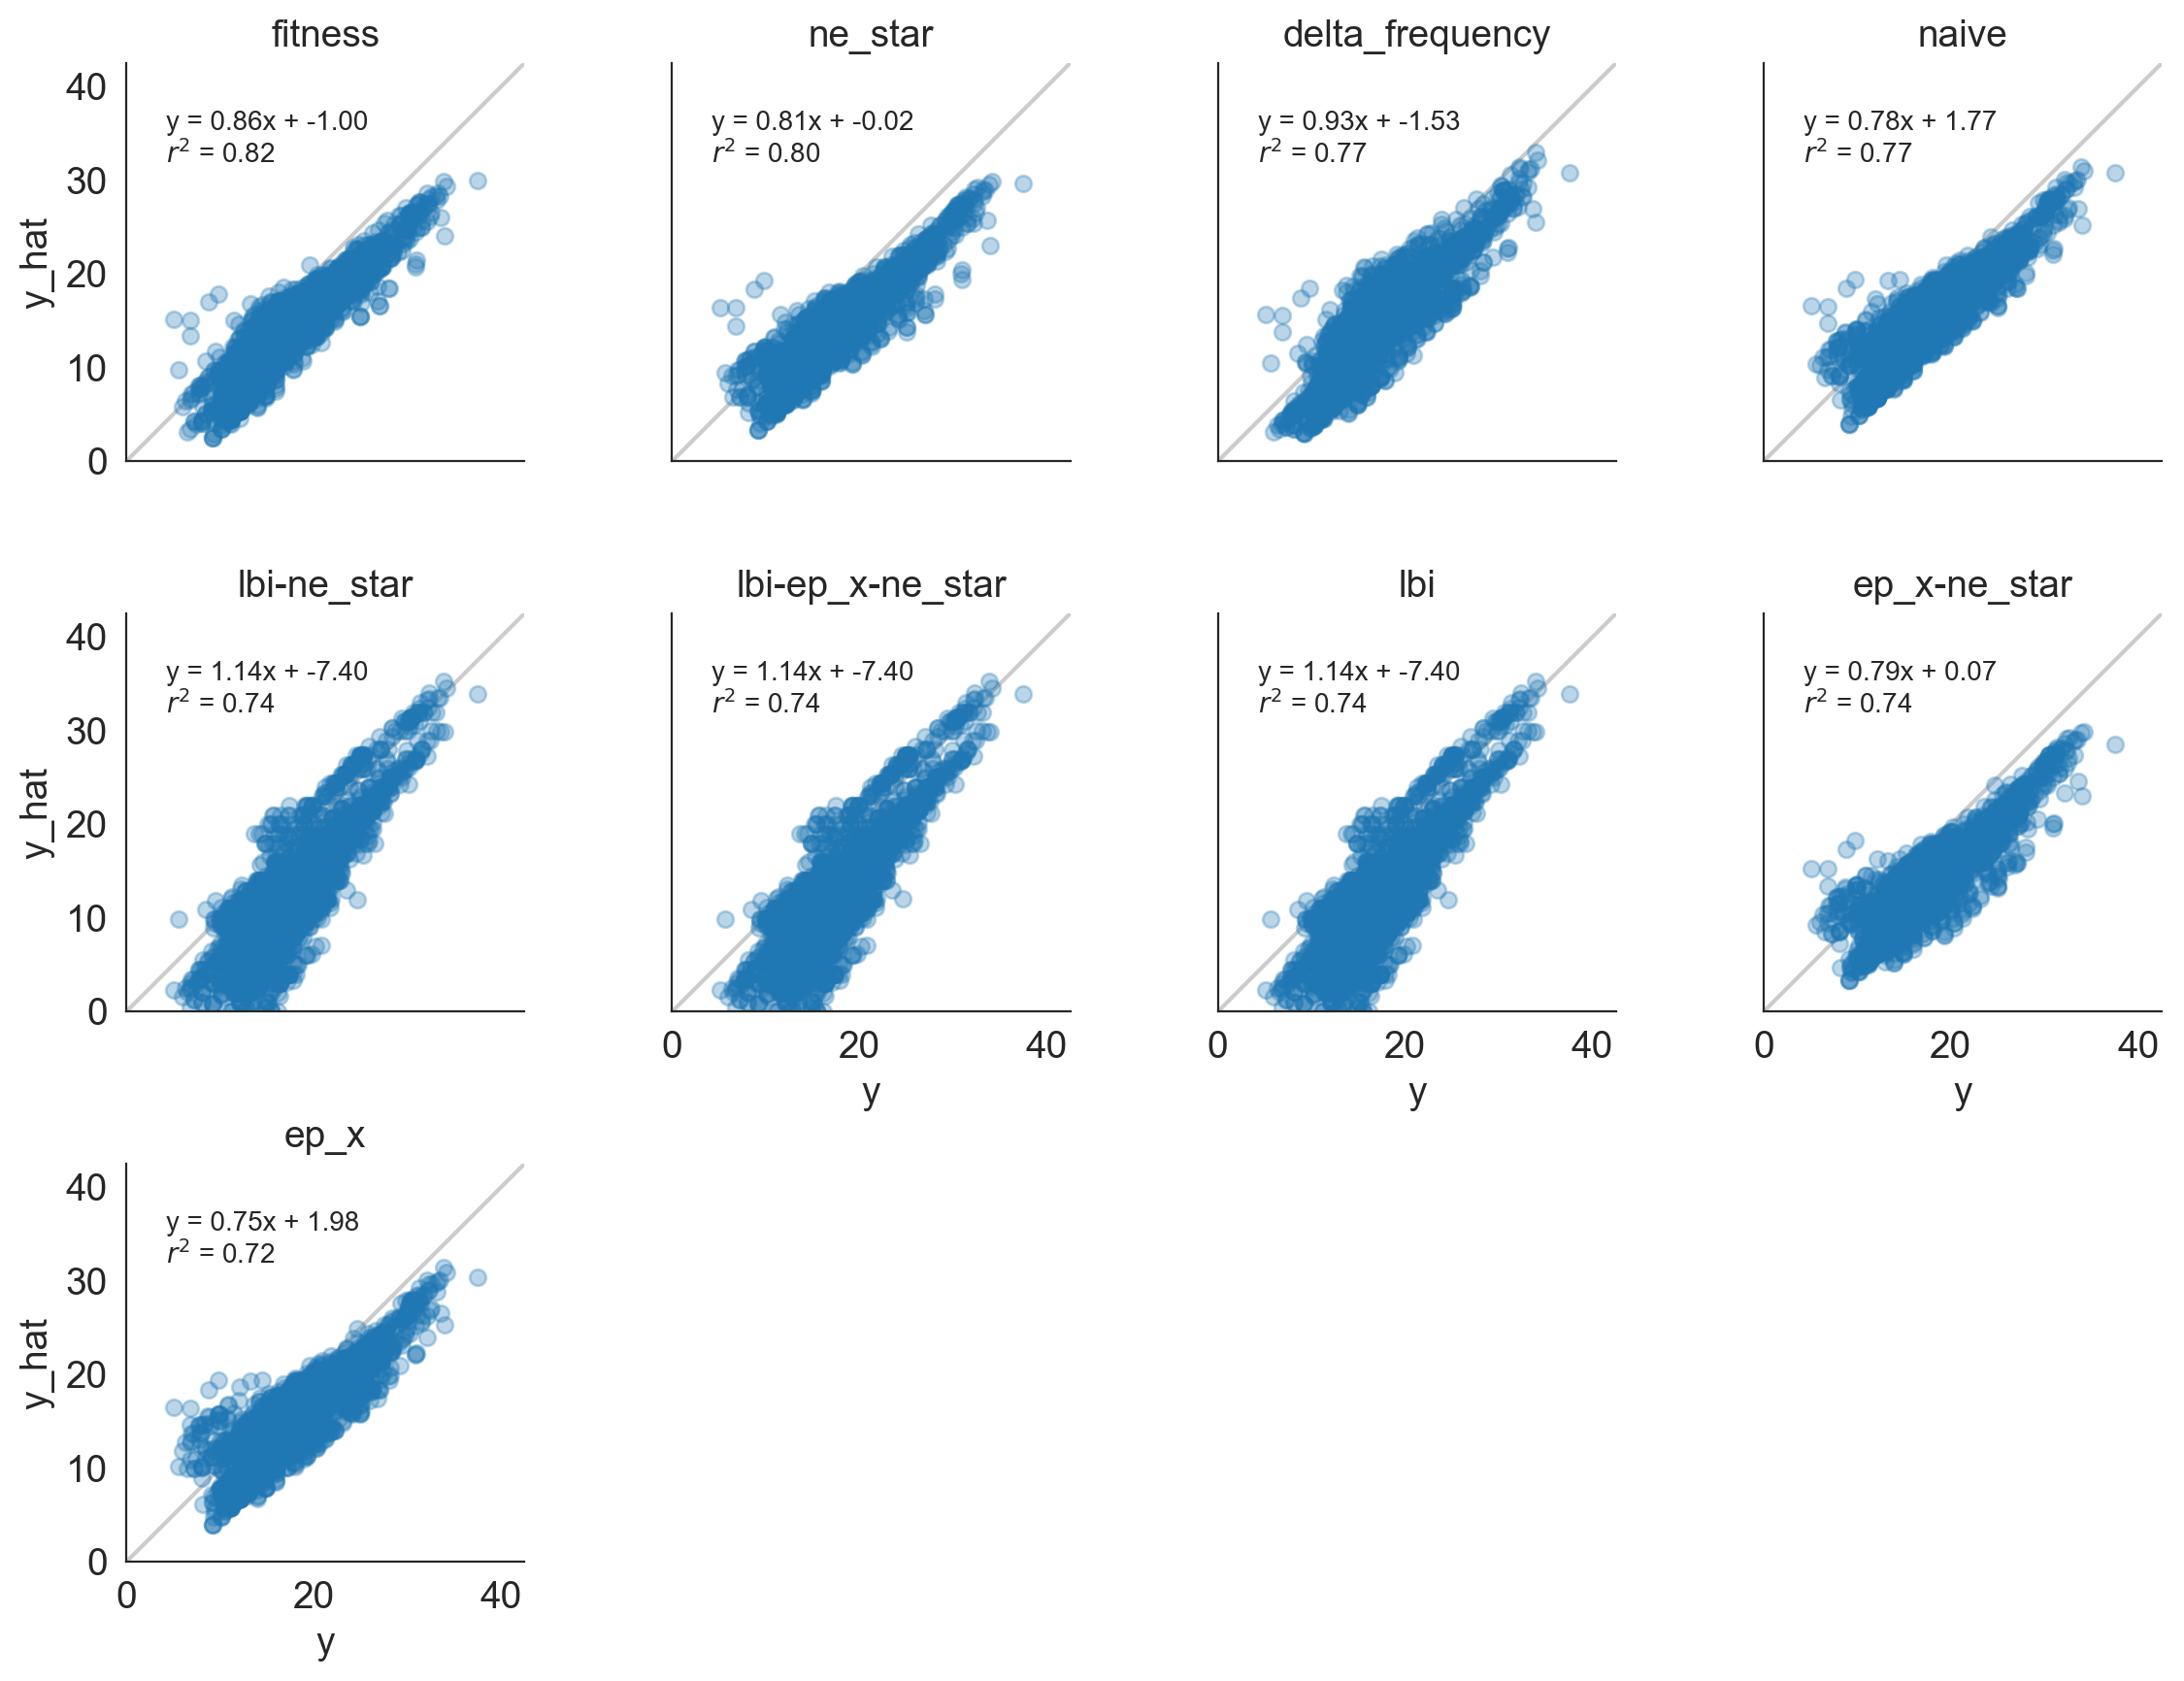

In [65]:
x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4, col_order=regressions_order)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{col_name}")

for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value = regressions.loc[
        regressions["predictors"] == facet_df["predictors"].unique()[0],
        ["slope", "intercept", "r_value", "p_value"]
    ].values[0]
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=10
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)

In [66]:
best_models = list(regressions_order[:3])

In [67]:
if not "naive" in best_models:
    best_models.append("naive")

In [68]:
best_models

['fitness', 'ne_star', 'delta_frequency', 'naive']

In [69]:
frequency_df["year_month"] = frequency_df["validation_timepoint"].dt.strftime("%Y-%m")
frequency_df["year"] = frequency_df["validation_timepoint"].dt.strftime("%Y")

In [70]:
"""x = y = np.linspace(0, max_y, 10)

g = sns.FacetGrid(frequency_df[frequency_df["predictors"].isin(minimal_predictor_names_order + ["fitness"])], row="predictors", col="year_month", height=4)
g.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)
g.set_titles("{row_name}, {col_name}")

regressions_by_time = []
for ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):
    slope, intercept, r_value, p_value, std_err = linregress(
        facet_df["y"],
        facet_df["y_hat"]
    )
    
    regressions_by_time.append({
        "predictors": facet_df["predictors"].unique()[0],
        "timepoint": facet_df["timepoint"].unique()[0],
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "p_value": p_value
    })
    
    if p_value > 0.001:
        p_value = "\nP value = %.3f" % p_value
    else:
        p_value = ""
    
    ax.plot(x, y, color="#cccccc", zorder=-10)
    
    ax.text(
        0.1,
        0.75,
        "y = %.2fx + %.2f\n$r^2$ = %.2f%s" % (slope, intercept, r_value ** 2, p_value),
        transform=ax.transAxes,
        fontsize=12
    )
    ax.set_aspect("equal")
    ax.set_xlim(0, max_y)
    ax.set_ylim(0, max_y)
    
plt.tight_layout()
plt.savefig("correlation_by_timepoint.pdf")"""

'x = y = np.linspace(0, max_y, 10)\n\ng = sns.FacetGrid(frequency_df[frequency_df["predictors"].isin(minimal_predictor_names_order + ["fitness"])], row="predictors", col="year_month", height=4)\ng.map(plt.plot, "y", "y_hat", marker="o", linestyle="", alpha=0.3)\ng.set_titles("{row_name}, {col_name}")\n\nregressions_by_time = []\nfor ((i, j, k), facet_df), ax in zip(g.facet_data(), g.axes.flat):\n    slope, intercept, r_value, p_value, std_err = linregress(\n        facet_df["y"],\n        facet_df["y_hat"]\n    )\n    \n    regressions_by_time.append({\n        "predictors": facet_df["predictors"].unique()[0],\n        "timepoint": facet_df["timepoint"].unique()[0],\n        "slope": slope,\n        "intercept": intercept,\n        "r_value": r_value,\n        "p_value": p_value\n    })\n    \n    if p_value > 0.001:\n        p_value = "\nP value = %.3f" % p_value\n    else:\n        p_value = ""\n    \n    ax.plot(x, y, color="#cccccc", zorder=-10)\n    \n    ax.text(\n        0.1,\n 

In [71]:
regressions_by_time = []
for (predictors, timepoint), group_df in frequency_df.groupby(["predictors", "timepoint"]):
    slope, intercept, r_value, p_value, std_err = linregress(
        group_df["y"],
        group_df["y_hat"]
    )
    
    regressions_by_time.append({
        "predictors": predictors,
        "timepoint": timepoint,
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "p_value": p_value
    })

regressions_by_time = pd.DataFrame(regressions_by_time)

In [72]:
regressions_by_time.head()

intercept       p_value       predictors   r_value     slope  timepoint
0  -3.659025  4.343354e-53  delta_frequency  0.951705  1.127359 2018-10-01
1  -2.452756  6.905288e-74  delta_frequency  0.981737  1.033276 2019-04-01
2   6.182125  1.127037e-26  delta_frequency  0.828505  0.606650 2019-10-01
3  -2.767154  2.036381e-42  delta_frequency  0.924507  1.091187 2020-04-01
4  -1.894526  1.770955e-79  delta_frequency  0.985399  0.986370 2020-10-01

In [73]:
naive_regressions_by_time = regressions_by_time[regressions_by_time["predictors"] == "naive"]
non_naive_regressions_by_time = regressions_by_time[regressions_by_time["predictors"] != "naive"]

## Summarize model forecasting error
[back to top](#Summarize-models)

### Earth mover's distances

Training and validation errors are reported as [earth mover's distances](https://en.wikipedia.org/wiki/Earth_mover%27s_distance). These values minimize the distance between observed and projected frequencies of tips at each timepoint with Hamming distance between amino acid sequences providing the ground distance between each pair of tips in respective timepoints.

In [74]:
distance_df = errors_by_time_df.groupby("predictors")["validation_error"].aggregate([
    "sum",
    "mean",
    "median"
]).sort_values(by="sum").reset_index()

In [75]:
distance_df

predictors         sum       mean     median
0       lbi-ne_star  298.041415  12.958322  13.199708
1               lbi  298.059711  12.959118  13.199849
2  lbi-ep_x-ne_star  298.067912  12.959474  13.199646
3           fitness  354.851150  15.428311  16.020966
4      ep_x-ne_star  363.656675  15.811160  15.690085
5           ne_star  364.814088  15.861482  16.059307
6   delta_frequency  366.211438  15.922236  15.703233
7             naive  396.269848  17.229124  17.257419
8              ep_x  397.170305  17.268274  17.257419

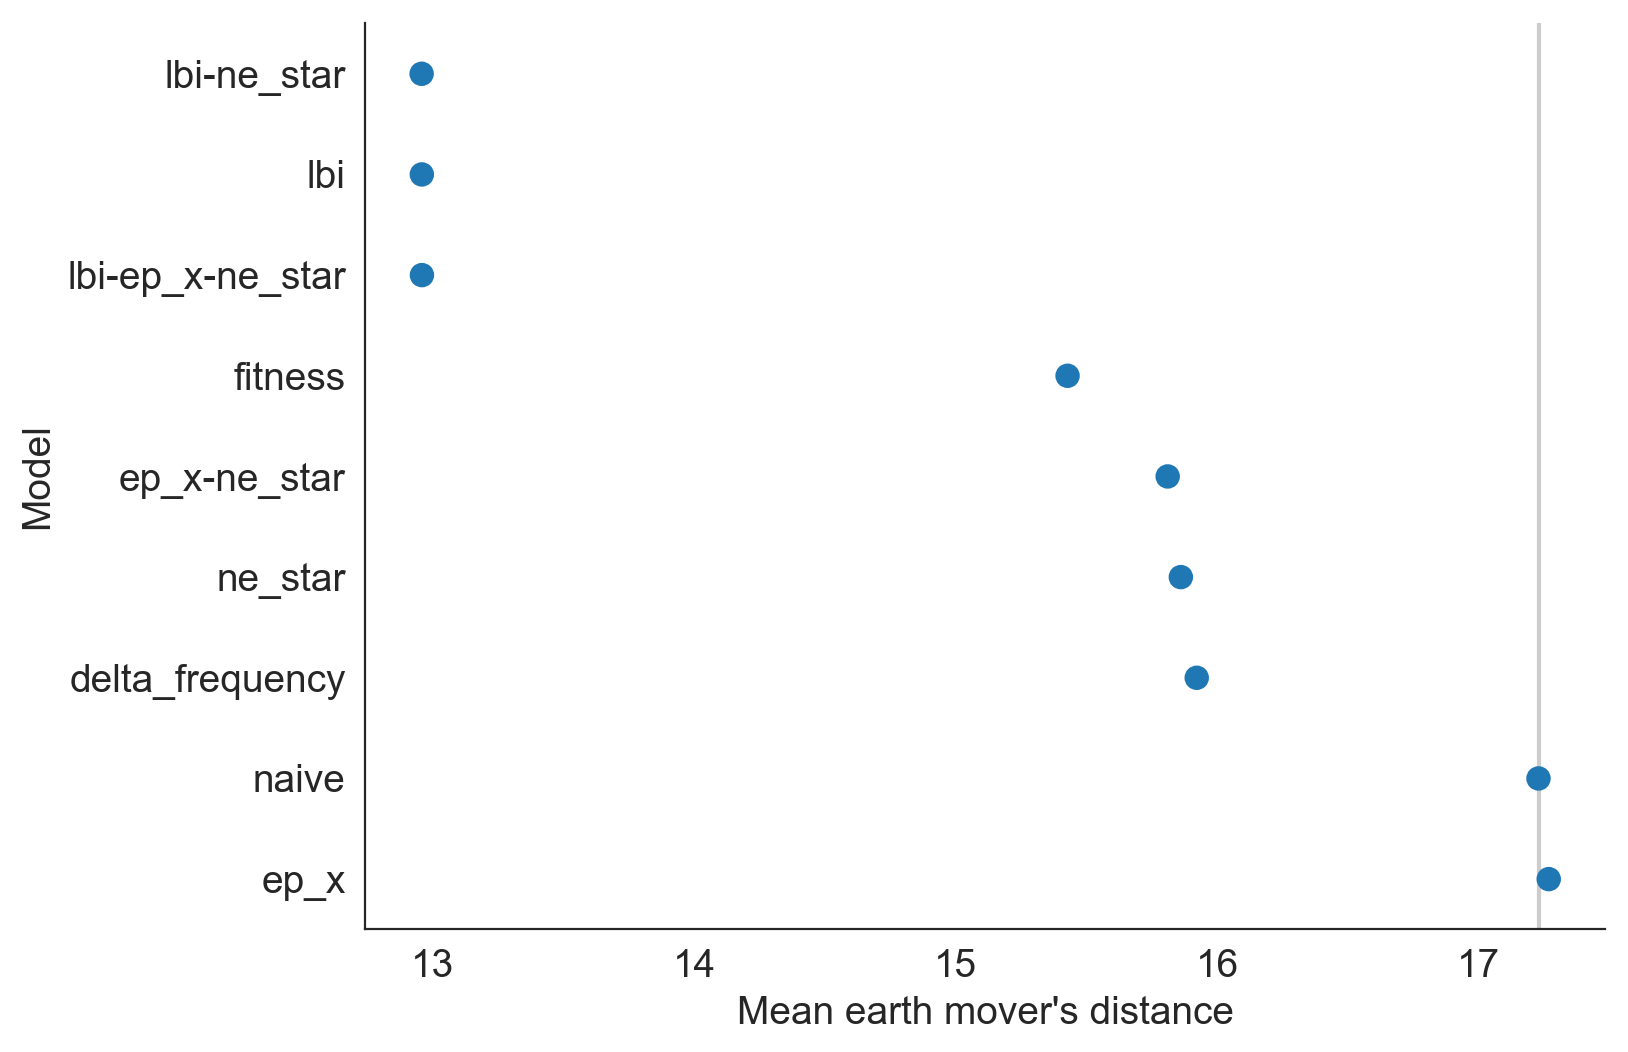

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mean",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax
)

ax.set_xlabel("Mean earth mover's distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "mean"].values[0],
    color="#cccccc",
    zorder=-10
)

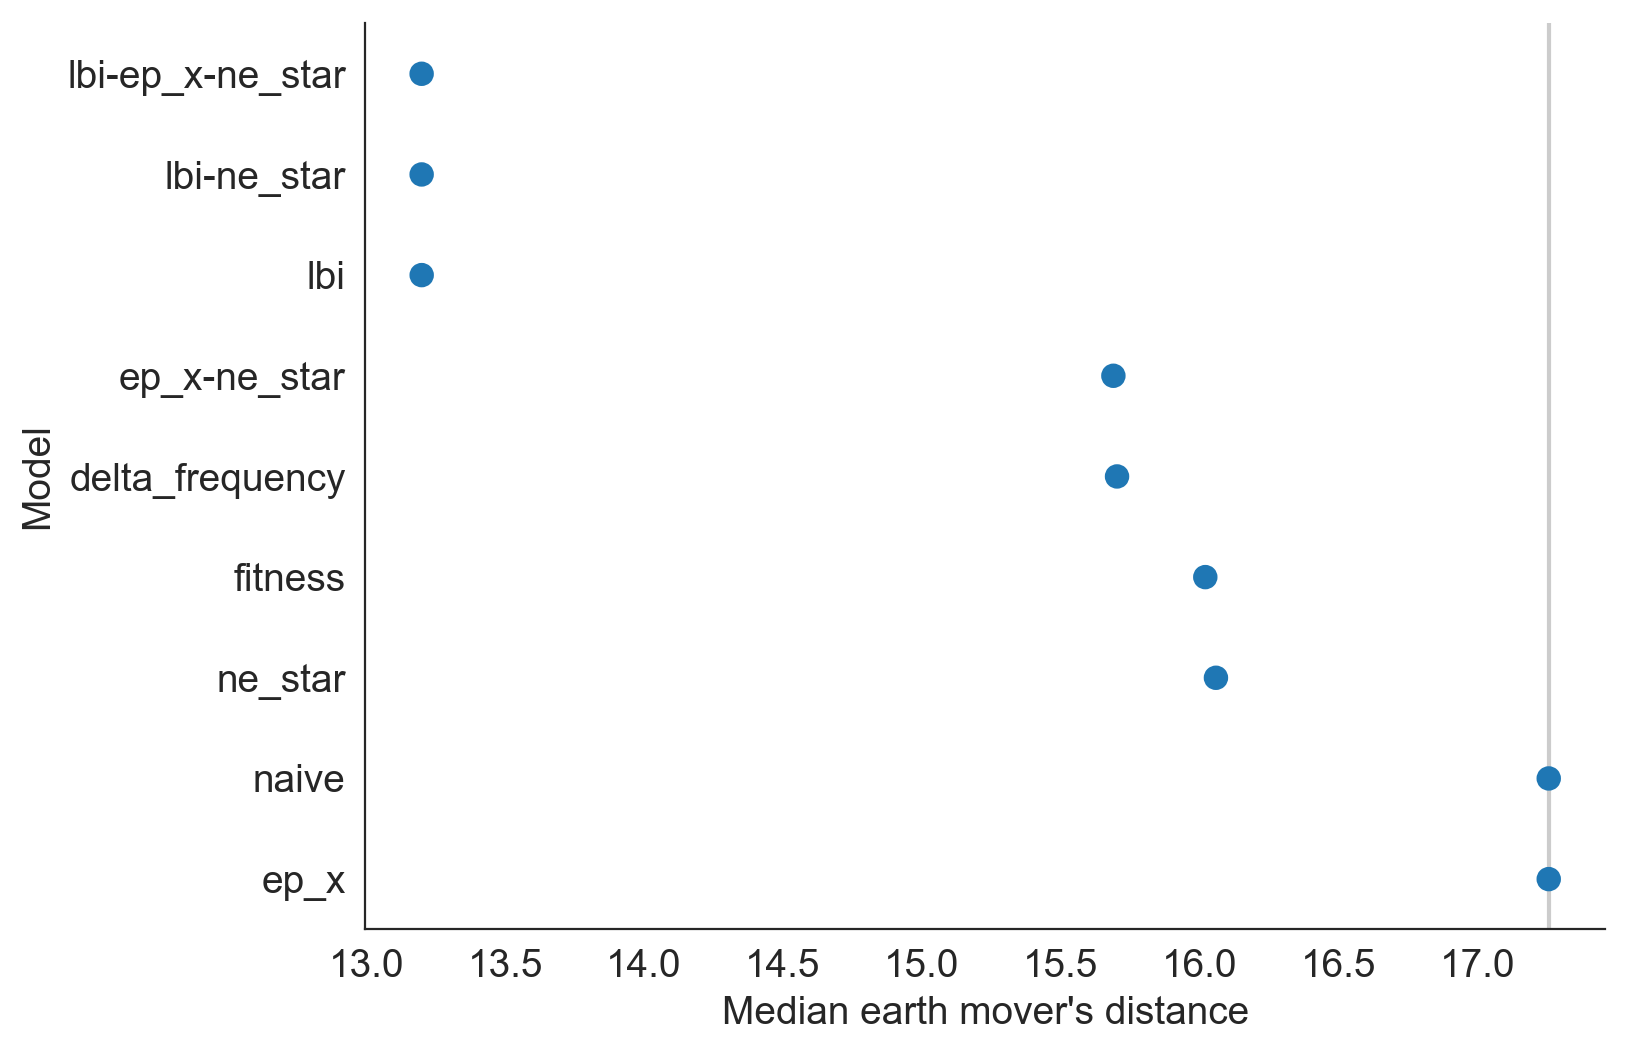

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="median",
    y="predictors",
    data=distance_df,
    join=False,
    ax=ax,
    order=distance_df.sort_values("median").loc[:, "predictors"]
)

ax.set_xlabel("Median earth mover's distance")
ax.set_ylabel("Model")

ax.axvline(
    x=distance_df.loc[distance_df["predictors"] == "naive", "median"].values[0],
    color="#cccccc",
    zorder=-10
)

In [78]:
predictor_type_order = predictor_names_order
predictor_names = predictor_names_order

In [79]:
predictor_name_by_id = dict(zip(predictor_type_order, predictor_names))

In [80]:
errors_by_time_df["predictors_name"] = errors_by_time_df["predictors"].map(predictor_name_by_id)

In [81]:
individual_median_errors = []
for predictor in predictor_type_order:
    individual_median_errors.append(
        distance_df.loc[distance_df["predictors"] == predictor, "median"].values[0]
    )

In [82]:
median_error = errors_by_time_df.groupby("predictors")["validation_error"].median().reset_index().sort_values(by="validation_error")
median_error_order = median_error["predictors"].values

In [83]:
errors_by_time_df.loc[pd.isnull(errors_by_time_df["predictors_name"]), "predictors_name"] = errors_by_time_df.loc[
    pd.isnull(errors_by_time_df["predictors_name"]), "predictors"
]

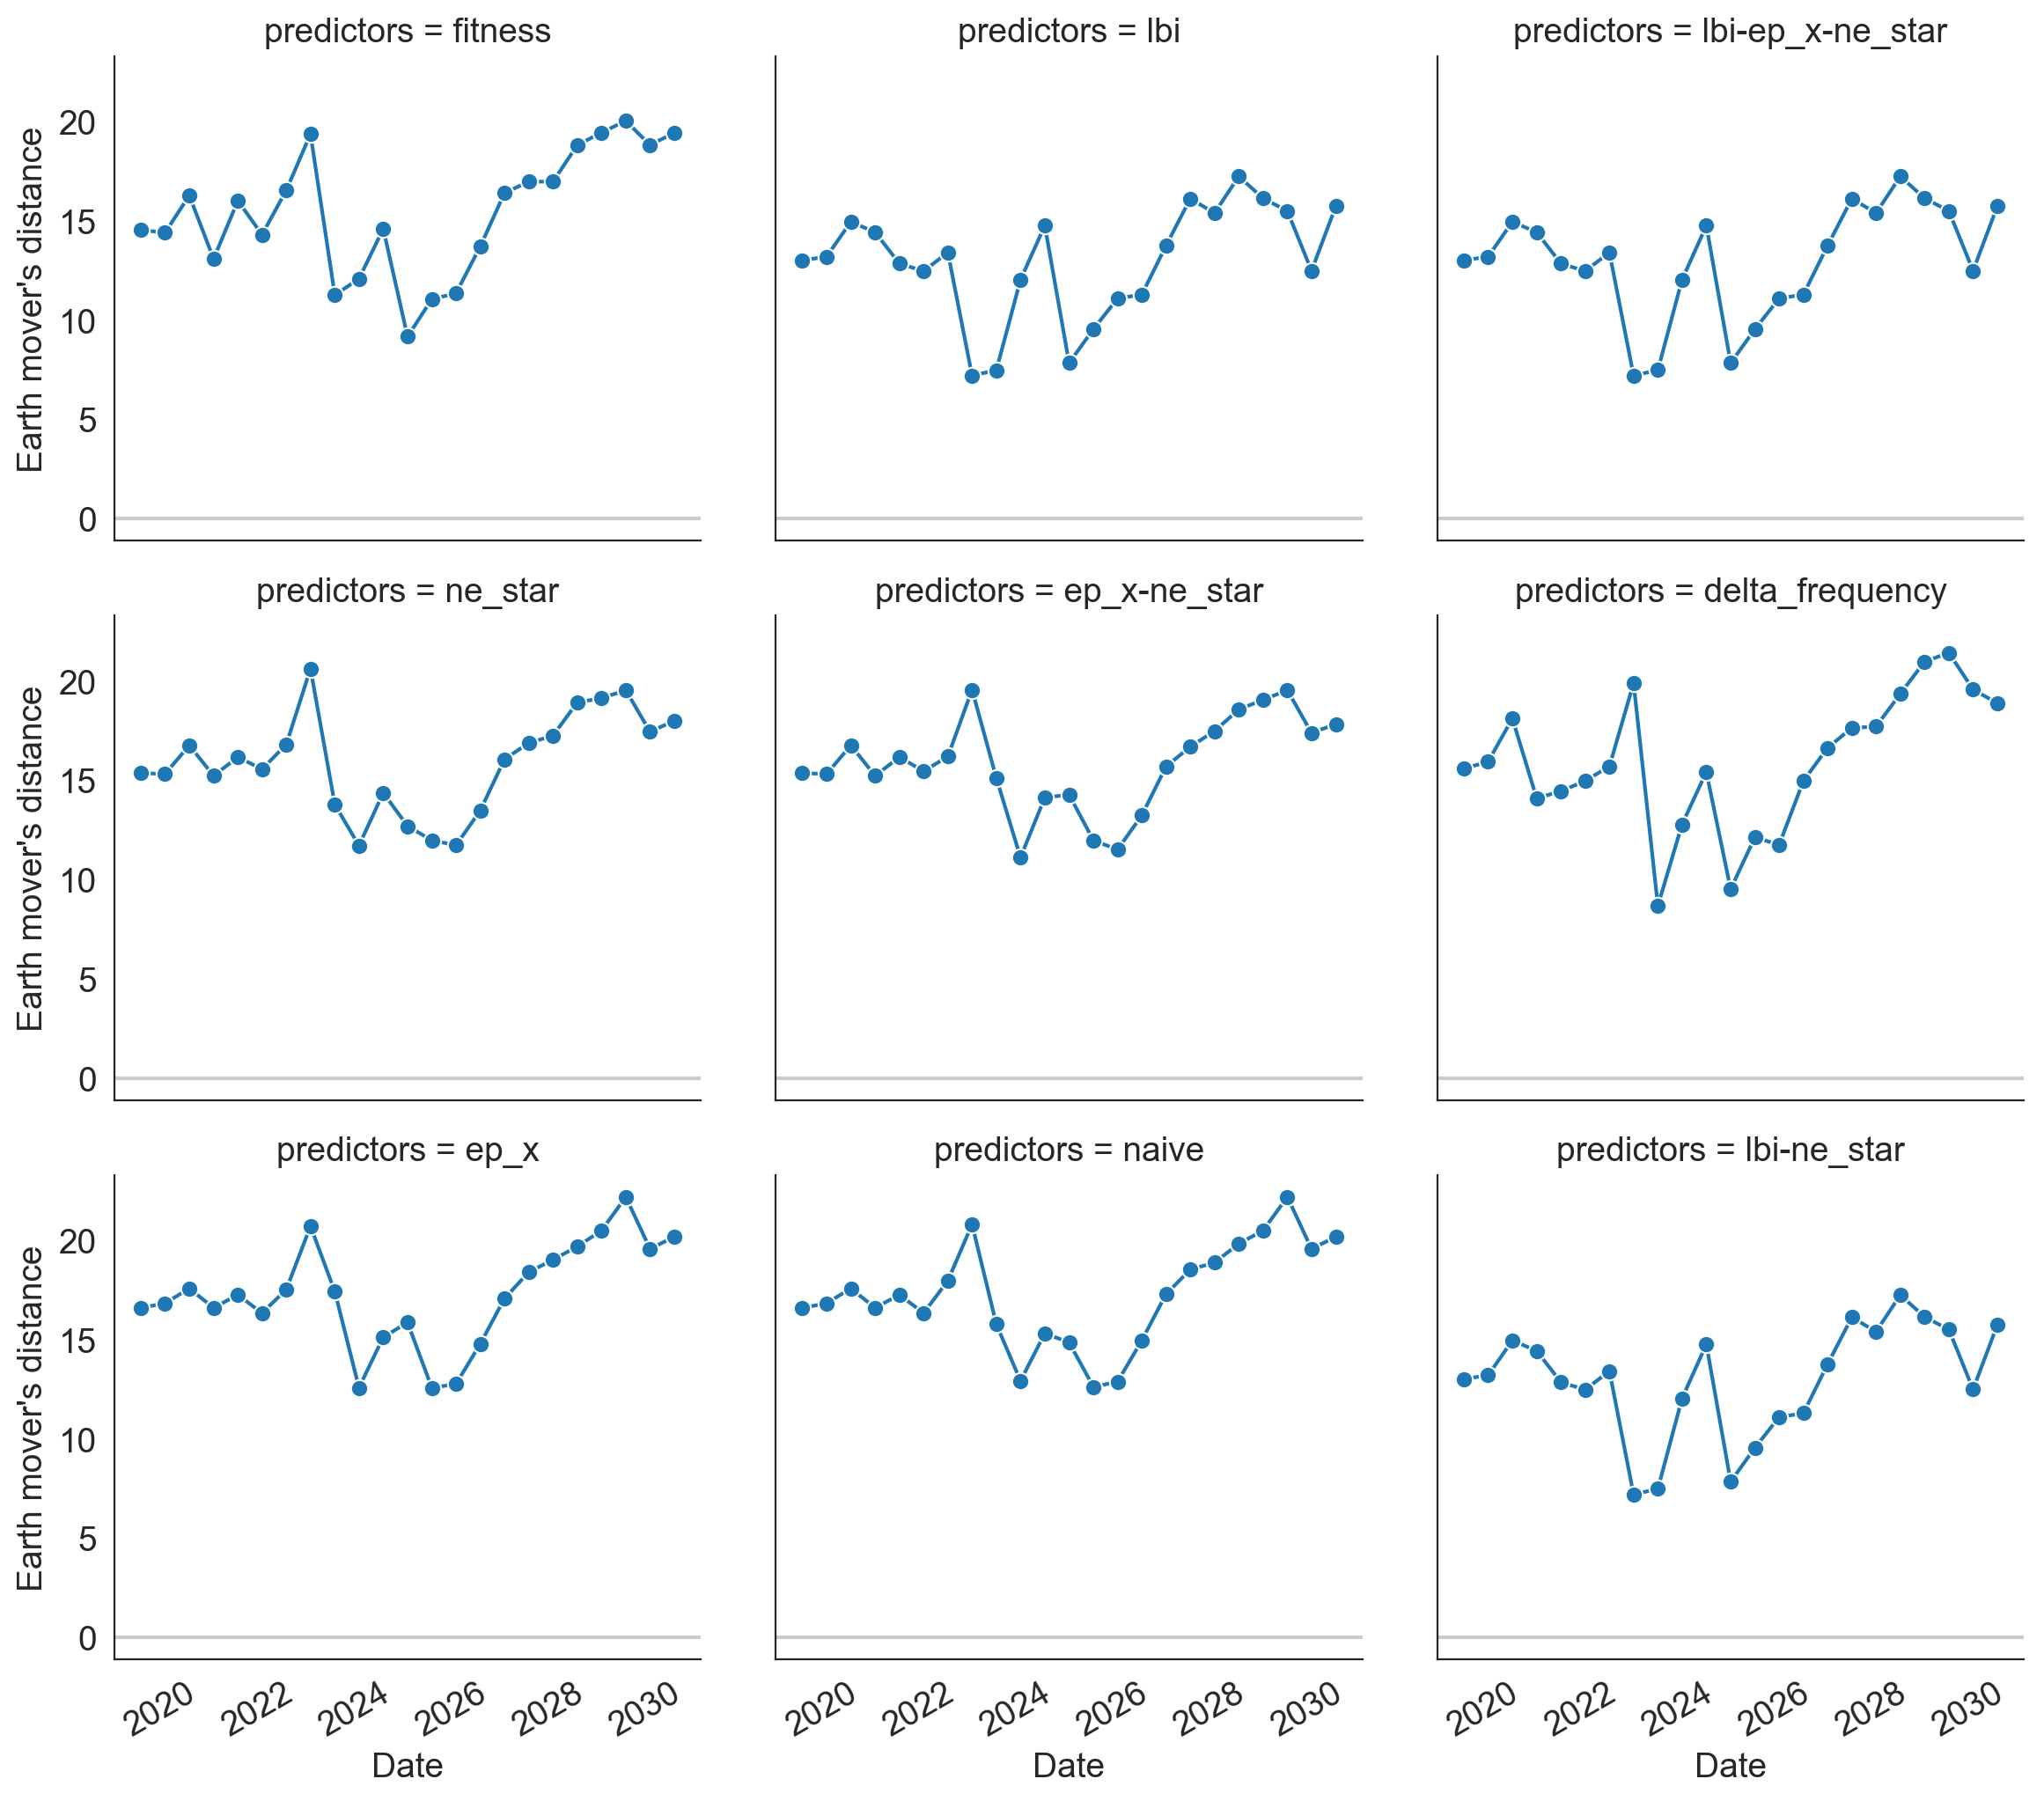

In [84]:
g = facet_time_plot(
    errors_by_time_df,
    "validation_error",
    "Earth mover's distance",
    timepoint_column="validation_timepoint",
    col_wrap=3,
    markersize=7
)

### Adjusted earth mover's distance (relative to naive model)

In [85]:
naive_error = errors_by_time_df[errors_by_time_df["predictors"] == "naive"]["validation_error"].values
for predictor in errors_by_time_df["predictors"].drop_duplicates().values:
    errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "adjusted_error"] = errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "validation_error"] - naive_error

In [86]:
naive_error

array([16.59199438, 16.83172801, 17.57621931, 16.6037659 , 17.25741913,
       16.33619374, 17.96826414, 20.80899309, 15.77627588, 12.91877731,
       15.31571263, 14.85798021, 12.61951892, 12.8762704 , 14.96280185,
       17.29266066, 18.53262542, 18.87622057, 19.83152239, 20.49455428,
       22.18981436, 19.57185695, 20.17867861])

In [87]:
median_adjusted_error = errors_by_time_df.groupby("predictors")["adjusted_error"].median().reset_index().sort_values(by="adjusted_error")
median_adjusted_error_order = median_adjusted_error["predictors"].values

In [88]:
min_error = errors_by_time_df["adjusted_error"].min()

In [89]:
max_error = errors_by_time_df["adjusted_error"].max()

In [90]:
median_adjusted_error_order

array(['lbi-ep_x-ne_star', 'lbi-ne_star', 'lbi', 'fitness',
       'ep_x-ne_star', 'ne_star', 'delta_frequency', 'ep_x', 'naive'],
      dtype=object)

In [91]:
median_adjusted_error.head()

predictors  adjusted_error
5  lbi-ep_x-ne_star       -3.632082
6       lbi-ne_star       -3.632021
4               lbi       -3.631879
3           fitness       -1.428976
2      ep_x-ne_star       -1.375654

In [92]:
minimal_median_adjusted_error_order = [
    predictor for predictor in median_adjusted_error_order
    if predictor in minimal_predictor_names_order
]

Text(0,0.5,'Model')

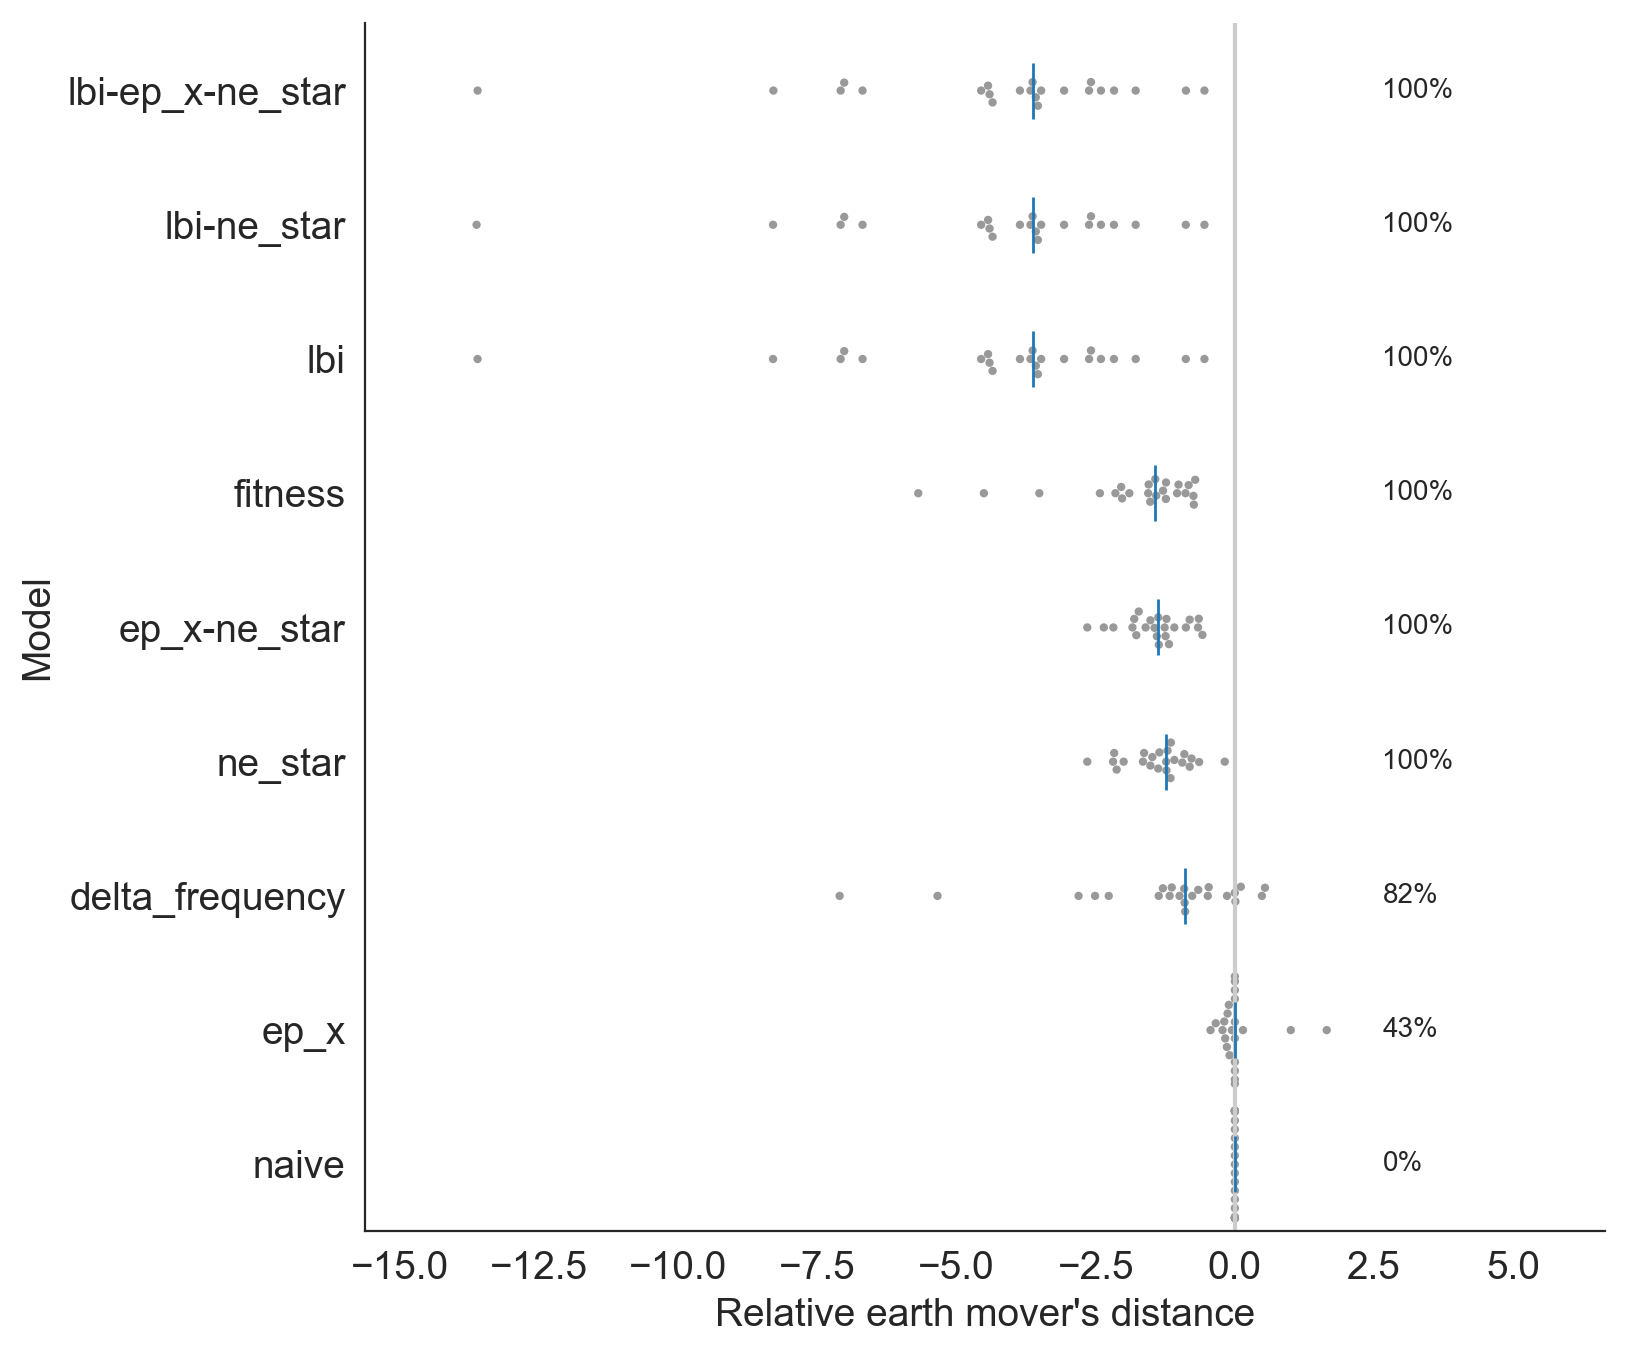

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_xlim(min_error - 2, max_error + 5)

ax = sns.swarmplot(
    x="adjusted_error",
    y="predictors",
    data=errors_by_time_df,
    ax=ax,
    order=median_adjusted_error_order,
    color="#999999",
    zorder=-10,
    size=3
)

ax.plot(
    median_adjusted_error["adjusted_error"],
    median_adjusted_error_order,
    marker="|",
    markersize=20,
    linestyle=""
)


#ax.text(0.5, 0, "test")
for i, predictor in enumerate(median_adjusted_error_order):
    predictor_errors = errors_by_time_df.loc[errors_by_time_df["predictors"] == predictor, "adjusted_error"]
    
    ax.text(
        max_error + 1,
        i,
        "%i%%" % (((predictor_errors < 0).sum() / float(predictor_errors.shape[0])) * 100),
        horizontalalignment='left',
        verticalalignment='center',
        fontsize=10
    )

ax.axvline(x=0, color="#cccccc", zorder=-10)

ax.set_xlabel("Relative earth mover's distance")
ax.set_ylabel("Model")

In [94]:
errors_by_time_df.groupby("predictors")["adjusted_error"].aggregate(["mean", "std"])

mean       std
predictors                          
delta_frequency  -1.306887  1.790774
ep_x              0.039150  0.437004
ep_x-ne_star     -1.417964  0.537173
fitness          -1.800813  1.238806
lbi              -4.270006  2.809134
lbi-ep_x-ne_star -4.269649  2.808850
lbi-ne_star      -4.270801  2.811859
naive             0.000000  0.000000
ne_star          -1.367642  0.576855

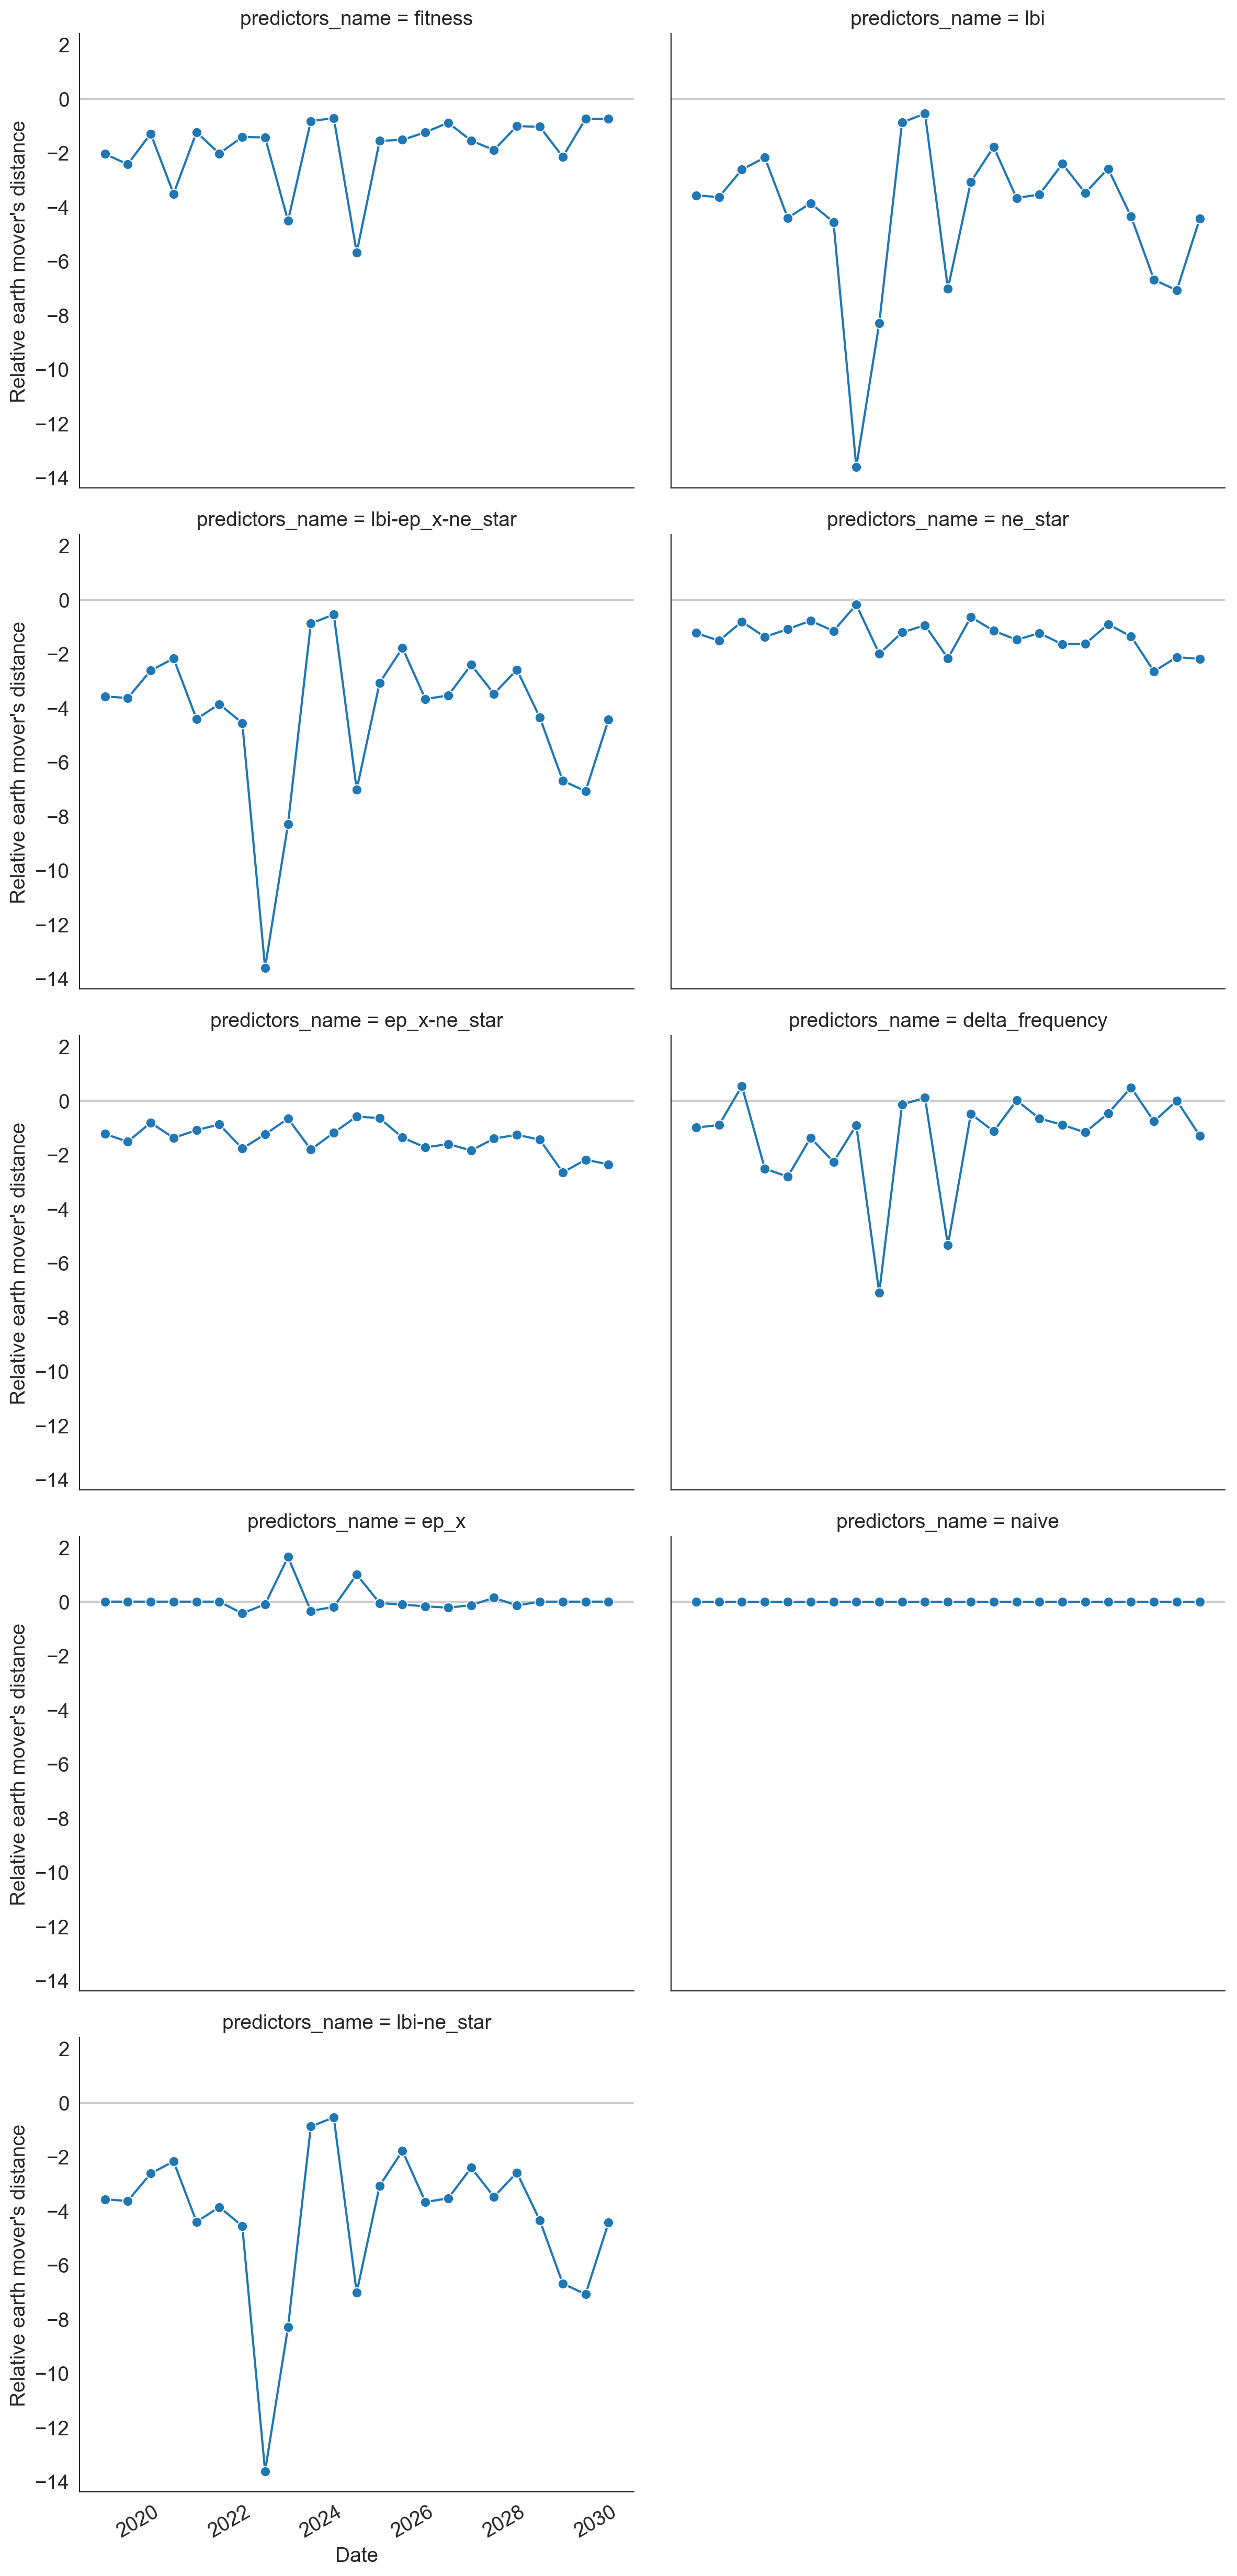

In [95]:
g = facet_time_plot(
    errors_by_time_df,
    "adjusted_error",
    "Relative earth mover's distance",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    height=6,
    aspect=1,
    col_wrap=2,
    markersize=7
)
#g.set_titles("{col_name}")
#g.fig.subplots_adjust(hspace=0.2)

In [96]:
errors_and_coefficients_by_time = coefficients_by_time_df.merge(
    errors_by_time_df,
    on=["predictors", "validation_timepoint"]
)

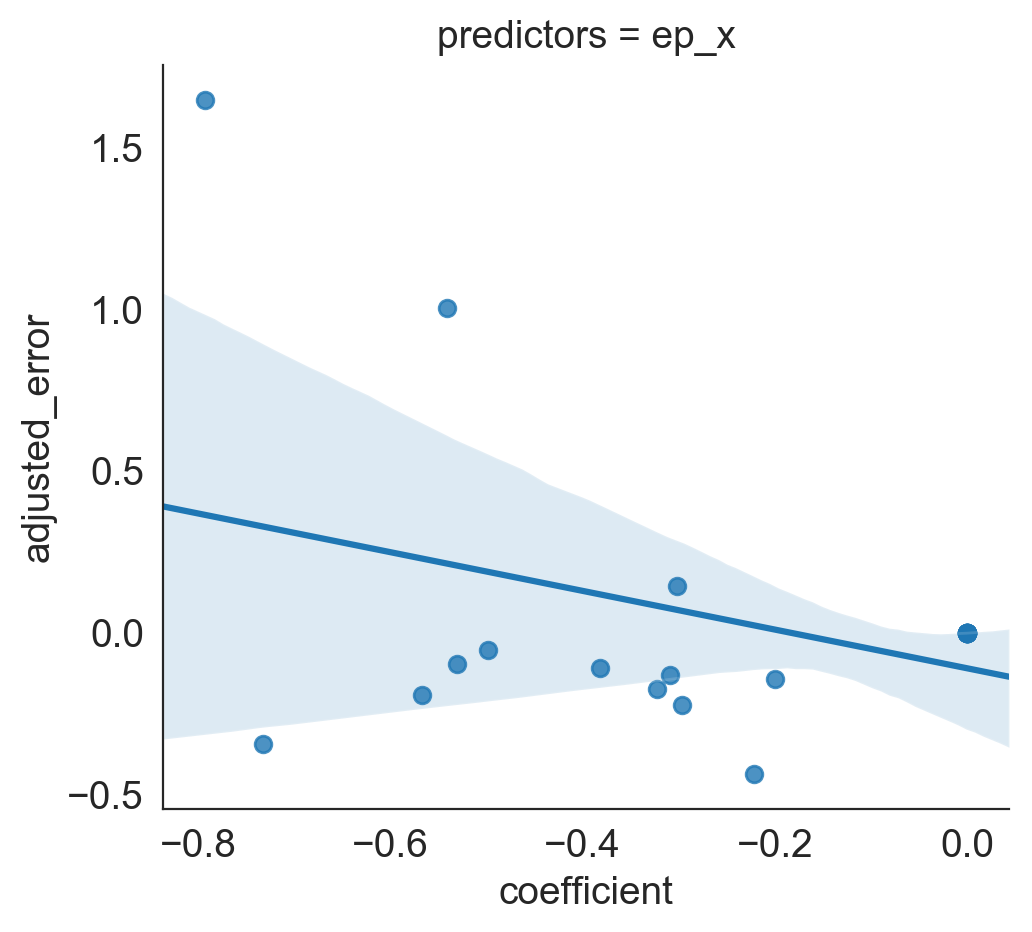

In [97]:
sns.lmplot(
    "coefficient",
    "adjusted_error",
    errors_and_coefficients_by_time,
    col="predictors",
    col_wrap=2,
    sharex=False,
    sharey=False,
    col_order=["ep_x"]
)

## Summarize model coefficients

In [98]:
overall_coefficients_df

mean        predictor        predictors           std
0   2.630743e+00          fitness           fitness  6.037336e-01
1   2.829286e+00              lbi               lbi  1.930961e-01
2   2.823151e+00              lbi  lbi-ep_x-ne_star  1.970064e-01
3   6.425161e-04             ep_x  lbi-ep_x-ne_star  3.019163e-03
4  -1.329034e-02          ne_star  lbi-ep_x-ne_star  6.224337e-02
5  -1.248248e+00          ne_star           ne_star  1.588926e-01
6  -3.465458e-01             ep_x      ep_x-ne_star  3.383455e-01
7  -1.325405e+00          ne_star      ep_x-ne_star  1.425300e-01
8   1.549528e+00  delta_frequency   delta_frequency  5.160071e-01
9  -2.476039e-01             ep_x              ep_x  2.564384e-01
10  0.000000e+00            naive             naive  0.000000e+00
11  2.830334e+00              lbi       lbi-ne_star  1.935449e-01
12 -2.244715e-07          ne_star       lbi-ne_star  2.302920e-07

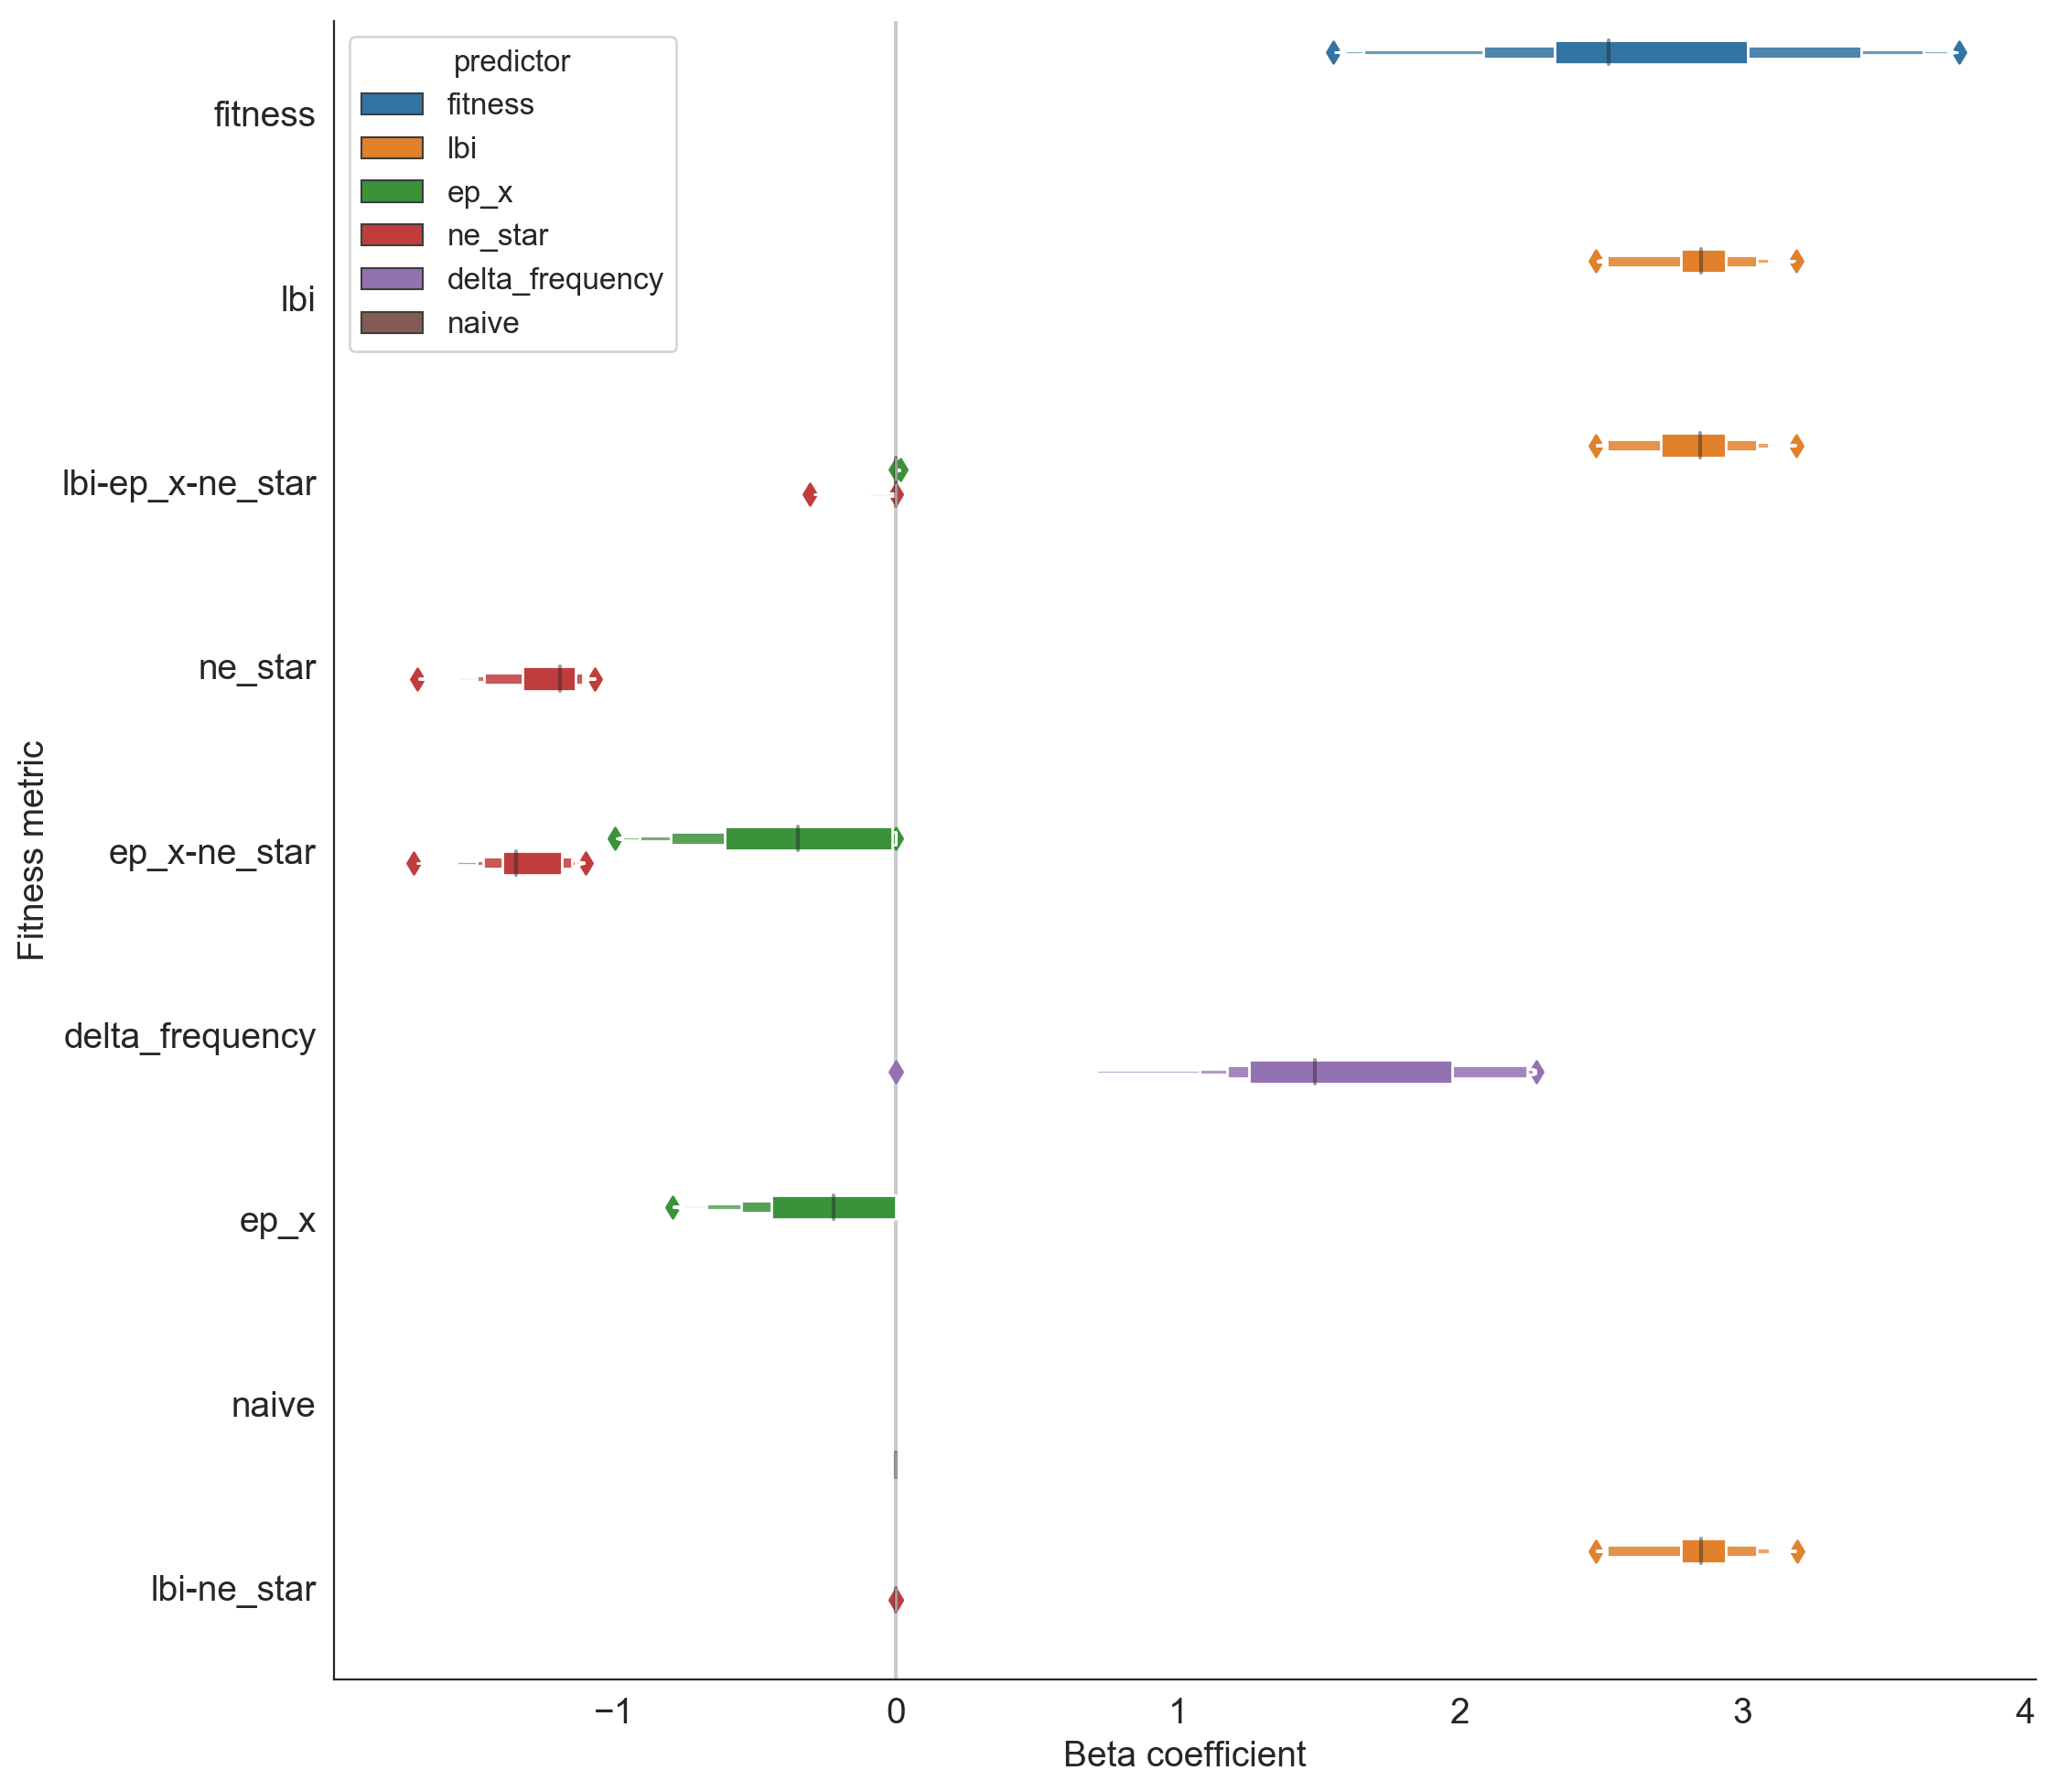

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

#ax.set_xlim(-20, 20)
sns.boxenplot(
    y="predictors",
    x="coefficient",
    hue="predictor",
    data=coefficients_by_time_df,
    ax=ax
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [100]:
coefficients_by_time_df["predictors_name"] = coefficients_by_time_df["predictors"].map(predictor_name_by_id)

In [101]:
coefficients_by_time_df.loc[pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors_name"] = coefficients_by_time_df.loc[
    pd.isnull(coefficients_by_time_df["predictors_name"]), "predictors"
]

In [102]:
coefficients_by_time_df["predictors_name"].unique().shape

(9,)

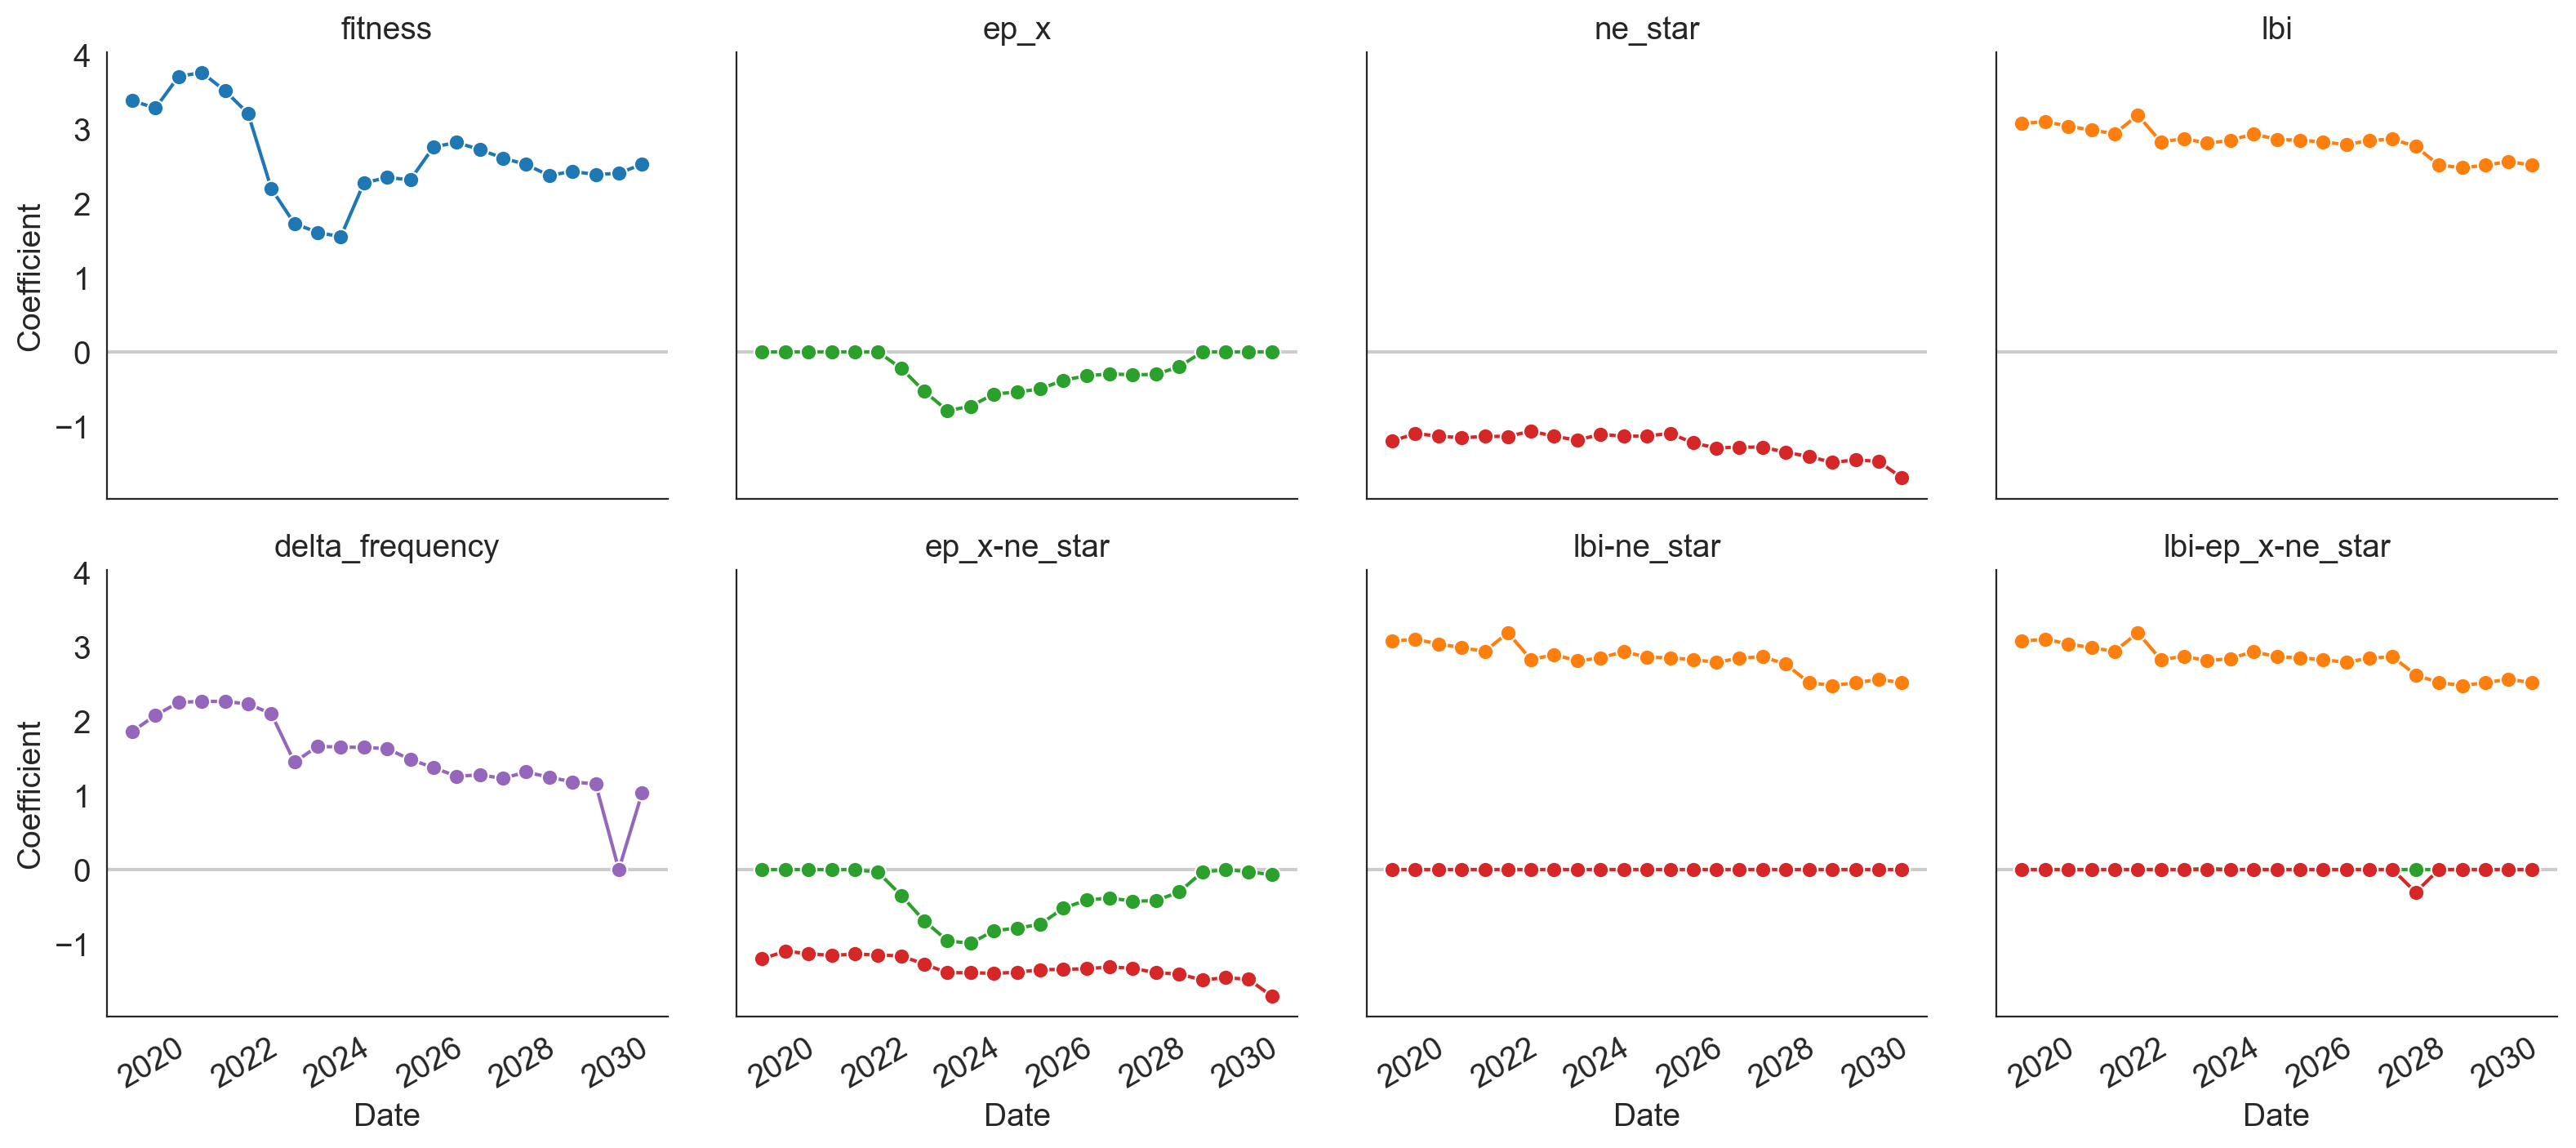

In [103]:
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"] != "naive"],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    predictors_column="predictors_name",
    col_order=[predictor_name_by_id[predictor] for predictor in predictor_type_order[1:]],
    hue="predictor",
    markersize=7
)
g.set_titles("{col_name}")

#for ax in g.axes.flatten():
#    ax.set_ylim(-11, 11)

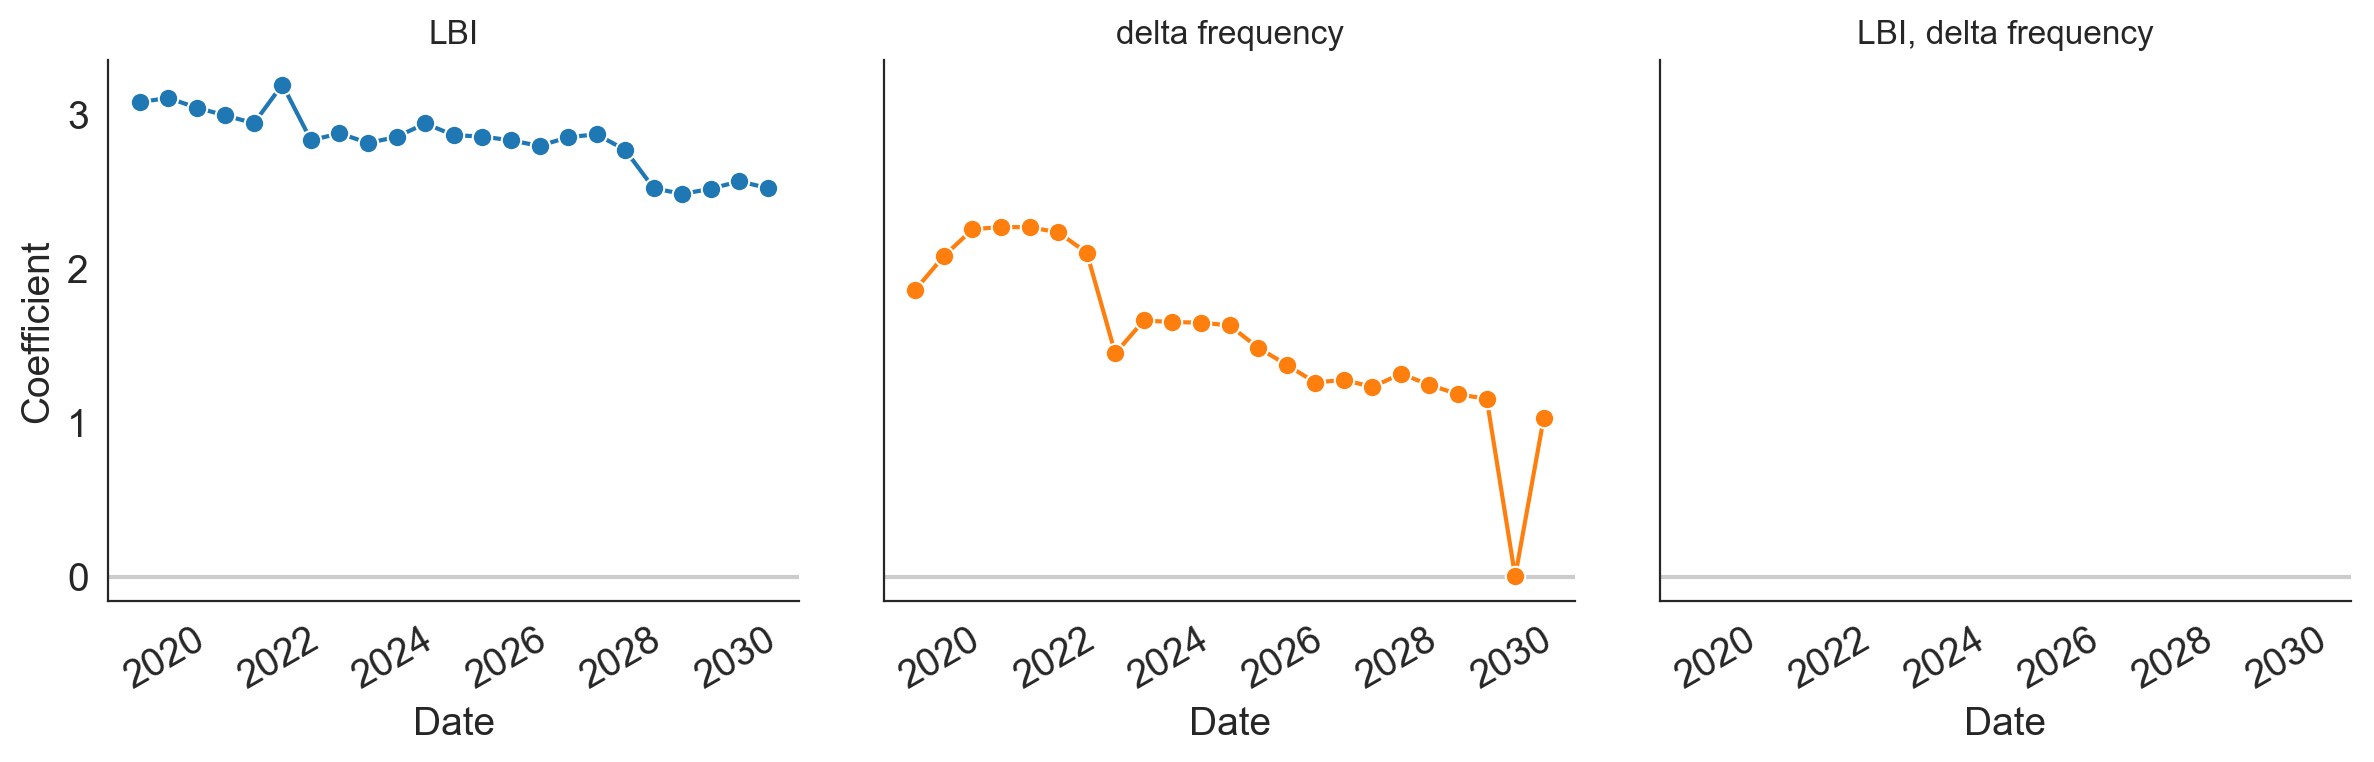

In [104]:
lbi_dfreq_order = ["lbi", "delta_frequency", "lbi-delta_frequency"]
lbi_dfreq_names = ["LBI", "delta frequency", "LBI, delta frequency"]
g = facet_time_plot(
    coefficients_by_time_df[coefficients_by_time_df["predictors"].isin(lbi_dfreq_order)],
    "coefficient",
    "Coefficient",
    timepoint_column="validation_timepoint",
    hue="predictor",
    col_order=lbi_dfreq_order,
    markersize=7
)

#g.set_titles("{col_name}")

for ci, ax in enumerate(g.axes.flatten()):
    ax.set_title(lbi_dfreq_names[ci], fontsize=12)
    #ax.set_ylim(-2., 2.)

## Summary statistics for models

In [105]:
errors_by_time_df.groupby("predictors")["adjusted_error"].aggregate(["mean", "std"])

mean       std
predictors                          
delta_frequency  -1.306887  1.790774
ep_x              0.039150  0.437004
ep_x-ne_star     -1.417964  0.537173
fitness          -1.800813  1.238806
lbi              -4.270006  2.809134
lbi-ep_x-ne_star -4.269649  2.808850
lbi-ne_star      -4.270801  2.811859
naive             0.000000  0.000000
ne_star          -1.367642  0.576855

In [106]:
overall_coefficients_df

mean        predictor        predictors           std
0   2.630743e+00          fitness           fitness  6.037336e-01
1   2.829286e+00              lbi               lbi  1.930961e-01
2   2.823151e+00              lbi  lbi-ep_x-ne_star  1.970064e-01
3   6.425161e-04             ep_x  lbi-ep_x-ne_star  3.019163e-03
4  -1.329034e-02          ne_star  lbi-ep_x-ne_star  6.224337e-02
5  -1.248248e+00          ne_star           ne_star  1.588926e-01
6  -3.465458e-01             ep_x      ep_x-ne_star  3.383455e-01
7  -1.325405e+00          ne_star      ep_x-ne_star  1.425300e-01
8   1.549528e+00  delta_frequency   delta_frequency  5.160071e-01
9  -2.476039e-01             ep_x              ep_x  2.564384e-01
10  0.000000e+00            naive             naive  0.000000e+00
11  2.830334e+00              lbi       lbi-ne_star  1.935449e-01
12 -2.244715e-07          ne_star       lbi-ne_star  2.302920e-07

### Figure 2: Summary of models for simulated populations

In [107]:
nrows = len(individual_predictor_names_order)
ncols = 2
color_by_predictor = {
    "fitness": "#2c7bb6",
    "ep_x": "#abd9e9",
    "ne_star": "#999999",
    "lbi": "#fdae61",
    "delta_frequency": "#d7191c"
}

name_by_predictor = {
    "fitness": "true fitness",
    "ep_x": "cross-immunity",
    "ne_star": "non-epitope mutations",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

In [108]:
min_error = errors_by_time_df["adjusted_error"].min()
max_error = errors_by_time_df["adjusted_error"].max()

min_coefficient = coefficients_by_time_df["coefficient"].min()
max_coefficient = coefficients_by_time_df["coefficient"].max()

min_date = errors_by_time_df["validation_timepoint"].min() - np.timedelta64(6, 'M')
max_date = errors_by_time_df["validation_timepoint"].max() + np.timedelta64(6, 'M')

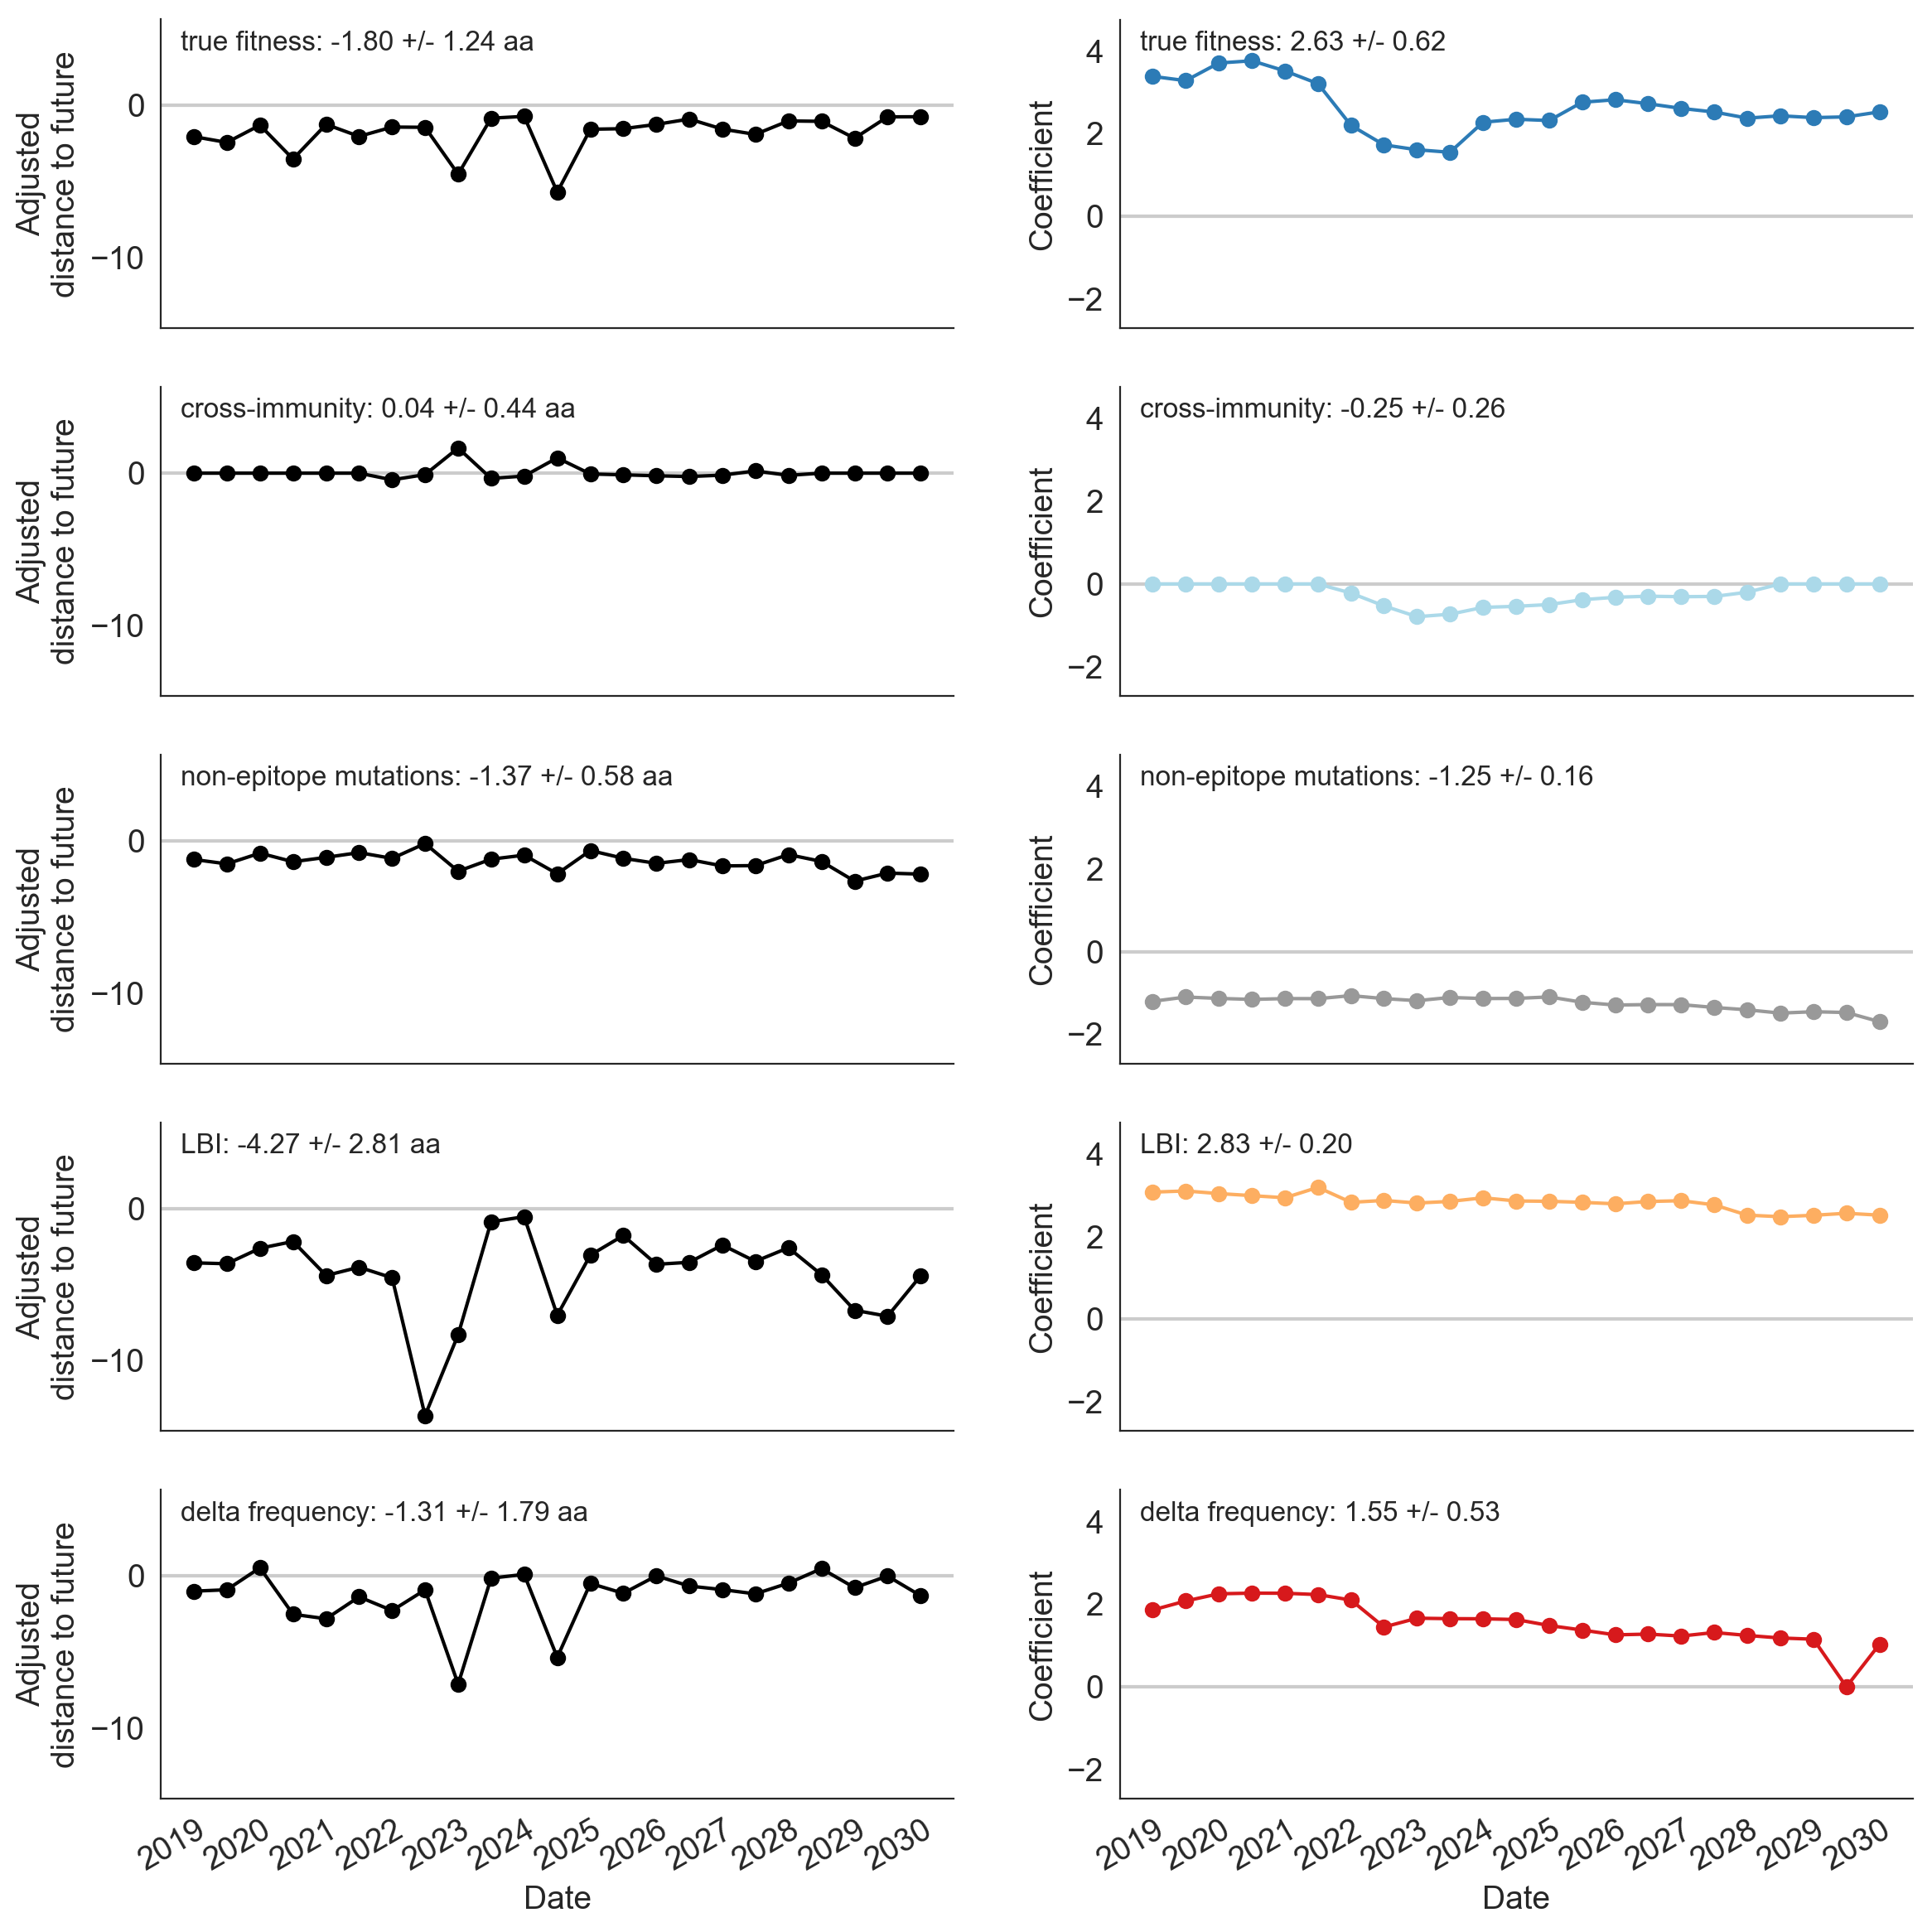

In [109]:
fig, axes = plt.subplots(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(
    nrows=nrows,
    ncols=ncols,
    hspace=0.1,
    wspace=0.2
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

for i, predictor in enumerate(individual_predictor_names_order):
    error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
    coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()

    distance_ax = plt.subplot(gs[i, 0])    
    distance_ax.set_xlabel("Date")
    distance_ax.set_ylabel("Adjusted\ndistance to future")
    distance_ax.set_ylim(min_error - 1, max_error + 4)
    distance_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f aa" % (name_by_predictor[predictor], error_df["adjusted_error"].mean(), error_df["adjusted_error"].std()),
        fontdict={"fontsize": 12},
        transform=distance_ax.transAxes
    )
    
    distance_ax.axhline(
        y=0.0,
        color="#cccccc"
    )
    
    distance_ax.plot(
        pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
        error_df["adjusted_error"],
        "o-",
        color="#000000"
    )
    
    distance_ax.set_xlim(min_date, max_date)
    distance_ax.xaxis.set_major_locator(years)
    distance_ax.xaxis.set_major_formatter(years_fmt)
    distance_ax.xaxis.set_minor_locator(months)
    distance_ax.format_xdata = mdates.DateFormatter('%Y-%m')
        
    coefficient_ax = plt.subplot(gs[i, 1])
    coefficient_ax.set_xlabel("Date")
    coefficient_ax.set_ylabel("Coefficient")
    coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 1)

    coefficient_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f" % (name_by_predictor[predictor], coefficient_df["coefficient"].mean(), coefficient_df["coefficient"].std()),
        fontdict={"fontsize": 12},
        transform=coefficient_ax.transAxes
    )
    
    coefficient_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    coefficient_ax.plot(
        coefficient_df["validation_timepoint"],
        coefficient_df["coefficient"],
        "o-",
        color=color_by_predictor[predictor]
    )
    
    coefficient_ax.set_xlim(min_date, max_date)
    coefficient_ax.xaxis.set_major_locator(years)
    coefficient_ax.xaxis.set_major_formatter(years_fmt)
    coefficient_ax.xaxis.set_minor_locator(months)
    coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')
    
fig.autofmt_xdate()

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/model-accuracy-and-coefficients-for-simulated-populations.png")

# show x-axis tick lines

In [110]:
composite_predictor_names_order = ["lbi", "ep_x", "ne_star"] + [
    predictor
    for predictor in predictor_names_order
    if "-" in predictor
]

In [111]:
nrows_composite = len(composite_predictor_names_order)

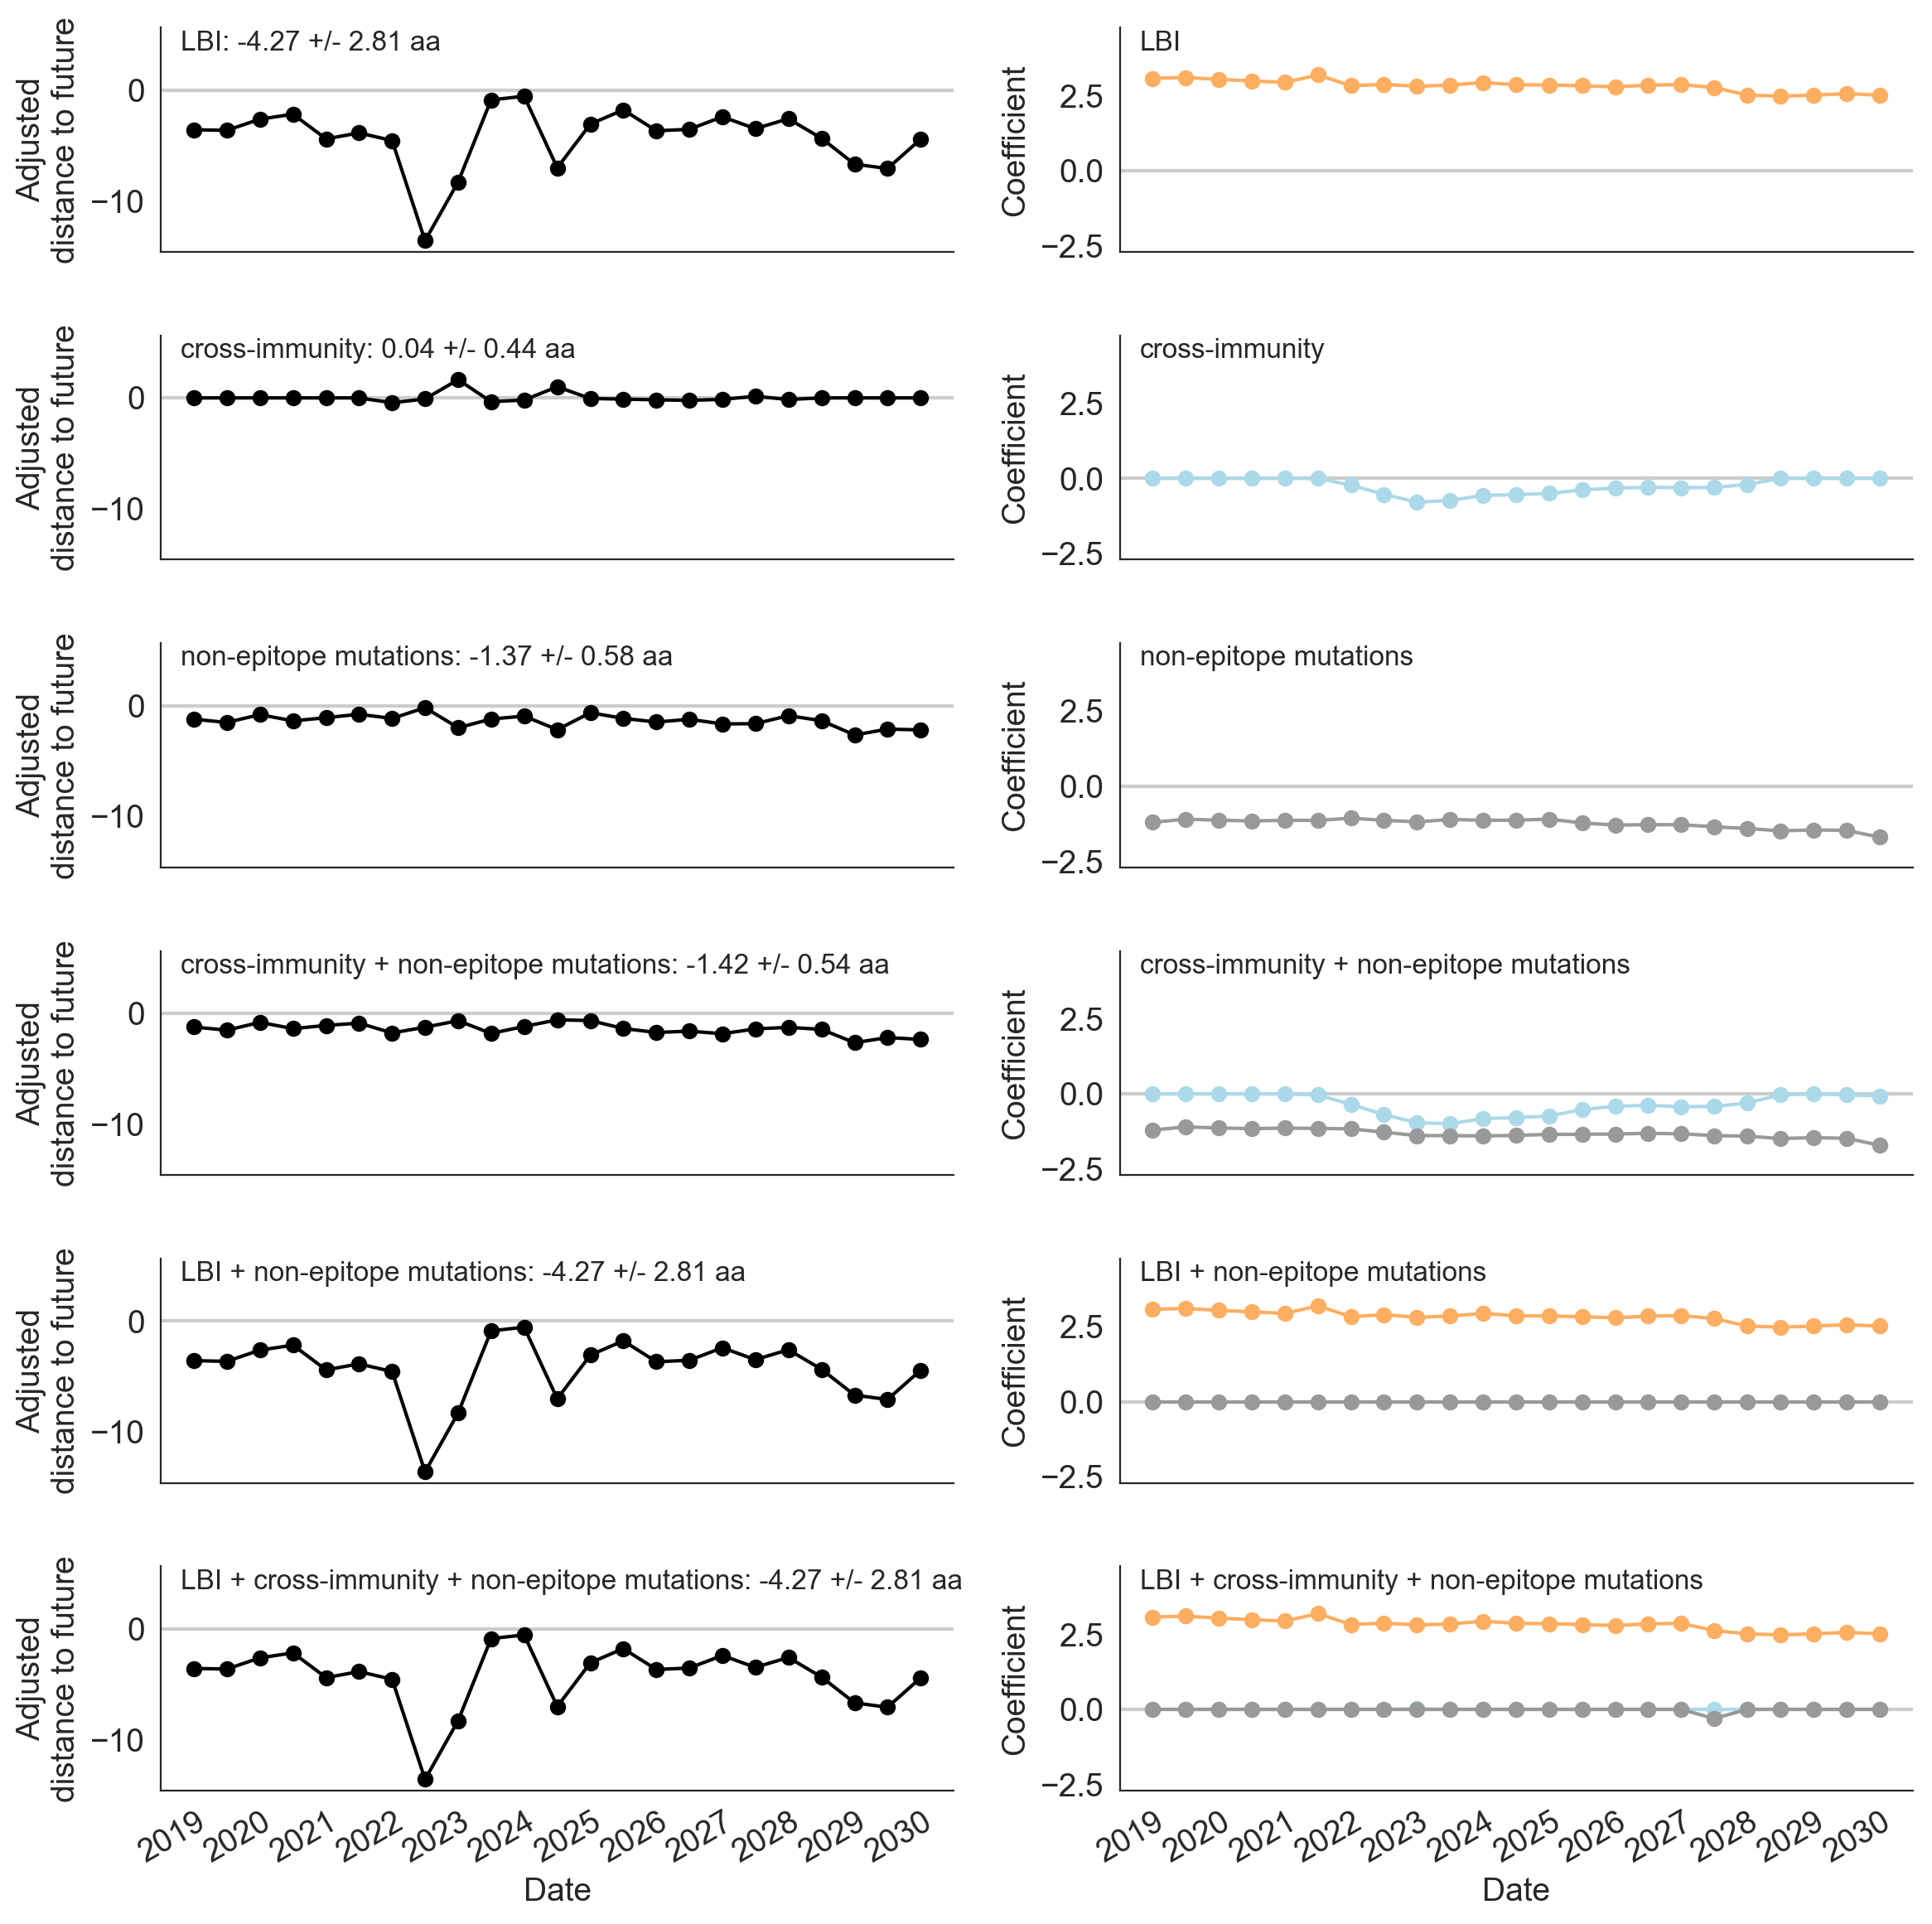

In [112]:
fig, axes = plt.subplots(figsize=(12, 12), facecolor='w')
gs = gridspec.GridSpec(
    nrows=nrows_composite,
    ncols=ncols,
    hspace=0.1,
    wspace=0.2
)

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

for i, predictor in enumerate(composite_predictor_names_order):
    error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
    coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
    composite_predictors = predictor.split("-")
    composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])

    distance_ax = plt.subplot(gs[i, 0])    
    distance_ax.set_xlabel("Date")
    distance_ax.set_ylabel("Adjusted\ndistance to future")
    distance_ax.set_ylim(min_error - 1, max_error + 4)
    distance_ax.text(
        0.025,
        0.9,
        "%s: %.2f +/- %.2f aa" % (composite_predictors_name, error_df["adjusted_error"].mean(), error_df["adjusted_error"].std()),
        fontdict={"fontsize": 12},
        transform=distance_ax.transAxes
    )
    
    distance_ax.axhline(
        y=0.0,
        color="#cccccc"
    )
    
    distance_ax.plot(
        pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
        error_df["adjusted_error"],
        "o-",
        color="#000000"
    )
    
    distance_ax.set_xlim(min_date, max_date)
    distance_ax.xaxis.set_major_locator(years)
    distance_ax.xaxis.set_major_formatter(years_fmt)
    distance_ax.xaxis.set_minor_locator(months)
    distance_ax.format_xdata = mdates.DateFormatter('%Y-%m')
        
    coefficient_ax = plt.subplot(gs[i, 1])
    coefficient_ax.set_xlabel("Date")
    coefficient_ax.set_ylabel("Coefficient")
    coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient + 1)

    coefficient_ax.text(
        0.025,
        0.9,
        "%s" % (composite_predictors_name,),
        fontdict={"fontsize": 12},
        transform=coefficient_ax.transAxes
    )
    
    coefficient_ax.axhline(
        y=0.0,
        color="#cccccc"
    )

    for predictor, predictor_coefficient_df in coefficient_df.groupby("predictor"):
        coefficient_ax.plot(
            predictor_coefficient_df["validation_timepoint"],
            predictor_coefficient_df["coefficient"],
            "o-",
            color=color_by_predictor[predictor]
        )
    
    coefficient_ax.set_xlim(min_date, max_date)
    coefficient_ax.xaxis.set_major_locator(years)
    coefficient_ax.xaxis.set_major_formatter(years_fmt)
    coefficient_ax.xaxis.set_minor_locator(months)
    coefficient_ax.format_xdata = mdates.DateFormatter('%Y-%m')
    
fig.autofmt_xdate()

gs.tight_layout(fig)
plt.savefig("../manuscript/figures/composite-model-accuracy-and-coefficients-for-simulated-populations.png")

# show x-axis tick lines

In [128]:
X = pd.DataFrame(models_by_predictors["ep_x"]["scores"][0]["training_data"]["X"])

In [130]:
model = DistanceExponentialGrowthModel(["ep_x"], 1.0, 0.5, lambda x: x, {})

In [131]:
mean_stds = model.calculate_mean_stds(X, model.predictors)

In [132]:
mean_stds

array([0.24393437])

In [133]:
X.loc[:, ["timepoint"] + model.predictors].groupby("timepoint").std()

ep_x
timepoint           
2011-10-01  0.049700
2012-04-01  0.108765
2012-10-01  0.142992
2013-04-01  0.194294
2013-10-01  0.264743
2014-04-01  0.279191
2014-10-01  0.317003
2015-04-01  0.334139
2015-10-01  0.217714
2016-04-01  0.267041
2016-10-01  0.305049
2017-04-01  0.337047
2017-10-01  0.353470

In [135]:
for timepoint, timepoint_df in X.groupby("timepoint"):
    predictors = timepoint_df.loc[:, model.predictors].values
    standardized_predictors = model.standardize_predictors(predictors, mean_stds)
    break

(array([ 6.,  0., 35.,  5., 27.,  1., 14.,  5.,  6.,  3.]),
 array([-0.70473775, -0.68231557, -0.6598934 , -0.63747122, -0.61504904,
        -0.59262686, -0.57020468, -0.54778251, -0.52536033, -0.50293815,
        -0.48051597]),
 <a list of 10 Patch objects>)

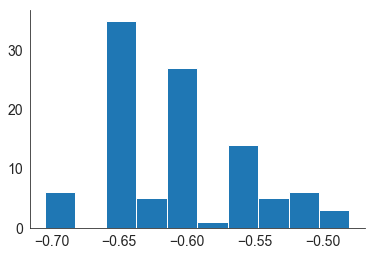

In [138]:
plt.hist(predictors, bins=10)

In [142]:
predictors.mean()

-0.6078440270079813

In [140]:
standardized_predictors.shape

(102, 1)

(array([ 6.,  0., 35.,  5., 27.,  1., 14.,  5.,  6.,  3.]),
 array([-0.39721227, -0.30529338, -0.21337448, -0.12145558, -0.02953669,
         0.06238221,  0.15430111,  0.24622   ,  0.3381389 ,  0.4300578 ,
         0.52197669]),
 <a list of 10 Patch objects>)

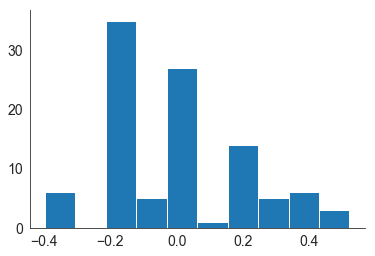

In [143]:
plt.hist(standardized_predictors, bins=10)